# Big Data and Data Mining with SQL Relational Databases

## Summative Assessment (Project Report)

##### Student Number : 202353550

#### Import packages

In [18]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde  # Density on scatterplot

In [19]:
 # APRIORI 
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [20]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.cluster import DBSCAN

In [21]:
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_squared_error

In [22]:
import networkx as nx

#### Connect to Database

In [6]:
 # Connect to Database and create a cursor for queries
con=sqlite3.connect("accident_data_v1.0.0_2023.db")
cur=con.cursor()

#### Get tables in Database

In [7]:
# Get tables information in accident databse
tab_info = cur.execute("""
    SELECT name
    FROM sqlite_master
""")
tables_DB=tab_info.fetchall()
print(tables_DB)

[('accident',), ('sqlite_autoindex_accident_1',), ('casualty',), ('sqlite_autoindex_casualty_1',), ('vehicle',), ('sqlite_autoindex_vehicle_1',), ('lsoa',), ('sqlite_autoindex_lsoa_1',)]


In [8]:
 # Utilize a for-loop to get table names
DB_tables=[]
for table in tables_DB:
    DB_tables.append(table[0])

print(DB_tables)

['accident', 'sqlite_autoindex_accident_1', 'casualty', 'sqlite_autoindex_casualty_1', 'vehicle', 'sqlite_autoindex_vehicle_1', 'lsoa', 'sqlite_autoindex_lsoa_1']


In [9]:
 # Utilize a for-loop to delete other strings
indices_to_remove = [7, 5, 3, 1]  # Start from the largest index to avoid shifting issues
for index in indices_to_remove:
    del DB_tables[index]

print(f"There are {len(DB_tables)} tables in the accident database:" , DB_tables)

There are 4 tables in the accident database: ['accident', 'casualty', 'vehicle', 'lsoa']


#### Extract 4 tables

In [14]:
 # ACCIDENT TABLE EXTRACTION
acc=cur.execute("""
   SELECT *
   FROM accident
   WHERE accident_year = 2020
""")
acc_tab=acc.fetchall()

acc_headers = [description[0] for description in cur.description]  # get column names
ac_df=pd.DataFrame(acc_tab, columns=acc_headers)  # creates a pandas dataframe

 # Save a csv copy
ac_df.to_csv("accident.csv",index=False)

In [17]:
# CASUALTY TABLE EXTRACTION
cas=cur.execute("""
   SELECT *
   FROM casualty
   WHERE accident_year=2020
""")
cas_tab=cas.fetchall()

cas_headers = [description[0] for description in cur.description]
ca_df=pd.DataFrame(cas_tab, columns=cas_headers)

 # Save a csv copy
ca_df.to_csv("casualty.csv",index=False)

In [20]:
 # VEHICLE TABLE EXTRACTION
veh=cur.execute("""
   SELECT *
   FROM vehicle
   WHERE accident_year=2020
""")
veh_tab=veh.fetchall()

veh_headers = [description[0] for description in cur.description]
ve_df=pd.DataFrame(veh_tab, columns=veh_headers)

 # Save a csv copy
ve_df.to_csv("vehicle.csv",index=False)

In [22]:
 # LSOA TABLE EXTRACTION
lsoa=cur.execute("""
   SELECT *
   FROM lsoa
""")
lsoa_tab=lsoa.fetchall()

ls_headers = [description[0] for description in cur.description]
ls_df=pd.DataFrame(lsoa_tab, columns=ls_headers)

 # Save a csv copy
ls_df.to_csv("lsoa.csv",index=False)

In [45]:
con.close()   # Close connection to database

#### Load Dataframes

In [23]:
 # Overwrite dataframe variable names to prevent multiple variable names

ac_df = pd.read_csv("accident.csv",low_memory=False)  # 'low_memory = False'- for string variables with mixed datatypes
ca_df = pd.read_csv("casualty.csv",low_memory=False)
ve_df = pd.read_csv("vehicle.csv",low_memory=False)
ls_df = pd.read_csv("lsoa.csv",low_memory=False)

#### Data Cleaning Functions

In [5]:
def remove_missing_values(df):
    """
    Utilize this method for clustering,
    and some prediction purposes,
    where outliers are sensitive to the model being used.
    """
    df.dropna(inplace=True)

    return df
    

def fill_missing_values(df):
    """
    Utilize this method when we want to retain as much information,
    as possible
    """
    df.fillna(-99999) 

    return df

### 1. Are there significant hours of the day, and days of the week, on which accidents occur?

In [6]:
pd.set_option('display.max_columns', None)
ac_df.head()

accident_index  accident_year accident_reference  location_easting_osgr  \
0  2020010219808           2020          010219808               521389.0   
1  2020010220496           2020          010220496               529337.0   
2  2020010228005           2020          010228005               526432.0   
3  2020010228006           2020          010228006               538676.0   
4  2020010228011           2020          010228011               529324.0   

   location_northing_osgr  longitude   latitude  police_force  \
0                175144.0  -0.254001  51.462262             1   
1                176237.0  -0.139253  51.470327             1   
2                182761.0  -0.178719  51.529614             1   
3                184371.0  -0.001683  51.541210             1   
4                181286.0  -0.137592  51.515704             1   

   accident_severity  number_of_vehicles  number_of_casualties        date  \
0                  3                   1                     1  04/02/2020   
1                  3                   1                     2  27/04/2020   
2                  3                   1                     1  01/01/2020   
3                  2                   1                     1  01/01/2020   
4                  3                   1                     2  01/01/2020   

   day_of_week   time  local_authority_district local_authority_ons_district  \
0            3  09:00                        10                    E09000032   
1            2  13:55                         9                    E09000022   
2            4  01:25                         1                    E09000033   
3            4  01:50                        17                    E09000025   
4            4  02:25                         1                    E09000033   

  local_authority_highway  first_road_class  first_road_number  road_type  \
0               E09000032                 6                  0          6   
1               E09000022                 3               3036          6   
2               E09000033                 5                  0          6   
3               E09000025                 3                 11          6   
4               E09000033                 3                 40          6   

   speed_limit  junction_detail  junction_control  second_road_class  \
0           20                0                -1                  0   
1           20                9                 2                  6   
2           30                3                 1                  6   
3           30                0                -1                  0   
4           30                3                 4                  5   

   second_road_number  pedestrian_crossing_human_control  \
0                  -1                                  9   
1                   0                                  0   
2                   0                                  0   
3                  -1                                  0   
4                   0                                  0   

   pedestrian_crossing_physical_facilities  light_conditions  \
0                                        9                 1   
1                                        4                 1   
2                                        0                 4   
3                                        4                 4   
4                                        0                 4   

   weather_conditions  road_surface_conditions  special_conditions_at_site  \
0                   9                        9                           0   
1                   1                        1                           0   
2                   1                        2                           0   
3                   1                        1                           0   
4                   1                        1                           0   

   carriageway_hazards  urban_or_rural_area  \
0                    0                  

In [158]:
# Connect to Database
con = sqlite3.connect("accident_data_v1.0.0_2023.db")
cur = con.cursor()

 # Query to extract only the hour component from the "time" column for 2020
 # SUBSTR(time, 4, 2) extracts the minutes from the time string by starting at the 4th character and taking the next two characters (which represent the minutes part of "HH:MM"). 

cur.execute("""
    SELECT SUBSTR(time, 1, 2) AS hours
    FROM accident
    WHERE accident_year = 2020
""")

# Fetch results
hour_results = cur.fetchall() 

# Convert to DataFrame
time = pd.DataFrame(hour_results, columns=['hours'])

# Convert hour values to integers for numerical operations
time['hours'] = time['hours'].astype(int)

# Close database connection
con.close()

# Display the first few rows
time

hours
0          9
1         13
2          1
3          1
4          2
...      ...
91194     14
91195     15
91196     12
91197     14
91198     13

[91199 rows x 1 columns]

In [159]:
# Compute frequency of each hour
hour_counts = time['hours'].value_counts().sort_index()

# Create a DataFrame for plotting
hour_data = pd.DataFrame({'hours': hour_counts.index, 'freq': hour_counts.values})



C:\Users\Hp\AppData\Local\Temp\ipykernel_12556\839959945.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=hour_data, x='hours', y='freq', palette='viridis')


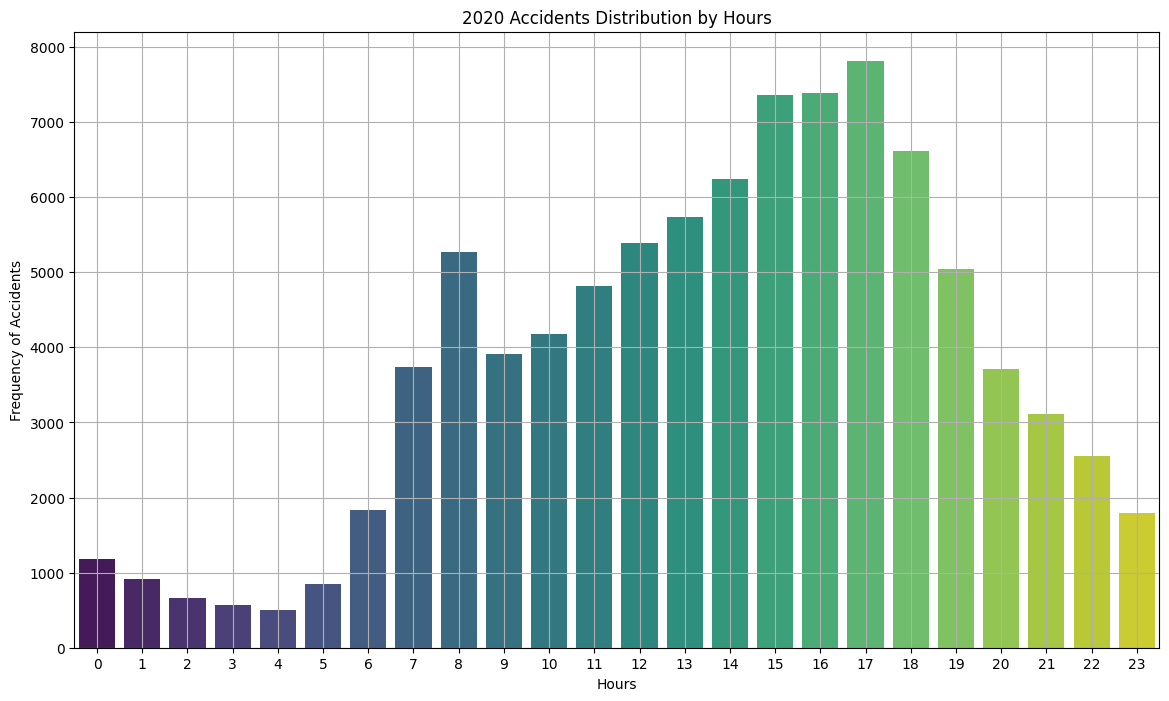

In [160]:
# Set figure size
plt.figure(figsize=(14, 8))

# Plot a bar chart using hours
sns.barplot(data=hour_data, x='hours', y='freq', palette='viridis')

# Set labels and title
plt.xlabel('Hours')
plt.ylabel('Frequency of Accidents')
plt.title('2020 Accidents Distribution by Hours')

# Enable grid lines
plt.grid(True)

# Ensure x-ticks cover all 24 hours
plt.xticks(range(0, 24))

# Save the plot as an image
plt.savefig("1.ac_hours.png")

# Display the plot
plt.show()


In [162]:
ac_df[['day_of_week']]

day_of_week
0                3
1                2
2                4
3                4
4                4
...            ...
91194            4
91195            6
91196            4
91197            3
91198            3

[91199 rows x 1 columns]

C:\Users\Hp\AppData\Local\Temp\ipykernel_12556\3943921313.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=day_counts.index, y=day_counts.values, palette='viridis')


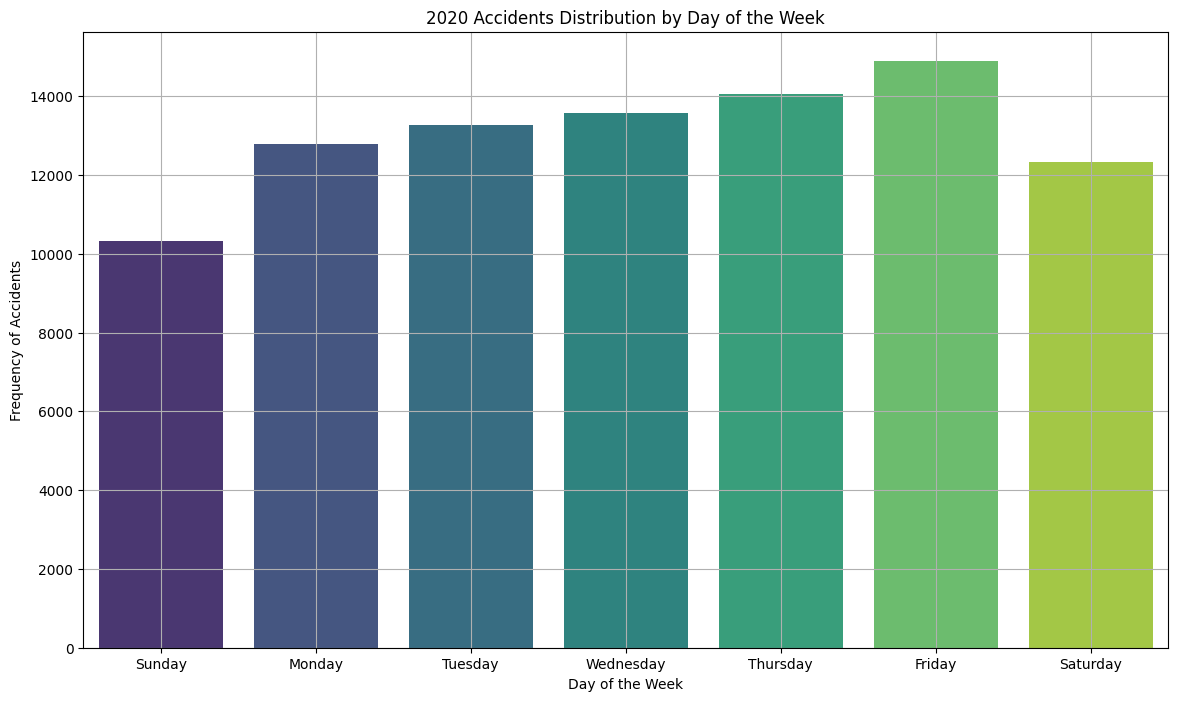

In [182]:
# Define mapping
days = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 
        5: 'Thursday', 6: 'Friday', 7: 'Saturday'}

# Compute day counts without modifying the original DataFrame
day_counts = ac_df['day_of_week'].map(days).value_counts().reindex(days.values())

# Plot the bar graph
plt.figure(figsize=(14, 8))

sns.barplot(x=day_counts.index, y=day_counts.values, palette='viridis')

plt.xlabel('Day of the Week')
plt.ylabel('Frequency of Accidents')
plt.title('2020 Accidents Distribution by Day of the Week')

plt.grid(True)
plt.savefig("2.ac_days.png")  # Save the plot as an image
plt.show()


In [164]:
ac_df.head()

accident_index  accident_year accident_reference  location_easting_osgr  \
0  2020010219808           2020          010219808               521389.0   
1  2020010220496           2020          010220496               529337.0   
2  2020010228005           2020          010228005               526432.0   
3  2020010228006           2020          010228006               538676.0   
4  2020010228011           2020          010228011               529324.0   

   location_northing_osgr  longitude   latitude  police_force  \
0                175144.0  -0.254001  51.462262             1   
1                176237.0  -0.139253  51.470327             1   
2                182761.0  -0.178719  51.529614             1   
3                184371.0  -0.001683  51.541210             1   
4                181286.0  -0.137592  51.515704             1   

   accident_severity  number_of_vehicles  number_of_casualties        date  \
0                  3                   1                     1  04/02/2020   
1                  3                   1                     2  27/04/2020   
2                  3                   1                     1  01/01/2020   
3                  2                   1                     1  01/01/2020   
4                  3                   1                     2  01/01/2020   

   day_of_week   time  local_authority_district local_authority_ons_district  \
0            3  09:00                        10                    E09000032   
1            2  13:55                         9                    E09000022   
2            4  01:25                         1                    E09000033   
3            4  01:50                        17                    E09000025   
4            4  02:25                         1                    E09000033   

  local_authority_highway  first_road_class  first_road_number  road_type  \
0               E09000032                 6                  0          6   
1               E09000022                 3               3036          6   
2               E09000033                 5                  0          6   
3               E09000025                 3                 11          6   
4               E09000033                 3                 40          6   

   speed_limit  junction_detail  junction_control  second_road_class  \
0           20                0                -1                  0   
1           20                9                 2                  6   
2           30                3                 1                  6   
3           30                0                -1                  0   
4           30                3                 4                  5   

   second_road_number  pedestrian_crossing_human_control  \
0                  -1                                  9   
1                   0                                  0   
2                   0                                  0   
3                  -1                                  0   
4                   0                                  0   

   pedestrian_crossing_physical_facilities  light_conditions  \
0                                        9                 1   
1                                        4                 1   
2                                        0                 4   
3                                        4                 4   
4                                        0                 4   

   weather_conditions  road_surface_conditions  special_conditions_at_site  \
0                   9                        9                           0   
1                   1                        1                           0   
2                   1                        2                           0   
3                   1                        1                           0   
4                   1                        1                           0   

   carriageway_hazards  urban_or_rural_area  \
0                    0                  

### 2. For motorbikes, are there significant hours of the day, and days of the week, on which accidents occur? 

We suggest a focus on: Motorcycle 125cc and under, Motorcycle over 125cc and up to 500cc, and Motorcycle over 500cc.


In [165]:
ve_df.head()

vehicle_index accident_index  accident_year accident_reference  \
0         681716  2020010219808           2020          010219808   
1         681717  2020010220496           2020          010220496   
2         681718  2020010228005           2020          010228005   
3         681719  2020010228006           2020          010228006   
4         681720  2020010228011           2020          010228011   

   vehicle_reference  vehicle_type  towing_and_articulation  \
0                  1             9                        9   
1                  1             9                        0   
2                  1             9                        0   
3                  1             8                        0   
4                  1             9                        0   

   vehicle_manoeuvre  vehicle_direction_from  vehicle_direction_to  \
0                  5                       1                     5   
1                  4                       2                     6   
2                 18                      -1                    -1   
3                 18                       1                     5   
4                 18                       3                     7   

   vehicle_location_restricted_lane  junction_location  \
0                                 0                  0   
1                                 0                  2   
2                                 0                  0   
3                                 0                  0   
4                                 9                  1   

   skidding_and_overturning  hit_object_in_carriageway  \
0                         0                          0   
1                         0                          0   
2                         0                          0   
3                         0                          0   
4                         0                          0   

   vehicle_leaving_carriageway  hit_object_off_carriageway  \
0                            0                           0   
1                            0                           0   
2                            0                           0   
3                            0                           0   
4                            0                           0   

   first_point_of_impact  vehicle_left_hand_drive  journey_purpose_of_driver  \
0                      4                        9                          6   
1                      1                        1                          2   
2                      1                        1                          6   
3                      1                        1                          1   
4                      1                        1                          6   

   sex_of_driver  age_of_driver  age_band_of_driver  engine_capacity_cc  \
0              2             32                   6                1968   
1              1             45                   7                1395   
2              3             -1                  -1                  -1   
3              1             44                   7                1798   
4              1             20                   4                2993   

   propulsion_code  age_of_vehicle generic_make_model  driver_imd_decile  \
0                2               6            AUDI Q5                  4   
1                1               2            AUDI A1                  7   
2               -1              -1                 -1                 -1   
3                8               8       TOYOTA PRIUS                  2   
4                2               4       BMW 4 SERIES                 -1   

   driver_home_area_type  
0                      1  
1                      1  
2                     -1  
3                      1  
4                     -1

**Time - Motorcycle 125cc and under**

In [166]:
# Connect to Database
con = sqlite3.connect("accident_data_v1.0.0_2023.db")
cur = con.cursor()

 
cur.execute("""
    SELECT SUBSTR(time, 1, 2) AS hours
    FROM accident
        JOIN vehicle ON vehicle.accident_index = accident.accident_index
    WHERE accident.accident_year = 2020 AND vehicle_type = 3
""")

# Fetch results
MU125cc_results = cur.fetchall() 

# Convert to DataFrame
MU125cc = pd.DataFrame(MU125cc_results, columns=['hours'])

# Convert hour values to integers for numerical operations
MU125cc['hours'] = MU125cc['hours'].astype(int)

# Close database connection
con.close()

# Display the first few rows
MU125cc

hours
0         3
1        14
2        14
3        19
4        14
...     ...
7518      7
7519     20
7520     16
7521     17
7522     17

[7523 rows x 1 columns]

In [167]:
# Compute frequency of each hour
MU125cc_hour_counts = MU125cc['hours'].value_counts().sort_index()

# Create a DataFrame for plotting
MU125cc_hour_data = pd.DataFrame({'hours': MU125cc_hour_counts.index, 'freq': MU125cc_hour_counts.values})



C:\Users\Hp\AppData\Local\Temp\ipykernel_12556\2782303876.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=MU125cc_hour_data, x='hours', y='freq', palette='viridis')


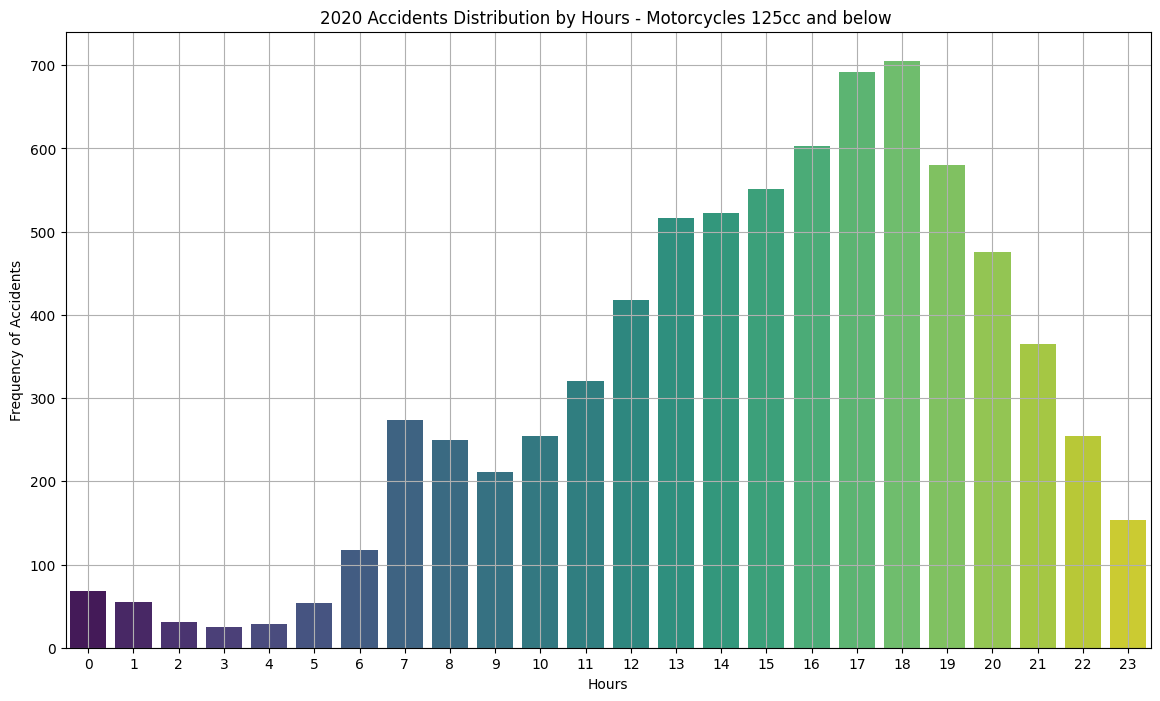

In [168]:
# Set figure size
plt.figure(figsize=(14, 8))

# Plot a bar chart using hours
sns.barplot(data=MU125cc_hour_data, x='hours', y='freq', palette='viridis')

# Set labels and title
plt.xlabel('Hours')
plt.ylabel('Frequency of Accidents')
plt.title('2020 Accidents Distribution by Hours - Motorcycles 125cc and below ')

# Enable grid lines
plt.grid(True)

# Ensure x-ticks cover all 24 hours
plt.xticks(range(0, 24))

# Save the plot as an image
plt.savefig("3.MU125cc_under.png")

# Display the plot
plt.show()


**Time - Motorcycle over 125cc and up to 500cc**

In [175]:
# Connect to Database
con = sqlite3.connect("accident_data_v1.0.0_2023.db")
cur = con.cursor()

 
cur.execute("""
    SELECT SUBSTR(time, 1, 2) AS hours
    FROM accident
        JOIN vehicle ON vehicle.accident_index = accident.accident_index
    WHERE accident.accident_year = 2020 AND vehicle_type = 4
""")

# Fetch results
MU500cc_results = cur.fetchall() 

# Convert to DataFrame
MU500cc = pd.DataFrame(MU500cc_results, columns=['hours'])

# Convert hour values to integers for numerical operations
MU500cc['hours'] = MU500cc['hours'].astype(int)

# Close database connection
con.close()

# Display the first few rows
#MU500cc

In [170]:
# Compute frequency of each hour
MU500cc_hour_counts = MU500cc['hours'].value_counts().sort_index()

# Create a DataFrame for plotting
MU500cc_hour_data = pd.DataFrame({'hours': MU500cc_hour_counts.index, 'freq': MU500cc_hour_counts.values})


C:\Users\Hp\AppData\Local\Temp\ipykernel_12556\2590355769.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=MU500cc_hour_data, x='hours', y='freq', palette='viridis')


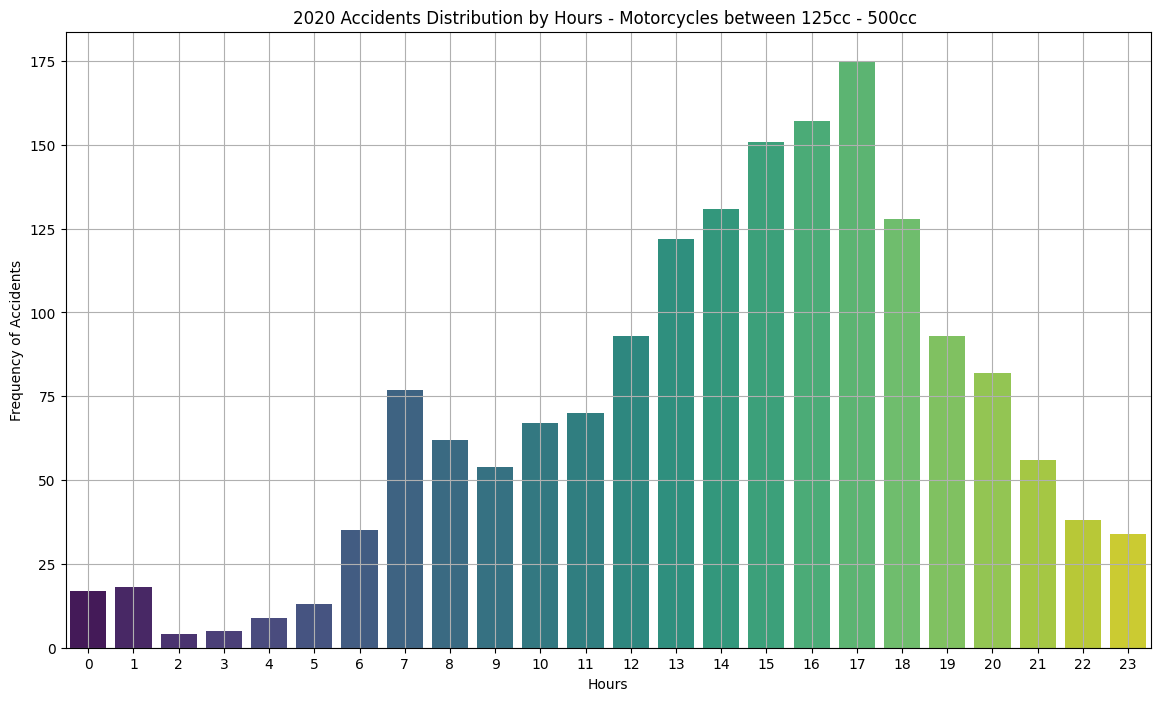

In [171]:
# Set figure size
plt.figure(figsize=(14, 8))

# Plot a bar chart using hours
sns.barplot(data=MU500cc_hour_data, x='hours', y='freq', palette='viridis')

# Set labels and title
plt.xlabel('Hours')
plt.ylabel('Frequency of Accidents')
plt.title('2020 Accidents Distribution by Hours - Motorcycles between 125cc - 500cc ')

# Enable grid lines
plt.grid(True)

# Ensure x-ticks cover all 24 hours
plt.xticks(range(0, 24))

# Save the plot as an image
plt.savefig("4.MU500_under.png")

# Display the plot
plt.show()

**Time - Motorcycle over 500cc**

In [172]:
# Connect to Database
con = sqlite3.connect("accident_data_v1.0.0_2023.db")
cur = con.cursor()

 
cur.execute("""
    SELECT SUBSTR(time, 1, 2) AS hours
    FROM accident
        JOIN vehicle ON vehicle.accident_index = accident.accident_index
    WHERE accident.accident_year = 2020 AND vehicle_type = 5
""")

# Fetch results
MO500cc_results = cur.fetchall() 

# Convert to DataFrame
MO500cc = pd.DataFrame(MO500cc_results, columns=['hours'])

# Convert hour values to integers for numerical operations
MO500cc['hours'] = MO500cc['hours'].astype(int)

# Close database connection
con.close()

# Display the first few rows
#MO500cc

In [173]:
# Compute frequency of each hour
MO500cc_hour_counts = MO500cc['hours'].value_counts().sort_index()

# Create a DataFrame for plotting
MO500cc_hour_data = pd.DataFrame({'hours': MO500cc_hour_counts.index, 'freq': MO500cc_hour_counts.values})

C:\Users\Hp\AppData\Local\Temp\ipykernel_12556\921755787.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=MO500cc_hour_data, x='hours', y='freq', palette='viridis')


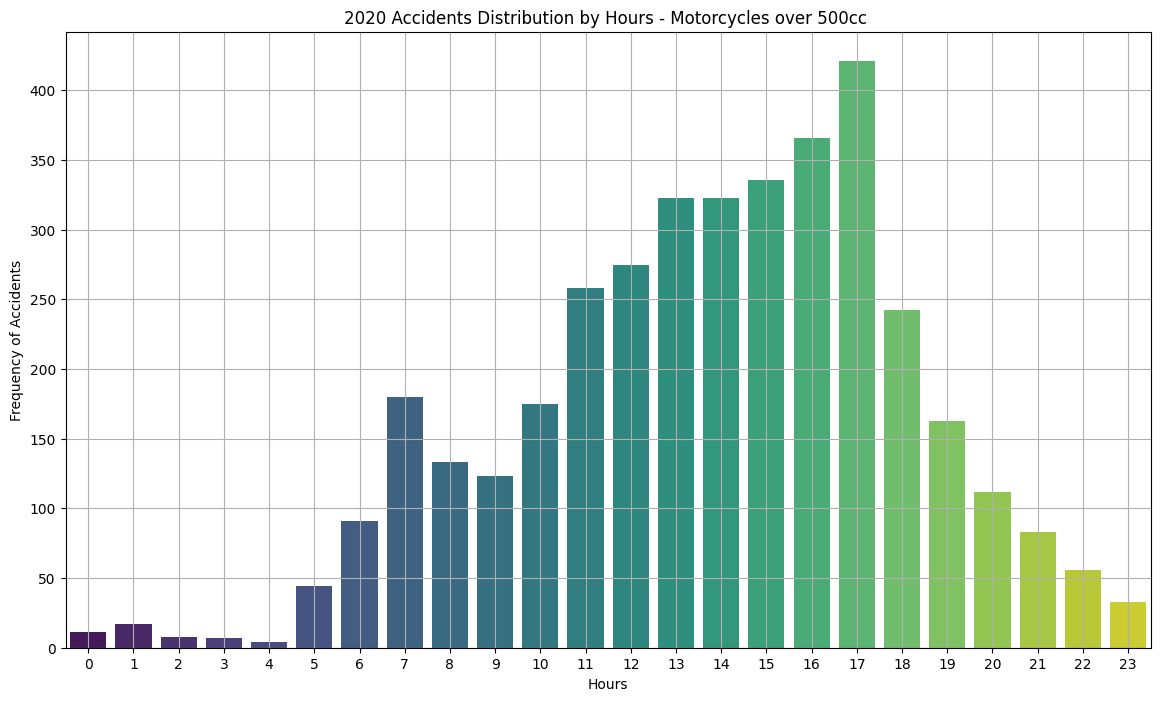

In [188]:
# Set figure size
plt.figure(figsize=(14, 8))

# Plot a bar chart using hours
sns.barplot(data=MO500cc_hour_data, x='hours', y='freq', palette='viridis')

# Set labels and title
plt.xlabel('Hours')
plt.ylabel('Frequency of Accidents')
plt.title('2020 Accidents Distribution by Hours - Motorcycles over 500cc ')

# Enable grid lines
plt.grid(True)

# Ensure x-ticks cover all 24 hours
plt.xticks(range(0, 24))

# Save the plot as an image
plt.savefig("5.MU500_over.png")

# Display the plot
plt.show()

**Days - Motorcycle 125cc and under**

In [183]:
# Connect to Database
con = sqlite3.connect("accident_data_v1.0.0_2023.db")
cur = con.cursor()

 
cur.execute("""
    SELECT day_of_week AS days
    FROM accident
        JOIN vehicle ON vehicle.accident_index = accident.accident_index
    WHERE accident.accident_year = 2020 AND vehicle_type = 3
""")

# Fetch results
days_MU125cc_results = cur.fetchall() 

# Convert to DataFrame
days_MU125cc = pd.DataFrame(days_MU125cc_results, columns=['days'])

# Convert hour values to integers for numerical operations
days_MU125cc['days'] = days_MU125cc['days'].astype(int)

# Close database connection
con.close()

# Display the first few rows
#days_MU125cc

In [184]:
# Define mapping
days = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 
        5: 'Thursday', 6: 'Friday', 7: 'Saturday'}

# Compute day counts without modifying the original DataFrame
MU125cc_day_counts = days_MU125cc['days'].map(days).value_counts().reindex(days.values())


C:\Users\Hp\AppData\Local\Temp\ipykernel_12556\3154278756.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=MU125cc_day_counts.index, y=MU125cc_day_counts.values, palette='viridis')


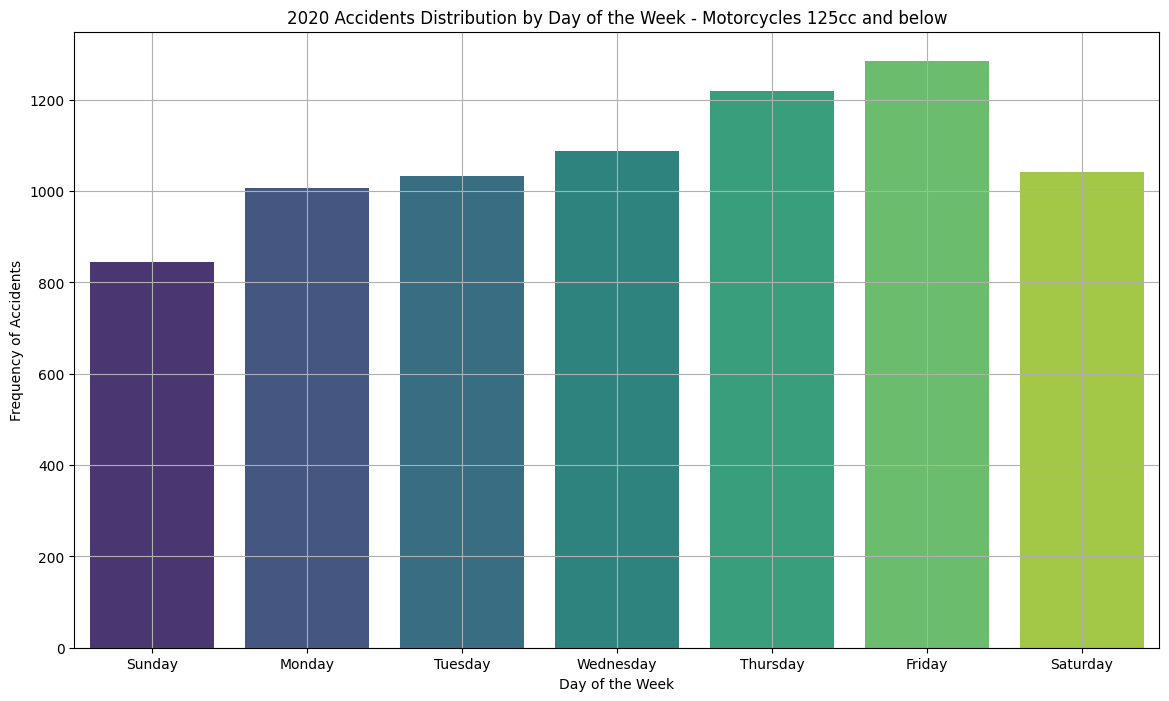

In [185]:
# Plot the bar graph
plt.figure(figsize=(14, 8))

sns.barplot(x=MU125cc_day_counts.index, y=MU125cc_day_counts.values, palette='viridis')

plt.xlabel('Day of the Week')
plt.ylabel('Frequency of Accidents')
plt.title('2020 Accidents Distribution by Day of the Week - Motorcycles 125cc and below')

plt.grid(True)
plt.savefig("6.MU1255cc_days.png")  # Save the plot as an image
plt.show()

**Days - Motorcycle over 125cc and up to 500cc**

In [189]:
# Connect to Database
con = sqlite3.connect("accident_data_v1.0.0_2023.db")
cur = con.cursor()

 
cur.execute("""
    SELECT day_of_week AS days
    FROM accident
        JOIN vehicle ON vehicle.accident_index = accident.accident_index
    WHERE accident.accident_year = 2020 AND vehicle_type = 4
""")

# Fetch results
days_MU500cc_results = cur.fetchall() 

# Convert to DataFrame
days_MU500cc = pd.DataFrame(days_MU500cc_results, columns=['days'])

# Convert hour values to integers for numerical operations
days_MU500cc['days'] = days_MU500cc['days'].astype(int)

# Close database connection
con.close()

# Display the first few rows
#days_MU500cc

In [190]:
# Define mapping
days = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 
        5: 'Thursday', 6: 'Friday', 7: 'Saturday'}

# Compute day counts without modifying the original DataFrame
MU500cc_day_counts = days_MU500cc['days'].map(days).value_counts().reindex(days.values())

C:\Users\Hp\AppData\Local\Temp\ipykernel_12556\327225132.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=MU500cc_day_counts.index, y=MU500cc_day_counts.values, palette='viridis')


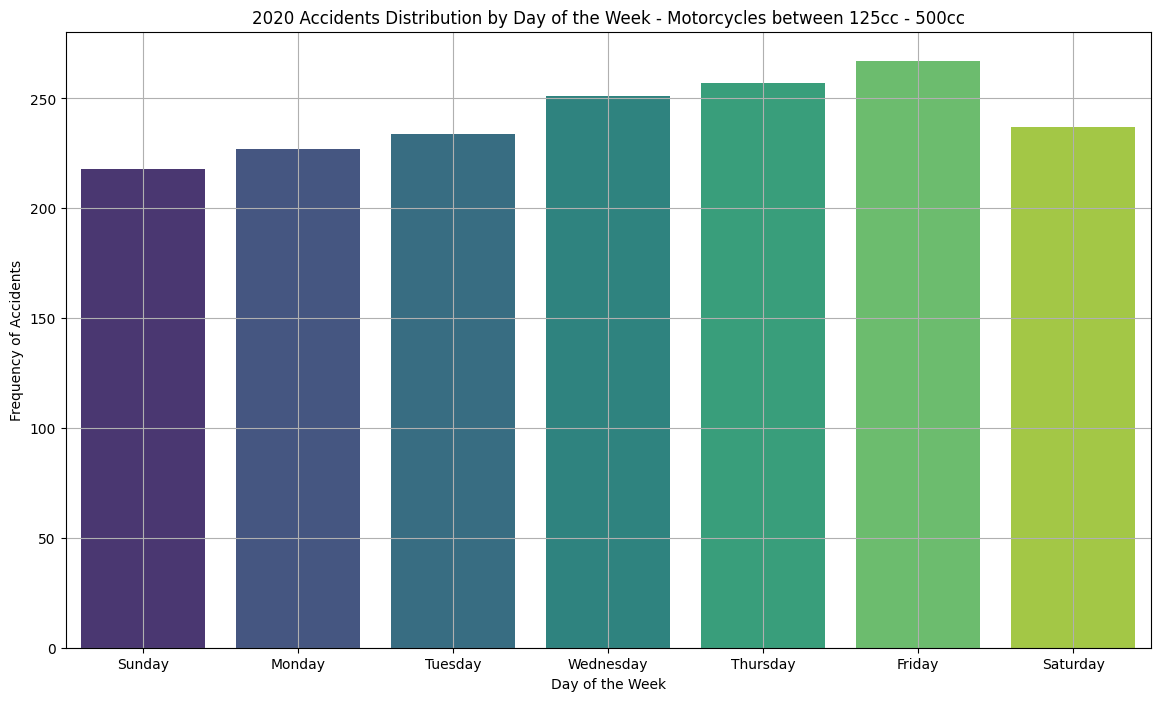

In [191]:
# Plot the bar graph
plt.figure(figsize=(14, 8))

sns.barplot(x=MU500cc_day_counts.index, y=MU500cc_day_counts.values, palette='viridis')

plt.xlabel('Day of the Week')
plt.ylabel('Frequency of Accidents')
plt.title('2020 Accidents Distribution by Day of the Week - Motorcycles between 125cc - 500cc')

plt.grid(True)
plt.savefig("7.MU500cc_days.png")  # Save the plot as an image
plt.show()

**Days - Motorcycle over 500cc**

In [192]:
# Connect to Database
con = sqlite3.connect("accident_data_v1.0.0_2023.db")
cur = con.cursor()

 
cur.execute("""
    SELECT day_of_week AS days
    FROM accident
        JOIN vehicle ON vehicle.accident_index = accident.accident_index
    WHERE accident.accident_year = 2020 AND vehicle_type = 5
""")

# Fetch results
days_MO500cc_results = cur.fetchall() 

# Convert to DataFrame
days_MO500cc = pd.DataFrame(days_MO500cc_results, columns=['days'])

# Convert hour values to integers for numerical operations
days_MO500cc['days'] = days_MO500cc['days'].astype(int)

# Close database connection
con.close()

# Display the first few rows
#days_MO500cc

In [193]:
# Define mapping
days = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 
        5: 'Thursday', 6: 'Friday', 7: 'Saturday'}

# Compute day counts without modifying the original DataFrame
MO500cc_day_counts = days_MO500cc['days'].map(days).value_counts().reindex(days.values())

C:\Users\Hp\AppData\Local\Temp\ipykernel_12556\2234117990.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=MO500cc_day_counts.index, y=MO500cc_day_counts.values, palette='viridis')


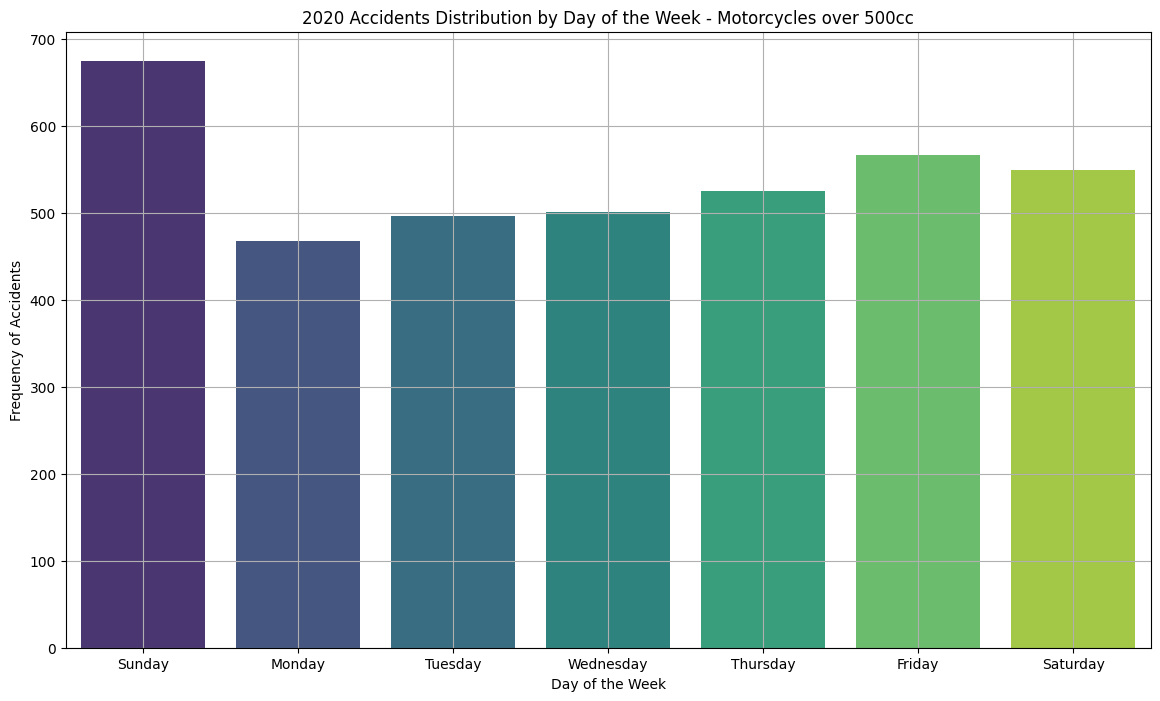

In [194]:
# Plot the bar graph
plt.figure(figsize=(14, 8))

sns.barplot(x=MO500cc_day_counts.index, y=MO500cc_day_counts.values, palette='viridis')

plt.xlabel('Day of the Week')
plt.ylabel('Frequency of Accidents')
plt.title('2020 Accidents Distribution by Day of the Week - Motorcycles over 500cc')

plt.grid(True)
plt.savefig("8.MO500cc_days.png")  # Save the plot as an image
plt.show()

### 3. For pedestrians involved in accidents, are there significant hours of the day, and days of the week, on which they are more likely to be involved?

In [195]:
ac_df.head()

accident_index  accident_year accident_reference  location_easting_osgr  \
0  2020010219808           2020          010219808               521389.0   
1  2020010220496           2020          010220496               529337.0   
2  2020010228005           2020          010228005               526432.0   
3  2020010228006           2020          010228006               538676.0   
4  2020010228011           2020          010228011               529324.0   

   location_northing_osgr  longitude   latitude  police_force  \
0                175144.0  -0.254001  51.462262             1   
1                176237.0  -0.139253  51.470327             1   
2                182761.0  -0.178719  51.529614             1   
3                184371.0  -0.001683  51.541210             1   
4                181286.0  -0.137592  51.515704             1   

   accident_severity  number_of_vehicles  number_of_casualties        date  \
0                  3                   1                     1  04/02/2020   
1                  3                   1                     2  27/04/2020   
2                  3                   1                     1  01/01/2020   
3                  2                   1                     1  01/01/2020   
4                  3                   1                     2  01/01/2020   

   day_of_week   time  local_authority_district local_authority_ons_district  \
0            3  09:00                        10                    E09000032   
1            2  13:55                         9                    E09000022   
2            4  01:25                         1                    E09000033   
3            4  01:50                        17                    E09000025   
4            4  02:25                         1                    E09000033   

  local_authority_highway  first_road_class  first_road_number  road_type  \
0               E09000032                 6                  0          6   
1               E09000022                 3               3036          6   
2               E09000033                 5                  0          6   
3               E09000025                 3                 11          6   
4               E09000033                 3                 40          6   

   speed_limit  junction_detail  junction_control  second_road_class  \
0           20                0                -1                  0   
1           20                9                 2                  6   
2           30                3                 1                  6   
3           30                0                -1                  0   
4           30                3                 4                  5   

   second_road_number  pedestrian_crossing_human_control  \
0                  -1                                  9   
1                   0                                  0   
2                   0                                  0   
3                  -1                                  0   
4                   0                                  0   

   pedestrian_crossing_physical_facilities  light_conditions  \
0                                        9                 1   
1                                        4                 1   
2                                        0                 4   
3                                        4                 4   
4                                        0                 4   

   weather_conditions  road_surface_conditions  special_conditions_at_site  \
0                   9                        9                           0   
1                   1                        1                           0   
2                   1                        2                           0   
3                   1                        1                           0   
4                   1                        1                           0   

   carriageway_hazards  urban_or_rural_area  \
0                    0                  

In [196]:
ca_df.head()

casualty_index accident_index  accident_year accident_reference  \
0          484748  2020010219808           2020          010219808   
1          484749  2020010220496           2020          010220496   
2          484750  2020010220496           2020          010220496   
3          484751  2020010228005           2020          010228005   
4          484752  2020010228006           2020          010228006   

   vehicle_reference  casualty_reference  casualty_class  sex_of_casualty  \
0                  1                   1               3                1   
1                  1                   1               3                2   
2                  1                   2               3                2   
3                  1                   1               3                1   
4                  1                   1               3                1   

   age_of_casualty  age_band_of_casualty  casualty_severity  \
0               31                     6                  3   
1                2                     1                  3   
2                4                     1                  3   
3               23                     5                  3   
4               47                     8                  2   

   pedestrian_location  pedestrian_movement  car_passenger  \
0                    9                    5              0   
1                    1                    1              0   
2                    1                    1              0   
3                    5                    9              0   
4                    4                    1              0   

   bus_or_coach_passenger  pedestrian_road_maintenance_worker  casualty_type  \
0                       0                                   0              0   
1                       0                                   0              0   
2                       0                                   0              0   
3                       0                                   0              0   
4                       0                                   0              0   

   casualty_home_area_type  casualty_imd_decile  
0                        1                    4  
1                        1                    2  
2                        1                    2  
3                        1                    3  
4                        1                    3

**Time - Pedestrians**

In [204]:
# Connect to Database
con = sqlite3.connect("accident_data_v1.0.0_2023.db")
cur = con.cursor()

 
cur.execute("""
    SELECT SUBSTR(time, 1, 2) AS hours
    FROM accident
        JOIN casualty ON casualty.accident_index = accident.accident_index
    WHERE accident.accident_year = 2020 AND casualty_class = 3
""")

# Fetch results
pes_results = cur.fetchall() 

# Convert to DataFrame
pedes = pd.DataFrame(pes_results, columns=['hours'])

# Convert hour values to integers for numerical operations
pedes['hours'] = pedes['hours'].astype(int)

# Close database connection
con.close()

# Display the first few rows
pedes

hours
0          9
1         13
2         13
3          1
4          1
...      ...
14745     10
14746     17
14747     12
14748     15
14749     13

[14750 rows x 1 columns]

In [205]:
# Compute frequency of each hour
pes_hour_counts = pedes['hours'].value_counts().sort_index()

# Create a DataFrame for plotting
pes_hour_data = pd.DataFrame({'hours': hour_counts.index, 'freq': hour_counts.values})


C:\Users\Hp\AppData\Local\Temp\ipykernel_12556\1281001954.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = pes_hour_data, x='hours', y='freq', palette='viridis')


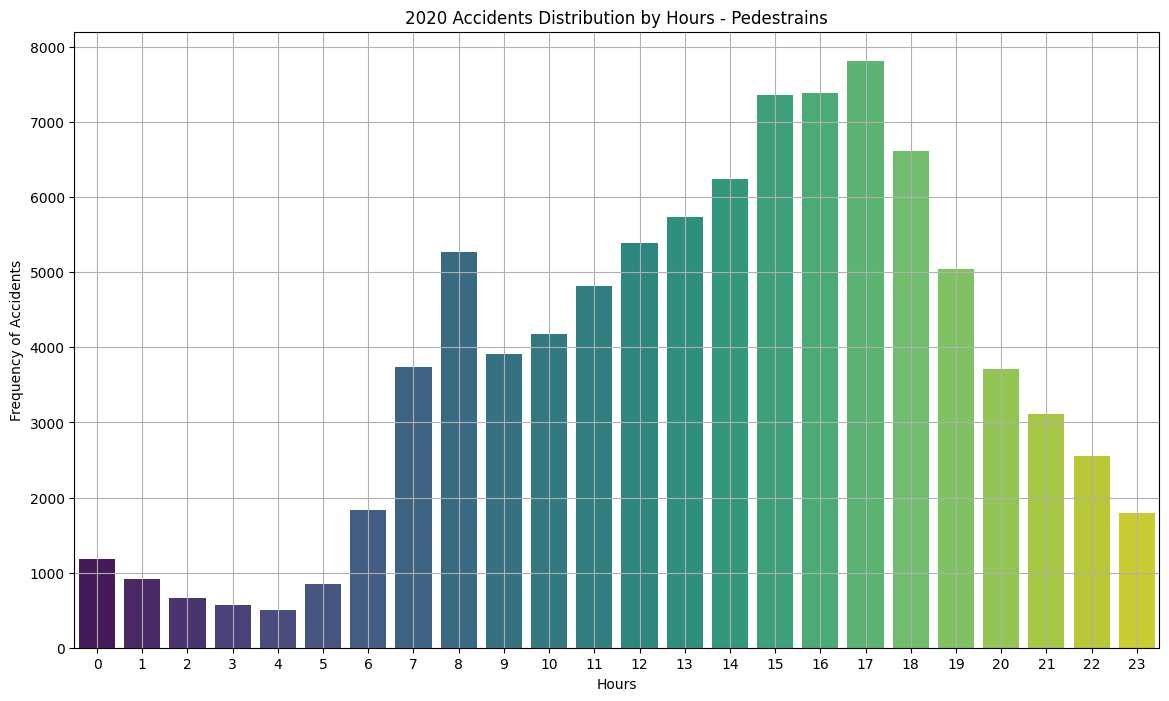

In [206]:
# Set figure size
plt.figure(figsize=(14, 8))

# Plot a bar chart using hours
sns.barplot(data = pes_hour_data, x='hours', y='freq', palette='viridis')

# Set labels and title
plt.xlabel('Hours')
plt.ylabel('Frequency of Accidents')
plt.title('2020 Accidents Distribution by Hours - Pedestrains')

# Enable grid lines
plt.grid(True)

# Ensure x-ticks cover all 24 hours
plt.xticks(range(0, 24))

# Save the plot as an image
plt.savefig("9.ac_hours.png")

# Display the plot
plt.show()


**Day - Pedestrians**

In [209]:
# Connect to Database
con = sqlite3.connect("accident_data_v1.0.0_2023.db")
cur = con.cursor()

 
cur.execute("""
    SELECT day_of_week AS days
    FROM accident
        JOIN casualty ON casualty.accident_index = accident.accident_index
    WHERE accident.accident_year = 2020 AND casualty_class = 3
""")

# Fetch results
day_pes_results = cur.fetchall() 

# Convert to DataFrame
day_pedes = pd.DataFrame(day_pes_results, columns=['days'])

# Convert hour values to integers for numerical operations
day_pedes['days'] = day_pedes['days'].astype(int)

# Close database connection
con.close()

# Display the first few rows
day_pedes

days
0         3
1         2
2         2
3         4
4         4
...     ...
14745     3
14746     2
14747     3
14748     6
14749     3

[14750 rows x 1 columns]

In [210]:
# Define mapping
days = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 
        5: 'Thursday', 6: 'Friday', 7: 'Saturday'}

# Compute day counts without modifying the original DataFrame
day_pedes_counts = day_pedes['days'].map(days).value_counts().reindex(days.values())


C:\Users\Hp\AppData\Local\Temp\ipykernel_12556\2085985719.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = day_pedes_counts.index, y = day_pedes_counts.values, palette='viridis')


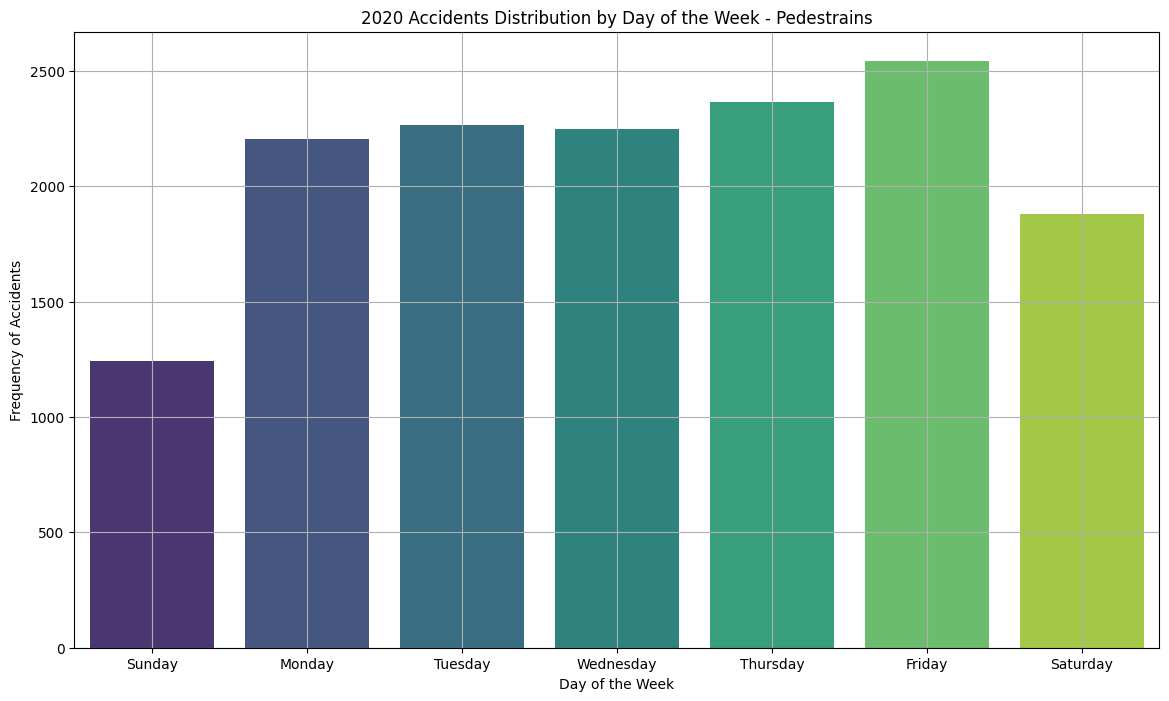

In [211]:
# Plot the bar graph
plt.figure(figsize=(14, 8))

sns.barplot(x = day_pedes_counts.index, y = day_pedes_counts.values, palette='viridis')

plt.xlabel('Day of the Week')
plt.ylabel('Frequency of Accidents')
plt.title('2020 Accidents Distribution by Day of the Week - Pedestrains')

plt.grid(True)
plt.savefig("10.acc_days.png")  # Save the plot as an image
plt.show()

### 4. Using the apriori algorithm, explore the impact of selected variables on accident severity.

In [212]:
ac_df.head()

accident_index  accident_year accident_reference  location_easting_osgr  \
0  2020010219808           2020          010219808               521389.0   
1  2020010220496           2020          010220496               529337.0   
2  2020010228005           2020          010228005               526432.0   
3  2020010228006           2020          010228006               538676.0   
4  2020010228011           2020          010228011               529324.0   

   location_northing_osgr  longitude   latitude  police_force  \
0                175144.0  -0.254001  51.462262             1   
1                176237.0  -0.139253  51.470327             1   
2                182761.0  -0.178719  51.529614             1   
3                184371.0  -0.001683  51.541210             1   
4                181286.0  -0.137592  51.515704             1   

   accident_severity  number_of_vehicles  number_of_casualties        date  \
0                  3                   1                     1  04/02/2020   
1                  3                   1                     2  27/04/2020   
2                  3                   1                     1  01/01/2020   
3                  2                   1                     1  01/01/2020   
4                  3                   1                     2  01/01/2020   

   day_of_week   time  local_authority_district local_authority_ons_district  \
0            3  09:00                        10                    E09000032   
1            2  13:55                         9                    E09000022   
2            4  01:25                         1                    E09000033   
3            4  01:50                        17                    E09000025   
4            4  02:25                         1                    E09000033   

  local_authority_highway  first_road_class  first_road_number  road_type  \
0               E09000032                 6                  0          6   
1               E09000022                 3               3036          6   
2               E09000033                 5                  0          6   
3               E09000025                 3                 11          6   
4               E09000033                 3                 40          6   

   speed_limit  junction_detail  junction_control  second_road_class  \
0           20                0                -1                  0   
1           20                9                 2                  6   
2           30                3                 1                  6   
3           30                0                -1                  0   
4           30                3                 4                  5   

   second_road_number  pedestrian_crossing_human_control  \
0                  -1                                  9   
1                   0                                  0   
2                   0                                  0   
3                  -1                                  0   
4                   0                                  0   

   pedestrian_crossing_physical_facilities  light_conditions  \
0                                        9                 1   
1                                        4                 1   
2                                        0                 4   
3                                        4                 4   
4                                        0                 4   

   weather_conditions  road_surface_conditions  special_conditions_at_site  \
0                   9                        9                           0   
1                   1                        1                           0   
2                   1                        2                           0   
3                   1                        1                           0   
4                   1                        1                           0   

   carriageway_hazards  urban_or_rural_area  \
0                    0                  

In [280]:
ca_df.head()

casualty_index accident_index  accident_year accident_reference  \
0          484748  2020010219808           2020          010219808   
1          484749  2020010220496           2020          010220496   
2          484750  2020010220496           2020          010220496   
3          484751  2020010228005           2020          010228005   
4          484752  2020010228006           2020          010228006   

   vehicle_reference  casualty_reference  casualty_class  sex_of_casualty  \
0                  1                   1               3                1   
1                  1                   1               3                2   
2                  1                   2               3                2   
3                  1                   1               3                1   
4                  1                   1               3                1   

   age_of_casualty  age_band_of_casualty  casualty_severity  \
0               31                     6                  3   
1                2                     1                  3   
2                4                     1                  3   
3               23                     5                  3   
4               47                     8                  2   

   pedestrian_location  pedestrian_movement  car_passenger  \
0                    9                    5              0   
1                    1                    1              0   
2                    1                    1              0   
3                    5                    9              0   
4                    4                    1              0   

   bus_or_coach_passenger  pedestrian_road_maintenance_worker  casualty_type  \
0                       0                                   0              0   
1                       0                                   0              0   
2                       0                                   0              0   
3                       0                                   0              0   
4                       0                                   0              0   

   casualty_home_area_type  casualty_imd_decile  
0                        1                    4  
1                        1                    2  
2                        1                    2  
3                        1                    3  
4                        1                    3

In [281]:
ve_df.head()

vehicle_index accident_index  accident_year accident_reference  \
0         681716  2020010219808           2020          010219808   
1         681717  2020010220496           2020          010220496   
2         681718  2020010228005           2020          010228005   
3         681719  2020010228006           2020          010228006   
4         681720  2020010228011           2020          010228011   

   vehicle_reference  vehicle_type  towing_and_articulation  \
0                  1             9                        9   
1                  1             9                        0   
2                  1             9                        0   
3                  1             8                        0   
4                  1             9                        0   

   vehicle_manoeuvre  vehicle_direction_from  vehicle_direction_to  \
0                  5                       1                     5   
1                  4                       2                     6   
2                 18                      -1                    -1   
3                 18                       1                     5   
4                 18                       3                     7   

   vehicle_location_restricted_lane  junction_location  \
0                                 0                  0   
1                                 0                  2   
2                                 0                  0   
3                                 0                  0   
4                                 9                  1   

   skidding_and_overturning  hit_object_in_carriageway  \
0                         0                          0   
1                         0                          0   
2                         0                          0   
3                         0                          0   
4                         0                          0   

   vehicle_leaving_carriageway  hit_object_off_carriageway  \
0                            0                           0   
1                            0                           0   
2                            0                           0   
3                            0                           0   
4                            0                           0   

   first_point_of_impact  vehicle_left_hand_drive  journey_purpose_of_driver  \
0                      4                        9                          6   
1                      1                        1                          2   
2                      1                        1                          6   
3                      1                        1                          1   
4                      1                        1                          6   

   sex_of_driver  age_of_driver  age_band_of_driver  engine_capacity_cc  \
0              2             32                   6                1968   
1              1             45                   7                1395   
2              3             -1                  -1                  -1   
3              1             44                   7                1798   
4              1             20                   4                2993   

   propulsion_code  age_of_vehicle generic_make_model  driver_imd_decile  \
0                2               6            AUDI Q5                  4   
1                1               2            AUDI A1                  7   
2               -1              -1                 -1                 -1   
3                8               8       TOYOTA PRIUS                  2   
4                2               4       BMW 4 SERIES                 -1   

   driver_home_area_type  
0                      1  
1                      1  
2                     -1  
3                      1  
4                     -1

In [283]:
# Connect to Database
con = sqlite3.connect("accident_data_v1.0.0_2023.db")
cur = con.cursor()

 
cur.execute("""
    SELECT accident_severity,speed_limit,road_type,weather_conditions,road_surface_conditions,light_conditions,pedestrian_crossing_physical_facilities,pedestrian_crossing_human_control,
        vehicle_type,sex_of_driver,age_of_vehicle
    FROM accident
        JOIN vehicle ON vehicle.accident_index = accident.accident_index
    WHERE accident.accident_year = 2020
""")

# Fetch results
APM_results = cur.fetchall() 

# Convert to DataFrame
headers=[description[0] for description in cur.description]

APM_df = pd.DataFrame(APM_results, columns=headers)

# Close database connection
con.close()

# Display the first few rows
APM_df.head()

accident_severity  speed_limit  road_type  weather_conditions  \
0                  3           20          6                   9   
1                  3           20          6                   1   
2                  3           30          6                   1   
3                  2           30          6                   1   
4                  3           30          6                   1   

   road_surface_conditions  light_conditions  \
0                        9                 1   
1                        1                 1   
2                        2                 4   
3                        1                 4   
4                        1                 4   

   pedestrian_crossing_physical_facilities  pedestrian_crossing_human_control  \
0                                        9                                  9   
1                                        4                                  0   
2                                        0                                  0   
3                                        4                                  0   
4                                        0                                  0   

   vehicle_type  sex_of_driver  age_of_vehicle  
0             9              2               6  
1             9              1               2  
2             9              3              -1  
3             8              1               8  
4             9              1               4

In [216]:
APM_df["accident_severity"].unique()

array([3, 2, 1], dtype=int64)

In [217]:
APM_df["speed_limit"].unique()

array([20, 30, 40, 50, 60, 70, -1], dtype=int64)

In [223]:
APM_df["road_type"].unique()

array([6, 2, 3, 7, 1, 9], dtype=int64)

In [218]:
APM_df["weather_conditions"].unique()

array([ 9,  1,  8,  7,  2,  4,  5,  3,  6, -1], dtype=int64)

In [219]:
APM_df["road_surface_conditions"].unique()

array([ 9,  1,  2,  5,  4,  3, -1], dtype=int64)

In [220]:
APM_df["light_conditions"].unique()

array([ 1,  4,  5,  7,  6, -1], dtype=int64)

In [221]:
APM_df["pedestrian_crossing_physical_facilities"].unique()

array([ 9,  4,  0,  5,  1,  8,  7, -1], dtype=int64)

In [222]:
APM_df["pedestrian_crossing_human_control"].unique()

array([ 9,  0,  2,  1, -1], dtype=int64)

In [285]:
APM_df["vehicle_type"].unique()

array([ 9,  8,  3,  2, 11,  1, 90, 19,  4,  5, 21, 97, 20, 98, 10, 17, 23,
       22, 18, 16], dtype=int64)

In [286]:
APM_df["sex_of_driver"].unique()

array([ 2,  1,  3, -1], dtype=int64)

In [287]:
APM_df["age_of_vehicle"].unique()

array([ 6,  2, -1,  8,  4,  5,  0,  1, 14,  9, 16, 20, 12, 10, 13, 18,  7,
        3, 19, 22, 15, 11, 17, 28, 21, 32, 24, 25, 23, 27, 30, 26, 29, 31,
       34, 37, 44, 39, 57, 38, 51, 54, 33, 62, 46, 43, 41, 48, 45, 36, 58,
       60, 64, 86, 50, 61, 53, 35, 55, 49, 92, 88, 42, 67, 84, 40, 52, 66,
       56, 78, 47, 96, 68, 63, 93], dtype=int64)

#### Create One-hot encoding for variables 

This is help extract individual components from variables

In [339]:
severity=pd.get_dummies(APM_df.accident_severity, prefix="severity").astype(int)
#severity

In [340]:
speed=pd.get_dummies(APM_df.speed_limit, prefix="speed_limit").astype(int)
#speed

In [341]:
road=pd.get_dummies(APM_df.road_type, prefix="road_type").astype(int)
#road

In [342]:
weather=pd.get_dummies(APM_df.weather_conditions, prefix="weather_conditions").astype(int)
#weather

In [343]:
road_surface=pd.get_dummies(APM_df.road_surface_conditions, prefix="road_surface_conditions").astype(int)
#road_surface

In [344]:
light_conditions=pd.get_dummies(APM_df.light_conditions, prefix="light_conditions").astype(int)
#light_conditions

In [345]:
pedestrian_facilities=pd.get_dummies(APM_df.pedestrian_crossing_physical_facilities, prefix="pedestrian_crossing_physical_facilities").astype(int)
#pedestrian_facilities

In [346]:
road_surface=pd.get_dummies(APM_df.road_surface_conditions, prefix="road_surface_conditions").astype(int)
#road_surface

**Concatenate data**

In [347]:
concat_df=pd.concat([severity,speed,road,weather,road_surface,light_conditions,pedestrian_facilities],axis=1)
concat_df

severity_1  severity_2  severity_3  speed_limit_-1  speed_limit_20  \
0                0           0           1               0               1   
1                0           0           1               0               1   
2                0           0           1               0               0   
3                0           1           0               0               0   
4                0           0           1               0               0   
...            ...         ...         ...             ...             ...   
167370           0           1           0               0               0   
167371           0           1           0               0               0   
167372           0           0           1               0               0   
167373           0           0           1               0               0   
167374           0           0           1               0               0   

        speed_limit_30  speed_limit_40  speed_limit_50  speed_limit_60  \
0                    0               0               0               0   
1                    0               0               0               0   
2                    1               0               0               0   
3                    1               0               0               0   
4                    1               0               0               0   
...                ...             ...             ...             ...   
167370               0               0               0               1   
167371               0               0               0               1   
167372               1               0               0               0   
167373               1               0               0               0   
167374               1               0               0               0   

        speed_limit_70  road_type_1  road_type_2  road_type_3  road_type_6  \
0                    0            0            0            0            1   
1                    0            0            0            0            1   
2                    0            0            0            0            1   
3                    0            0            0            0            1   
4                    0            0            0            0            1   
...                ...          ...          ...          ...          ...   
167370               0            0            0            0            1   
167371               0            0            0            0            1   
167372               0            0            0            0            1   
167373               0            0            0            0            1   
167374               0            0            0            0            1   

        road_type_7  road_type_9  weather_conditions_-1  weather_conditions_1  \
0                 0            0                      0                     0   
1                 0            0                      0                     1   
2                 0            0                      0                     1   
3                 0            0                      0                     1   
4                 0            0                      0                     1   
...             ...          ...                    ...                   ...   
167370            0            0                      0                     1   
167371            0            0                      0                     1   
167372            0            0                      0                     1   
167373            0            0                      0                     1   
167374            0            0                      0                     1   

        weather_conditions_2  weather_conditions_3  weather_conditions_4  \
0                          0                     0                     0   
1                          0                     0                     0   
2                          0                

In [350]:
 # Set apriori and view support
freq_items_set=apriori(concat_df, min_support= 0.5 , use_colnames=True)
#freq_items_set

C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [351]:
 # Check association rules
rules= association_rules(freq_items_set, metric="lift",min_threshold=1.2)
rules

antecedents  \
0                             (weather_conditions_1)   
1                        (road_surface_conditions_1)   
2                 (weather_conditions_1, severity_3)   
3                        (road_surface_conditions_1)   
4         (weather_conditions_1, light_conditions_1)   
5    (light_conditions_1, road_surface_conditions_1)   
6                             (weather_conditions_1)   
7                        (road_surface_conditions_1)   
8  (pedestrian_crossing_physical_facilities_0, ro...   
9                             (weather_conditions_1)   

                                         consequents  antecedent support  \
0                        (road_surface_conditions_1)            0.783080   
1                             (weather_conditions_1)            0.695618   
2                        (road_surface_conditions_1)            0.618605   
3                 (weather_conditions_1, severity_3)            0.695618   
4                        (road_surface_conditions_1)            0.590046   
5                             (weather_conditions_1)            0.545153   
6    (light_conditions_1, road_surface_conditions_1)            0.783080   
7         (weather_conditions_1, light_conditions_1)            0.695618   
8                             (weather_conditions_1)            0.532075   
9  (pedestrian_crossing_physical_facilities_0, ro...            0.783080   

   consequent support   support  confidence      lift  representativity  \
0            0.695618  0.654142    0.835345  1.200868               1.0   
1            0.783080  0.654142    0.940376  1.200868               1.0   
2            0.695618  0.517999    0.837366  1.203773               1.0   
3            0.618605  0.517999    0.744660  1.203773               1.0   
4            0.695618  0.515507    0.873672  1.255966               1.0   
5            0.783080  0.515507    0.945619  1.207564               1.0   
6            0.545153  0.515507    0.658307  1.207564               1.0   
7            0.590046  0.515507    0.741078  1.255966               1.0   
8            0.783080  0.503414    0.946135  1.208223               1.0   
9            0.532075  0.503414    0.642865  1.208223               1.0   

   leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski  
0  0.109418    1.848607       0.771109  0.793327   0.459052    0.887860  
1  0.109418    3.638114       0.549536  0.793327   0.725132    0.887860  
2  0.087686    1.871575       0.443840  0.650569   0.465691    0.791013  
3  0.087686    1.493674       0.556138  0.650569   0.330510    0.791013  
4  0.105060    2.409466       0.497130  0.669353   0.584970    0.807375  
5  0.088609    3.988890       0.377899  0.634294   0.749304    0.801963  
6  0.088609    1.331157       0.792395  0.634294   0.248774    0.801963  
7  0.105060    1.583311       0.669553  0.669353   0.368412    0.807375  
8  0.086757    4.027108       0.368303  0.620167   0.751683    0.794500  
9  0.086757    1.310219       0.794477  0.620167   0.236769    0.794500

### 5. Identify accidents in our region:

Kingston upon Hull, Humberside, and the East Riding of Yorkshire etc. You can do this by filtering on LSOA, or police region or another method if you can find one. Run clustering on this data. What do these clusters reveal about the distribution of accidents in our region?

In [24]:
ac_df.head()

accident_index  accident_year accident_reference  location_easting_osgr  \
0  2020010219808           2020          010219808               521389.0   
1  2020010220496           2020          010220496               529337.0   
2  2020010228005           2020          010228005               526432.0   
3  2020010228006           2020          010228006               538676.0   
4  2020010228011           2020          010228011               529324.0   

   location_northing_osgr  longitude   latitude  police_force  \
0                175144.0  -0.254001  51.462262             1   
1                176237.0  -0.139253  51.470327             1   
2                182761.0  -0.178719  51.529614             1   
3                184371.0  -0.001683  51.541210             1   
4                181286.0  -0.137592  51.515704             1   

   accident_severity  number_of_vehicles  ...  \
0                  3                   1  ...   
1                  3                   1  ...   
2                  3                   1  ...   
3                  2                   1  ...   
4                  3                   1  ...   

   pedestrian_crossing_physical_facilities light_conditions  \
0                                        9                1   
1                                        4                1   
2                                        0                4   
3                                        4                4   
4                                        0                4   

   weather_conditions road_surface_conditions  special_conditions_at_site  \
0                   9                       9                           0   
1                   1                       1                           0   
2                   1                       2                           0   
3                   1                       1                           0   
4                   1                       1                           0   

  carriageway_hazards urban_or_rural_area  \
0                   0                   1   
1                   0                   1   
2                   0                   1   
3                   0                   1   
4                   0                   1   

   did_police_officer_attend_scene_of_accident  trunk_road_flag  \
0                                            3                2   
1                                            1                2   
2                                            1                2   
3                                            1                2   
4                                            1                2   

   lsoa_of_accident_location  
0                  E01004576  
1                  E01003034  
2                  E01004726  
3                  E01003617  
4                  E01004763  

[5 rows x 36 columns]

In [25]:
ls_df.head()

objectid   lsoa01cd             lsoa01nm            lsoa01nmw  \
0         1  E01000001  City of London 001A  City of London 001A   
1         2  E01000002  City of London 001B  City of London 001B   
2         3  E01000003  City of London 001C  City of London 001C   
3         4  E01000004  City of London 001D  City of London 001D   
4         5  E01000005  City of London 001E  City of London 001E   

    shape__area  shape__length                              globalid  
0  1.298652e+05    2635.772001  68cc6127-1008-4fbe-a16c-78fb089a7c43  
1  2.284189e+05    2707.986202  937edbc3-c1bf-4d35-b274-b0a1480a7c09  
2  5.905477e+04    1224.774479  2686dcaf-10b9-4736-92af-4788d4feaa69  
3  2.544551e+06   10718.466240  3c493140-0b3f-4b9a-b358-22011dc5fb89  
4  1.895782e+05    2275.809358  b569093d-788d-41be-816c-d6d7658b2311

In [22]:
# Connect to Database
con = sqlite3.connect("accident_data_v1.0.0_2023.db")
cur = con.cursor()

 
cur.execute("""
    SELECT longitude, 
           latitude,
           lsoa01nm
    FROM accident
        JOIN lsoa ON lsoa.lsoa01cd = accident.lsoa_of_accident_location
    WHERE accident.accident_year = 2020
""")

# Fetch results
lon_results = cur.fetchall() 

# Convert to DataFrame
headers=[description[0] for description in cur.description]

lon_df = pd.DataFrame(lon_results, columns=headers)

# Close database connection
con.close()

# Display the first few rows
#lon_df.head()

In [23]:
lon_df

longitude   latitude          lsoa01nm
0      -0.254001  51.462262   Wandsworth 013D
1      -0.139253  51.470327      Lambeth 012A
2      -0.178719  51.529614  Westminster 003C
3      -0.001683  51.541210       Newham 012B
4      -0.137592  51.515704  Westminster 013B
...          ...        ...               ...
83149  -3.537021  51.953141        Powys 016B
83150  -3.121276  52.650214        Powys 005B
83151  -3.107776  52.770987        Powys 002C
83152  -3.139679  52.082186        Powys 015B
83153  -3.110141  52.232798        Powys 011E

[83154 rows x 3 columns]

In [24]:
lon_df.isnull().sum()

longitude    0
latitude     0
lsoa01nm     0
dtype: int64

**Plot distribution of raw data**

In [38]:
# Compute KDE (Kernel Density Estimate)
x = lon_df['longitude'].values
y = lon_df['latitude'].values
kde = gaussian_kde([x, y])

# Evaluate density on data points
density = kde([x, y])

# Get indices of top density points (hotspots)
top_hotspots_idx = np.argsort(density)[-5:]  # Select top 5 most dense areas

# Extract coordinates and LSOA names of top hotspots
hotspot_coords = lon_df.iloc[top_hotspots_idx][['latitude', 'longitude', 'lsoa01nm']]

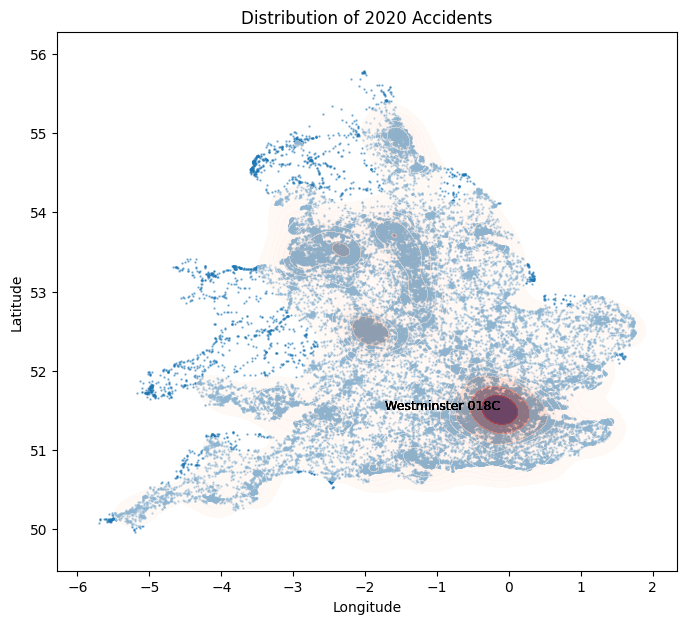

In [39]:
# Create Scatter Plot
plt.figure(figsize=(8, 7))
plt.scatter(lon_df['longitude'], lon_df['latitude'], marker='o', s=0.5, alpha=0.5)

# Add density plot (hotspots)
sns.kdeplot(x=lon_df['longitude'], y=lon_df['latitude'], cmap="Reds", fill=True, alpha=0.5)

# Annotate top hotspots with LSOA names
for idx, row in hotspot_coords.iterrows():
    plt.text(row['longitude'], row['latitude'], row['lsoa01nm'], fontsize=9, color='black', ha='right')

# Add title and labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Distribution of 2020 Accidents')

plt.savefig('11.cluster.png')
plt.show()

**Select features for clustering**

In [56]:
x = lon_df[["longitude","latitude"]]

In [57]:
# Scaling the features
scale=StandardScaler()  

x_scaled=scale.fit_transform(x)

In [58]:
inertia_list=[]

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_scaled)  # Fit the model
    inertia = kmeans.inertia_  # Get the inertia value
    

    inertia_list.append(inertia)
    
# Print the results
for i in inertia_list:
    print(i)


166307.99999999965
82377.29616017573
46739.40127729711
38350.87670586008
31386.759870745314
26517.513820758657
21161.68273038233
19195.016114154503
16945.896912458284
16031.590041296033


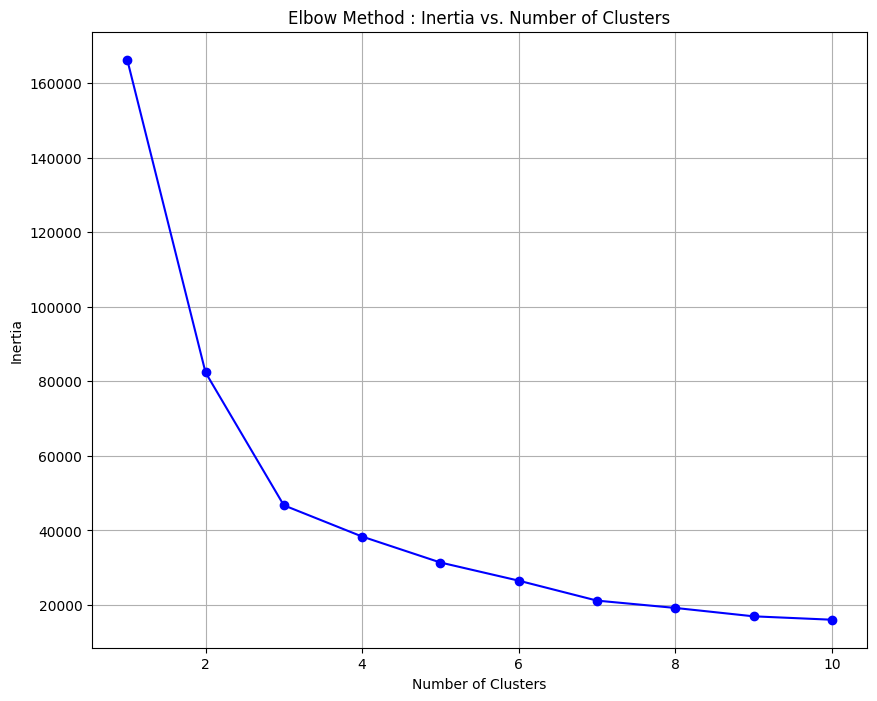

In [59]:

# Plot inertia values vs. number of clusters

plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), inertia_list, marker='o', linestyle='-', color='b')

plt.title('Elbow Method : Inertia vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(range(1,11))
plt.savefig("12.Inertia.png")
plt.show()


**Using k=3**

In [60]:
kmeans = KMeans(n_clusters=3,random_state=42)

#Fit the KMeans model to the scaled data
kmeans.fit(x_scaled)
# Calculate inertia
inertia=kmeans.inertia_
print(inertia)

46739.40127729711


In [61]:
# Get the predicted labels (cluster assignments)
labels = kmeans.labels_


print(labels)

[1 1 1 ... 0 2 2]


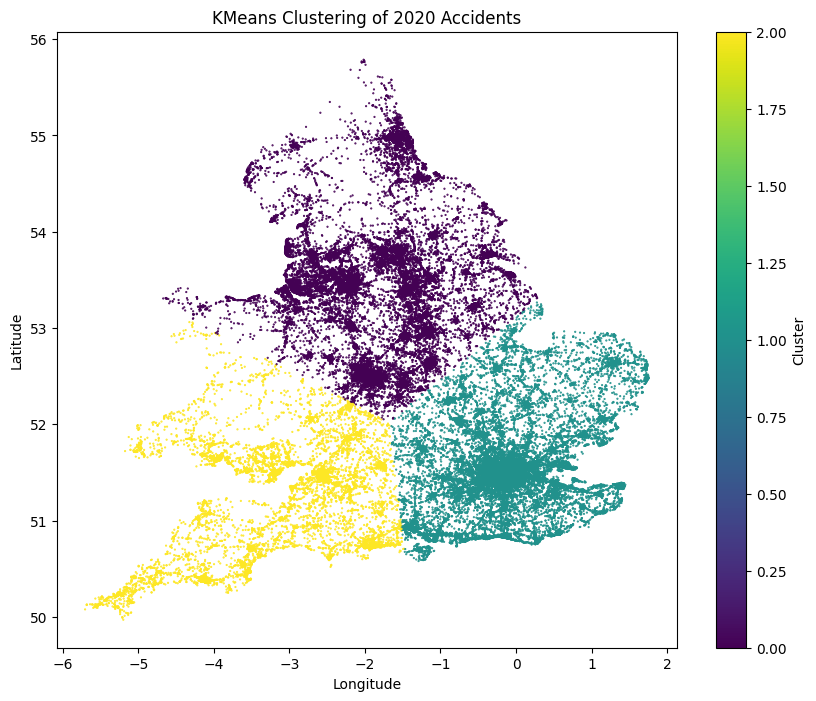

In [63]:
# Scatter plot of the data points colored by cluster labels
plt.figure(figsize=(10, 8))

# Scatter plot with longitude vs latitude, color by the cluster labels
plt.scatter(lon_df['longitude'],lon_df['latitude'], c=labels, cmap='viridis', marker='o',s=0.3)

# Add title and labels
plt.title('KMeans Clustering of 2020 Accidents')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show colorbar to indicate cluster colors
plt.colorbar(label='Cluster')
plt.savefig('13.cluster.png')
# Display the plot
plt.show()


**Evaluate Cluster of 3**

In [66]:
# Get the predicted labels (cluster assignments)
labels = kmeans.labels_

# Compute Davies-Bouldin Score
db_score = davies_bouldin_score(x_scaled, labels)
print(f"Davies-Bouldin Score: {db_score:.4f}")  # Lower is better

# Compute Silhouette Score
sil_score = silhouette_score(x_scaled, labels)
print(f"Silhouette Score: {sil_score:.4f}")  # Higher is better

Davies-Bouldin Score: 0.6722
Silhouette Score: 0.5703


**Using k=4**

In [67]:
kmeans = KMeans(n_clusters=4,random_state=42)

#Fit the KMeans model to the scaled data
kmeans.fit(x_scaled)
# Calculate inertia
inertia=kmeans.inertia_
print(inertia)

38350.87670586008


In [68]:
# Get the predicted labels (cluster assignments)
clust_labels = kmeans.labels_


print(clust_labels)

[1 1 1 ... 2 3 3]


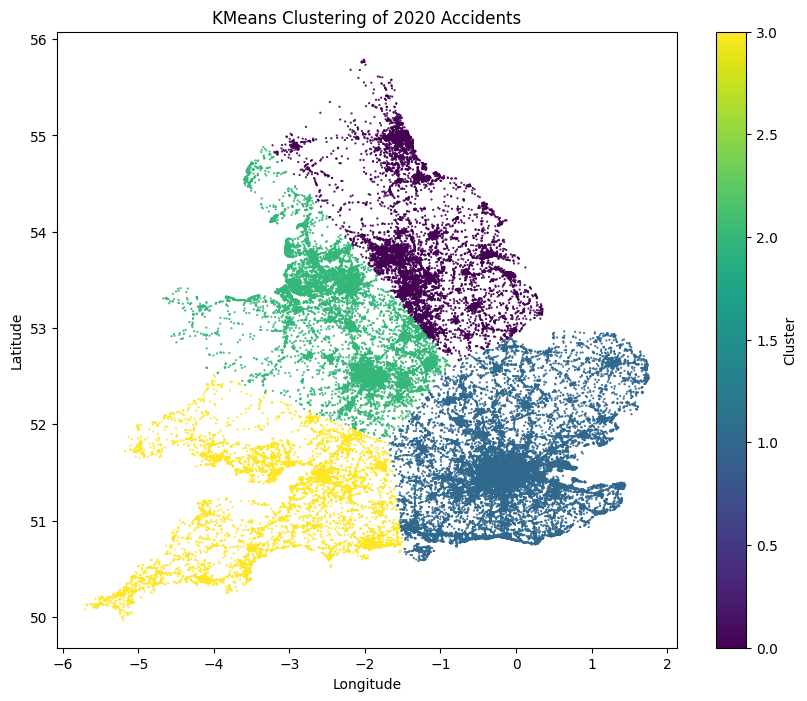

In [69]:
# Scatter plot of the data points colored by cluster labels
plt.figure(figsize=(10, 8))

# Scatter plot with longitude vs latitude, color by the cluster labels
plt.scatter(lon_df['longitude'],lon_df['latitude'], c=clust_labels, cmap='viridis', marker='o',s=0.3)

# Add title and labels
plt.title('KMeans Clustering of 2020 Accidents')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show colorbar to indicate cluster colors
plt.colorbar(label='Cluster')
plt.savefig('14.cluster.png')
# Display the plot
plt.show()


In [72]:
# Compute Davies-Bouldin Score
db_score = davies_bouldin_score(x_scaled, clust_labels)
print(f"Davies-Bouldin Score: {db_score:.4f}")  # Lower is better

# Compute Silhouette Score
sil_score = silhouette_score(x_scaled, clust_labels)
print(f"Silhouette Score: {sil_score:.4f}")  # Higher is better

Davies-Bouldin Score: 0.9309
Silhouette Score: 0.5164


### 6. Choose three policing areas by filtering the data using the "police_force" column.

create time series models to predict weekly accident counts for the upcoming year based on historical data from 2017 to 2019.

In [286]:
ac_df.head()

accident_index  accident_year accident_reference  location_easting_osgr  \
0  2020010219808           2020          010219808               521389.0   
1  2020010220496           2020          010220496               529337.0   
2  2020010228005           2020          010228005               526432.0   
3  2020010228006           2020          010228006               538676.0   
4  2020010228011           2020          010228011               529324.0   

   location_northing_osgr  longitude   latitude  police_force  \
0                175144.0  -0.254001  51.462262             1   
1                176237.0  -0.139253  51.470327             1   
2                182761.0  -0.178719  51.529614             1   
3                184371.0  -0.001683  51.541210             1   
4                181286.0  -0.137592  51.515704             1   

   accident_severity  number_of_vehicles  number_of_casualties        date  \
0                  3                   1                     1  04/02/2020   
1                  3                   1                     2  27/04/2020   
2                  3                   1                     1  01/01/2020   
3                  2                   1                     1  01/01/2020   
4                  3                   1                     2  01/01/2020   

   day_of_week   time  local_authority_district local_authority_ons_district  \
0            3  09:00                        10                    E09000032   
1            2  13:55                         9                    E09000022   
2            4  01:25                         1                    E09000033   
3            4  01:50                        17                    E09000025   
4            4  02:25                         1                    E09000033   

  local_authority_highway  first_road_class  first_road_number  road_type  \
0               E09000032                 6                  0          6   
1               E09000022                 3               3036          6   
2               E09000033                 5                  0          6   
3               E09000025                 3                 11          6   
4               E09000033                 3                 40          6   

   speed_limit  junction_detail  junction_control  second_road_class  \
0           20                0                -1                  0   
1           20                9                 2                  6   
2           30                3                 1                  6   
3           30                0                -1                  0   
4           30                3                 4                  5   

   second_road_number  pedestrian_crossing_human_control  \
0                  -1                                  9   
1                   0                                  0   
2                   0                                  0   
3                  -1                                  0   
4                   0                                  0   

   pedestrian_crossing_physical_facilities  light_conditions  \
0                                        9                 1   
1                                        4                 1   
2                                        0                 4   
3                                        4                 4   
4                                        0                 4   

   weather_conditions  road_surface_conditions  special_conditions_at_site  \
0                   9                        9                           0   
1                   1                        1                           0   
2                   1                        2                           0   
3                   1                        1                           0   
4                   1                        1                           0   

   carriageway_hazards  urban_or_rural_area  \
0                    0                  

**Get training data**

In [26]:
# Connect to Database
con = sqlite3.connect("accident_data_v1.0.0_2023.db")
cur = con.cursor()

# police force = 6 - Greater Manchester .... 12 - North Yorkshire..... 13- West Yorksire 
cur.execute("""
    SELECT date,
           day_of_week,
           police_force
    FROM accident
    WHERE accident.accident_year BETWEEN 2017 AND 2020 
        AND police_force IN ( 6, 12, 13 ) 
""")

# Fetch results
ts_results = cur.fetchall() 

# Convert to DataFrame
headers=[description[0] for description in cur.description]

ts_df = pd.DataFrame(ts_results, columns=headers)

# Close database connection
con.close()

# Display the first few rows
ts_df.head()

date  day_of_week  police_force
0  04/04/2017            3             6
1  22/05/2017            2             6
2  04/06/2017            1             6
3  26/08/2017            7             6
4  30/11/2017            5             6

In [27]:
ts_df.isnull().sum()

date            0
day_of_week     0
police_force    0
dtype: int64

In [28]:
ts_df["day_of_week"].unique()

array([3, 2, 1, 7, 5, 4, 6], dtype=int64)

In [29]:
# Assuming ts_df is already loaded and the 'date' column is in DD/MM/YYYY format
# Convert 'date' column to datetime if not already
ts_df['date'] = pd.to_datetime(ts_df['date'], format='%d/%m/%Y', errors='coerce')

# Drop rows with invalid dates
ts_df = ts_df.dropna(subset=['date'])

# Convert back to DD/MM/YYYY format for grouping
ts_df['date_str'] = ts_df['date'].dt.strftime('%d/%m/%Y')

# Remap 'day_of_week' to standard Pandas' system (Sunday = 6, Monday = 0, etc.)
ts_df['adjusted_day_of_week'] = ts_df['day_of_week'].map({1: 6, 2: 0, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5})

# Calculate the start of the week for each date (the Monday of that week)
ts_df['week_start'] = ts_df['date'] - pd.to_timedelta(ts_df['adjusted_day_of_week'], unit='D')

# Filter out any week_start values before 2017**
ts_df = ts_df[ts_df['week_start'] >= '2017-01-01']

# Group by 'week_start' and 'police_force' to count the number of accidents per police force each week
weekly_accidents = ts_df.groupby(['week_start', 'police_force']).size().reset_index(name='accident_count')

# Pivot the data so each police force gets its own column (with the accident counts)
weekly_accidents_pivot = weekly_accidents.pivot_table(
    index='week_start', 
    columns='police_force', 
    values='accident_count', 
    aggfunc='sum', 
    fill_value=0  # Fill missing values with 0 if no accidents for a given police force in a specific week
)

# Map police force codes to readable names
weekly_accidents_pivot.columns = weekly_accidents_pivot.columns.map({
    6: 'Greater Manchester', 
    12: 'North Yorkshire', 
    13: 'West Yorkshire'
})

# Reset index to make 'week_start' a column again
weekly_accidents_pivot.reset_index(inplace=True)


# Sort by the start of the week
weekly_accidents_pivot = weekly_accidents_pivot.sort_values(by='week_start')

# Rename 'week_start' to 'date'**
weekly_accidents_pivot.rename(columns={'week_start': 'weeks'}, inplace=True)

#  Convert 'week_start' back to DD/MM/YYYY format**
weekly_accidents_pivot['weeks'] = weekly_accidents_pivot['weeks'].dt.strftime('%d/%m/%Y')

 # Save to csv
weekly_accidents_pivot.to_csv('time_series.csv',index=False)

# Display the result
weekly_accidents_pivot.head()


police_force       weeks  Greater Manchester  North Yorkshire  West Yorkshire
0             02/01/2017                  59               29              69
1             09/01/2017                  55               37              83
2             16/01/2017                  56               32              91
3             23/01/2017                  60               32              87
4             30/01/2017                  89               38              94

**Load data for time series analysis**

In [30]:
ts= pd.read_csv("time_series.csv")
ts.head()

weeks  Greater Manchester  North Yorkshire  West Yorkshire
0  02/01/2017                  59               29              69
1  09/01/2017                  55               37              83
2  16/01/2017                  56               32              91
3  23/01/2017                  60               32              87
4  30/01/2017                  89               38              94

In [223]:
ts.isnull().sum() # check for missing values

weeks                 0
Greater Manchester    0
North Yorkshire       0
West Yorkshire        0
dtype: int64

In [31]:
 # Check data types to make sure it's in the right form
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   weeks               209 non-null    object
 1   Greater Manchester  209 non-null    int64 
 2   North Yorkshire     209 non-null    int64 
 3   West Yorkshire      209 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.7+ KB


**Set week as datetype**

In [33]:
 
ts["weeks"] = pd.to_datetime(ts["weeks"], format="%d/%m/%Y", dayfirst=True, errors="coerce")

ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   weeks               209 non-null    datetime64[ns]
 1   Greater Manchester  209 non-null    int64         
 2   North Yorkshire     209 non-null    int64         
 3   West Yorkshire      209 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 6.7 KB


In [34]:
# Set 'week' column as the index and drops the original index( Modifies old dataframe)
ts.set_index('weeks',drop=True, inplace=True)


## PART 1 : Greater Manchester

In [48]:
GM=ts[['Greater Manchester']]
GM.head()

Greater Manchester
weeks                         
2017-01-02                  59
2017-01-09                  55
2017-01-16                  56
2017-01-23                  60
2017-01-30                  89

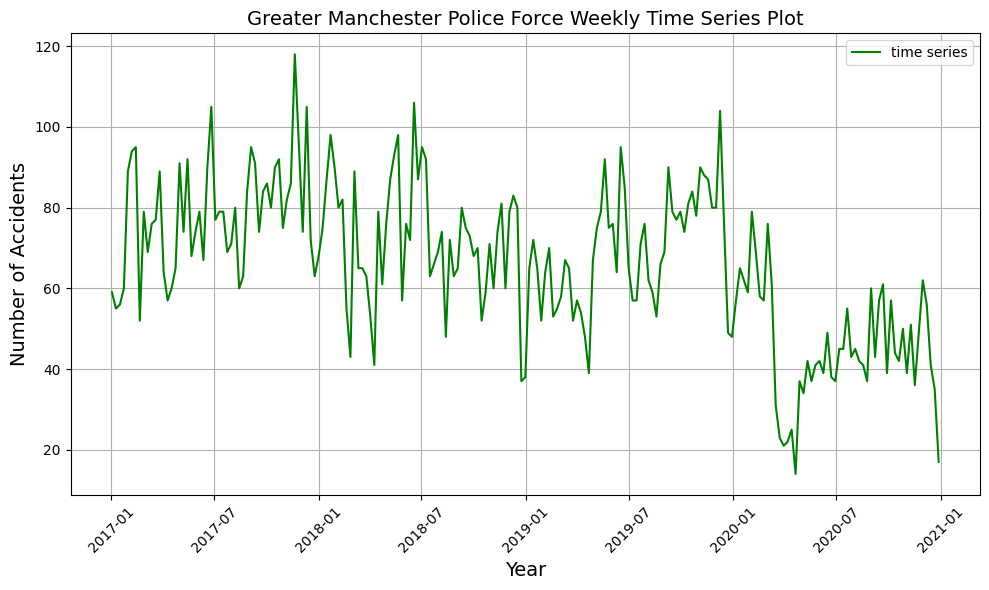

In [44]:
# Plotting the time series
plt.figure(figsize=(10, 6))
plt.plot(GM, linestyle='-',label='time series', color='g')

# Adding titles and labels
plt.title("Greater Manchester Police Force Weekly Time Series Plot", fontsize=14)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Accidents", fontsize=14)

# Show plot
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('16.GM.png')
plt.show()

In [49]:
# Resample the data to weekly frequency and apply forward fill to handle missing values to ensure regular intervals

from pandas.tseries.offsets import Week
#set week=0 i.e monday so data starts from 2017/01/02 as original data 
# linear interpolation fills missing values with mean of previous and next observed values
GM_resampled = GM.resample(Week(weekday=0)).mean().interpolate(method='linear') 
GM_resampled


Greater Manchester
weeks                         
2017-01-02                59.0
2017-01-09                55.0
2017-01-16                56.0
2017-01-23                60.0
2017-01-30                89.0
...                        ...
2020-11-30                62.0
2020-12-07                56.0
2020-12-14                41.0
2020-12-21                35.0
2020-12-28                17.0

[209 rows x 1 columns]

<Figure size 1400x600 with 0 Axes>

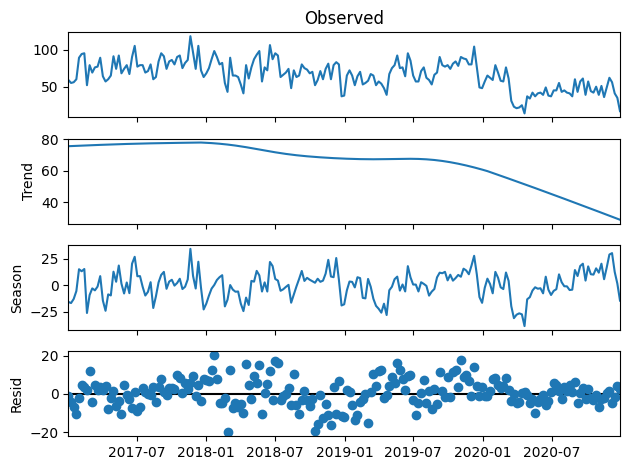

In [50]:
# Perform STL decomposition
stl = STL(GM_resampled, )  # seasonal is the window size for seasonality
result = stl.fit()

# Plot the decomposition
plt.figure(figsize=(14, 6))
result.plot()
plt.savefig('17.GM.png')
plt.show()

<Figure size 1400x1000 with 0 Axes>

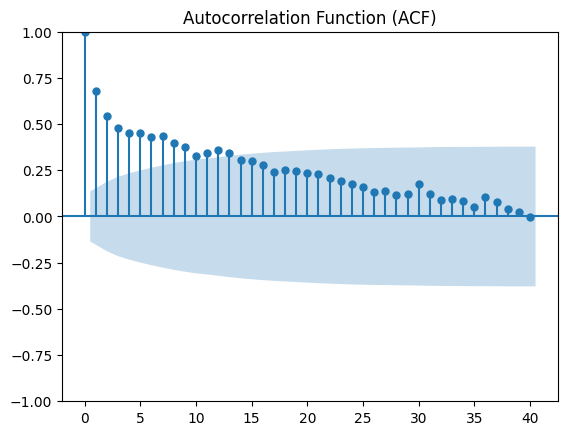

In [52]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

    # PLOT ACF PLOT
plt.figure(figsize=(14,10))
plot_acf(GM_resampled, lags= 40)
plt.title("Autocorrelation Function (ACF)")
plt.savefig('18.GM.png')
plt.show()

<Figure size 1400x1000 with 0 Axes>

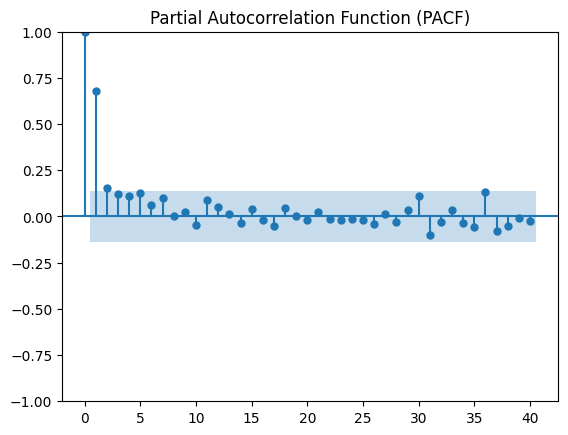

In [53]:
       #PLOT PACF PLOT
plt.figure(figsize=(14,10))
plot_pacf(GM_resampled,lags = 40)
plt.title("Partial Autocorrelation Function (PACF)")
plt.savefig('19.GM.png')
plt.show()

In [54]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller (ADF) test
ADF_test =  adfuller(GM_resampled)[:2]
print(f"ADF Statistic: {ADF_test[0]:.2f} ; p-value: {ADF_test[1]:.2f}")

# Conclusion based on p-value
if ADF_test[1]< 0.05:
    print("The time series is stationary (reject H₀).")
else:
    print("The time series is non-stationary (fail to reject H₀).")

ADF Statistic: -2.54 ; p-value: 0.11
The time series is non-stationary (fail to reject H₀).


**Differencing to obtain stationarity**

In [56]:
 # Apply trend differencing to original series
diff1 = GM_resampled.diff(1).dropna()

# Show the differenced series
diff1

Greater Manchester
weeks                         
2017-01-09                -4.0
2017-01-16                 1.0
2017-01-23                 4.0
2017-01-30                29.0
2017-02-06                 5.0
...                        ...
2020-11-30                13.0
2020-12-07                -6.0
2020-12-14               -15.0
2020-12-21                -6.0
2020-12-28               -18.0

[208 rows x 1 columns]

In [57]:
 # Apply seasonal differencing 
diff2 = diff1.diff(52).dropna()  # biennal seasonality

# Show the differenced series
diff2

Greater Manchester
weeks                         
2018-01-08                11.0
2018-01-15                11.0
2018-01-22                 7.0
2018-01-29               -37.0
2018-02-05               -15.0
...                        ...
2020-11-30                13.0
2020-12-07               -30.0
2020-12-14                13.0
2020-12-21                21.0
2020-12-28               -17.0

[156 rows x 1 columns]

In [58]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller (ADF) test
ADF_test1 =  adfuller(diff2)[:2]
print(f"ADF Statistic: {ADF_test1[0]:.2f} ; p-value: {ADF_test1[1]:.2f}")

# Conclusion based on p-value
if ADF_test1[1]< 0.05:
    print("The time series is stationary (reject H₀).")
else:
    print("The time series is non-stationary (fail to reject H₀).")

ADF Statistic: -9.62 ; p-value: 0.00
The time series is stationary (reject H₀).


**Plot the original, and differenced series.**

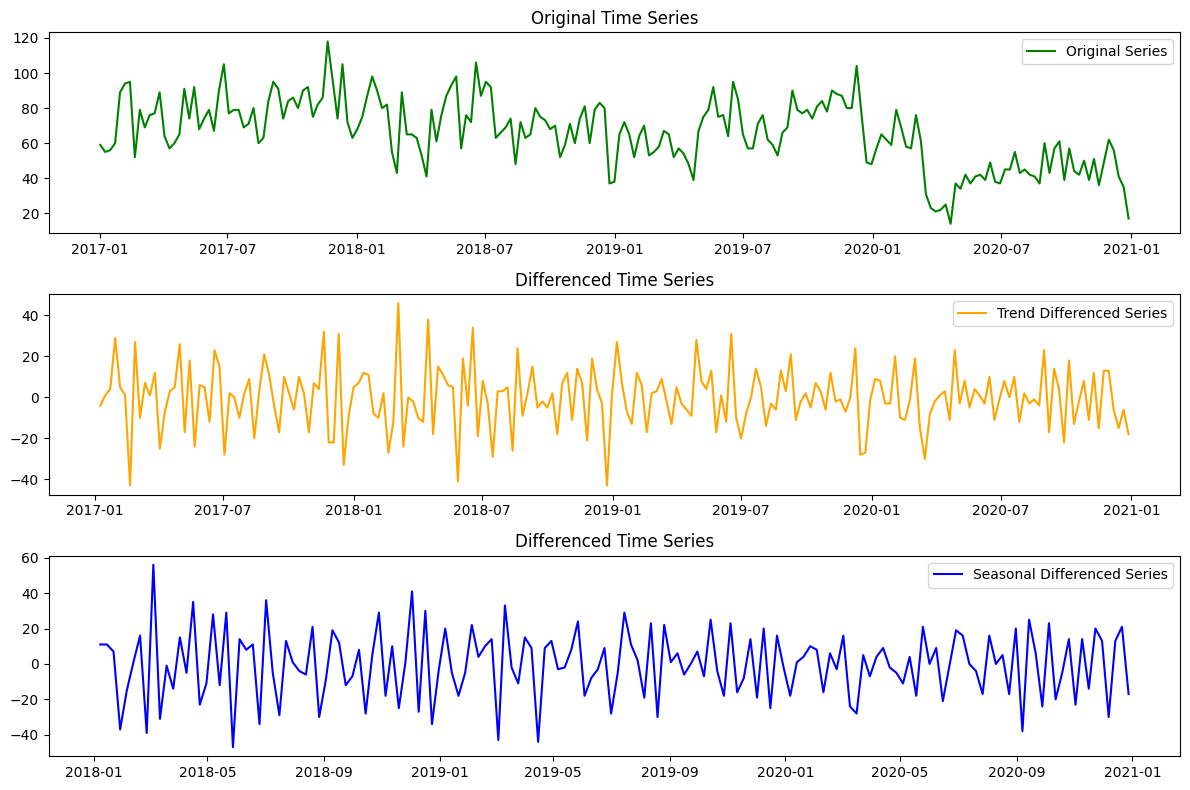

In [59]:
# Plot the original, first differenced, and second differenced series
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(GM_resampled, label='Original Series',color='g')
plt.title('Original Time Series')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(diff1, label='Trend Differenced Series', color='orange')
plt.title('Differenced Time Series')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(diff2, label='Seasonal Differenced Series', color='blue')
plt.title('Differenced Time Series')
plt.legend()

plt.tight_layout()
plt.savefig("20.GM.png")
plt.show()

**Check for over-differencing**

<Figure size 1400x1000 with 0 Axes>

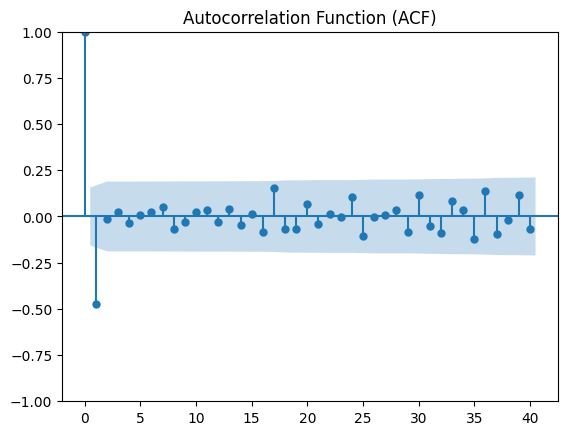

In [60]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

 # PLOT ACF PLOT
plt.figure(figsize=(14,10))
plot_acf(diff2, lags= 40)
plt.title("Autocorrelation Function (ACF)")
plt.savefig('21.GM.png')
plt.show()


<Figure size 1400x1000 with 0 Axes>

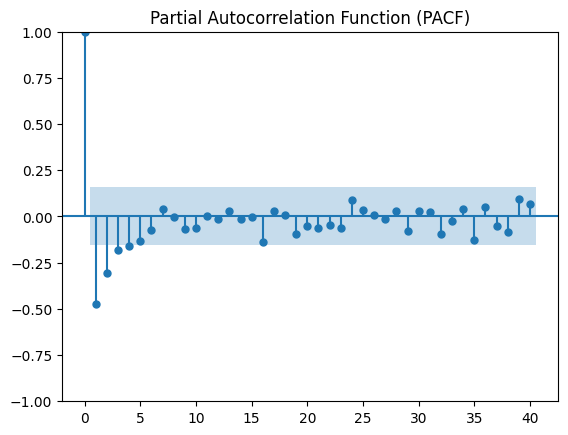

In [61]:
 #PLOT PACF PLOT
plt.figure(figsize=(14,10))
plot_pacf(diff2,lags = 40)
plt.title("Partial Autocorrelation Function (PACF)")
plt.savefig('22.GM.png')
plt.show()

**To obtain optimal order for model**

In [62]:
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Defining the parameter ranges
ps = np.arange(1, 3, 1)  # order of AR
qs = np.arange(1, 3, 1)  # order of MA
Ps = [0]  # seasonal AR order
Qs = [0]  # seasonal MA order
d = 1  # number of times the series is differenced to attain stationarity
D = 0  # Seasonal differencing
s = 52  # seasonal period (annual pattern for monthly time series data)

 # Generate all combinations of p, q, P, Q
p_q_list = list(product(ps, qs, Ps, Qs))
print(f"Generated parameter combinations: {p_q_list[:5]}")  # Check parameter combinations
 # [:5] - inidicates a selection range 
 # start from begining to the fifth [where index=4 i.e 0-4]
 # no value before the colon means start from begining.
 
 # [5:] - from index 5 untill the end.
 # [start:end] 
 # Put combinations in a list
df_p_q_list=pd.DataFrame(p_q_list,columns=["AR(p)","MA(q)","AR(Ps)","MA(Qs)"])
df_p_q_list

Generated parameter combinations: [(1, 1, 0, 0), (1, 2, 0, 0), (2, 1, 0, 0), (2, 2, 0, 0)]


AR(p)  MA(q)  AR(Ps)  MA(Qs)
0      1      1       0       0
1      1      2       0       0
2      2      1       0       0
3      2      2       0       0

In [64]:
# Function to get the best AIC values
def aic_values(target):
    """This function accepts a series and returns 
    the AIC values"""  
    list_of_aic = [] 

    for order in p_q_list:
        try:
            model = SARIMAX(
                endog=target,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s), 
                simple_differencing=False
            ).fit(disp=False)
            
            list_of_aic.append([order, model.aic])
        
        except Exception as e:
            print(f"Error for order {order}: {e}")
            continue 

    aic_df = pd.DataFrame(list_of_aic, columns=['Order(p,q,Ps,QS)', 'AIC']) 
    aic_df.sort_values(by='AIC', ascending=True, inplace=True) #sort values
    
    return aic_df


In [65]:
aic_df = aic_values(GM_resampled['Greater Manchester'])
aic_df

C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order(p,q,Ps,QS)          AIC
0     (1, 1, 0, 0)  1672.732050
3     (2, 2, 0, 0)  1674.014732
2     (2, 1, 0, 0)  1674.729610
1     (1, 2, 0, 0)  1674.729662

## Build and evaluate models

In [66]:
GM_resampled.head()

Greater Manchester
weeks                         
2017-01-02                59.0
2017-01-09                55.0
2017-01-16                56.0
2017-01-23                60.0
2017-01-30                89.0

**Split into train and test set**

In [70]:
GMtrain=GM_resampled[:-52]    # Use all years 2017-2019
GMtest=GM_resampled[-52:]   # Use 2020 for testing
GMtrain

Greater Manchester
weeks                         
2017-01-02                59.0
2017-01-09                55.0
2017-01-16                56.0
2017-01-23                60.0
2017-01-30                89.0
...                        ...
2019-12-02                80.0
2019-12-09               104.0
2019-12-16                76.0
2019-12-23                49.0
2019-12-30                48.0

[157 rows x 1 columns]

### GREATER MANCHESTER ARIMA MODEL

In [73]:
 # AR(1) d=0 MA(1)
GMarima_model = SARIMAX(endog=GMtrain, order=(1,1,1)).fit()
GMarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     Greater Manchester   No. Observations:                  157
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -629.040
Date:                Tue, 01 Apr 2025   AIC                           1264.080
Time:                        11:37:18   BIC                           1273.229
Sample:                    01-02-2017   HQIC                          1267.796
                         - 12-30-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4069      0.077      5.283      0.000       0.256       0.558
ma.L1         -0.9567      0.030    -32.358      0.000      -1.015      -0.899
sigma2       184.2074     20.862      8.830      0.000     143.319     225.096
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.07
Prob(Q):                              0.95   Prob(JB):                         0.97
Heteroskedasticity (H):               0.70   Skew:                            -0.05
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

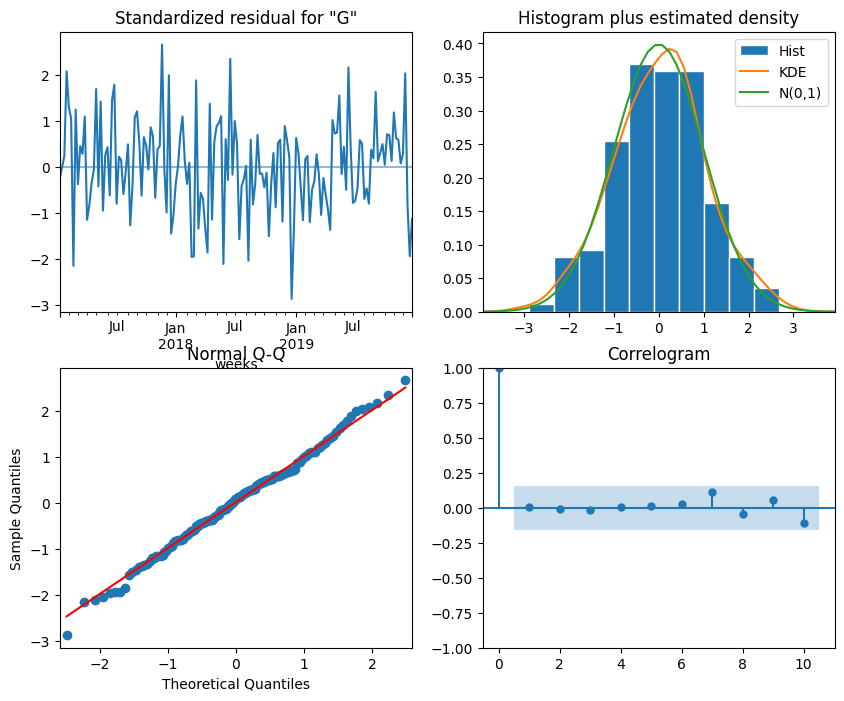

In [74]:
# Plots the Q-Q plot 
GMarima_model.plot_diagnostics(figsize=(10,8)); 
plt.savefig('23.GM.png')

In [75]:
from statsmodels.stats.diagnostic import acorr_ljungbox 
acorr_ljungbox(GMarima_model.resid)

lb_stat  lb_pvalue
1   0.001698   0.967133
2   0.020211   0.989946
3   0.039238   0.997957
4   0.574275   0.965879
5   0.900884   0.970158
6   1.302684   0.971510
7   1.648386   0.976724
8   1.660266   0.989716
9   1.939549   0.992388
10  3.319465   0.972876

In [77]:
len_test = len(GMtest)   # 52 weeks for testing
len_test

52

In [78]:
 #Prediction with ARIMA model (get forecast predictions for the last 12 months)
GMarima_pred = GMarima_model.get_forecast(len_test).predicted_mean.values
GMarima_pred

array([62.19419176, 67.96951295, 70.31937094, 71.27547924, 71.66449981,
       71.82278418, 71.8871868 , 71.91339088, 71.92405278, 71.92839088,
       71.93015596, 71.93087414, 71.93116635, 71.93128525, 71.93133362,
       71.93135331, 71.93136131, 71.93136457, 71.9313659 , 71.93136644,
       71.93136666, 71.93136675, 71.93136678, 71.9313668 , 71.9313668 ,
       71.93136681, 71.93136681, 71.93136681, 71.93136681, 71.93136681,
       71.93136681, 71.93136681, 71.93136681, 71.93136681, 71.93136681,
       71.93136681, 71.93136681, 71.93136681, 71.93136681, 71.93136681,
       71.93136681, 71.93136681, 71.93136681, 71.93136681, 71.93136681,
       71.93136681, 71.93136681, 71.93136681, 71.93136681, 71.93136681,
       71.93136681, 71.93136681])

In [82]:
GMnaive_pred = GM_resampled['Greater Manchester'][len(GMtrain)-52:len(GMtrain)].values 
GMnaive_pred

array([ 65.,  72.,  65.,  52.,  64.,  70.,  53.,  55.,  58.,  67.,  65.,
        52.,  57.,  54.,  48.,  39.,  67.,  75.,  79.,  92.,  75.,  76.,
        64.,  95.,  85.,  65.,  57.,  57.,  71.,  76.,  62.,  59.,  53.,
        66.,  69.,  90.,  79.,  77.,  79.,  74.,  81.,  84.,  78.,  90.,
        88.,  87.,  80.,  80., 104.,  76.,  49.,  48.])

In [83]:
# Assign predictions dataframe called test
GMtest['GMnaive_pred'] = GMnaive_pred 
GMtest['GMarima_pred'] = GMarima_pred

C:\Users\Hp\AppData\Local\Temp\ipykernel_21824\3433464598.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GMtest['GMnaive_pred'] = GMnaive_pred
C:\Users\Hp\AppData\Local\Temp\ipykernel_21824\3433464598.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GMtest['GMarima_pred'] = GMarima_pred


In [84]:
GMtest.head()

Greater Manchester  GMnaive_pred  GMarima_pred
weeks                                                     
2020-01-06                57.0          65.0     62.194192
2020-01-13                65.0          72.0     67.969513
2020-01-20                62.0          65.0     70.319371
2020-01-27                59.0          52.0     71.275479
2020-02-03                79.0          64.0     71.664500

**Evaluation using root mean squared error**

In [85]:
from sklearn.metrics import mean_squared_error

 # actual value vs predicted value
GMarima_mse = mean_squared_error(GMtest['Greater Manchester'], GMtest['GMarima_pred'])  # Calculate MSE
GMarima_rmse = np.sqrt(GMarima_mse)  # Take the square root to get RMSE

GMnaive_mse = mean_squared_error(GMtest['Greater Manchester'], GMtest['GMnaive_pred'])  # Calculate MSE
GMnaive_rmse = np.sqrt(GMnaive_mse)  # Take the square root to get RMSE

In [86]:
list_rmse = [GMarima_rmse,GMnaive_rmse] 
print(list_rmse)

models = ['Arima', 'Naive'] # just strings
print(models)

[29.86583821663472, 29.694599353573214]
['Arima', 'Naive']


### GREATER MANCHESTER SARIMA MODEL

In [88]:
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Defining the parameter ranges
ps = np.arange(1, 3, 1)  # AR order from 1 to 2
qs = np.arange(1, 3, 1)  # MA order from 1 to 2
Ps = np.arange(1,3,1)  # Seasonal AR order
Qs = np.arange(1,3,1)  # Seasonal MA order
d = [1]  # Differencing from 1 to 2
D = [1]  # Seasonal differencing from 0 to 1
s = 52  # seasonal period (annual pattern for monthly time series data)

 # Generate all combinations of p, q, P, Q, d, D
p_q_list = list(product(ps, qs, Ps, Qs, d, D))  # Using np.arange for d and D
#print(f"Generated parameter combinations: {p_q_list[:5]}")  # Check parameter combinations
 
 # Put combinations in a list
df_p_q_list=pd.DataFrame(p_q_list,columns=["AR(p)","MA(q)","AR(Ps)","MA(Qs)","d","D"])
df_p_q_list

AR(p)  MA(q)  AR(Ps)  MA(Qs)  d  D
0       1      1       1       1  1  1
1       1      1       1       2  1  1
2       1      1       2       1  1  1
3       1      1       2       2  1  1
4       1      2       1       1  1  1
5       1      2       1       2  1  1
6       1      2       2       1  1  1
7       1      2       2       2  1  1
8       2      1       1       1  1  1
9       2      1       1       2  1  1
10      2      1       2       1  1  1
11      2      1       2       2  1  1
12      2      2       1       1  1  1
13      2      2       1       2  1  1
14      2      2       2       1  1  1
15      2      2       2       2  1  1

In [89]:
# Function to get the best AIC values
def aic_values(target):
    """This function accepts a series and returns the AIC values"""  
    list_of_aic = [] 

    for order in p_q_list:
        try:
            model = SARIMAX(
                endog=target,
                order=(order[0], order[4], order[1]),  # AR, differencing, MA
                seasonal_order=(order[2], order[5], order[3], s),  # Seasonal AR, differencing, MA, seasonal period
                simple_differencing=False
            ).fit(disp=False)
            
            list_of_aic.append([order, model.aic])
        
        except Exception as e:
            print(f"Error for order {order}: {e}")
            continue 

    # Create a DataFrame from the list of AIC values
    aic_df = pd.DataFrame(list_of_aic, columns=['Order(p,q,Ps,QS,d,D)', 'AIC'])
    # Sort values by AIC in ascending order (lower AIC is better)
    aic_df.sort_values(by='AIC', ascending=True, inplace=True)
    
    return aic_df

In [90]:
aic_df = aic_values(GM_resampled['Greater Manchester'])
aic_df

C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.p

Order(p,q,Ps,QS,d,D)          AIC
0    (1, 1, 1, 1, 1, 1)  1273.078498
2    (1, 1, 2, 1, 1, 1)  1275.010596
8    (2, 1, 1, 1, 1, 1)  1275.036003
4    (1, 2, 1, 1, 1, 1)  1275.039226
1    (1, 1, 1, 2, 1, 1)  1275.042180
3    (1, 1, 2, 2, 1, 1)  1276.901611
10   (2, 1, 2, 1, 1, 1)  1276.988684
6    (1, 2, 2, 1, 1, 1)  1276.996339
12   (2, 2, 1, 1, 1, 1)  1277.001420
5    (1, 2, 1, 2, 1, 1)  1277.012045
9    (2, 1, 1, 2, 1, 1)  1277.036863
11   (2, 1, 2, 2, 1, 1)  1278.901208
7    (1, 2, 2, 2, 1, 1)  1278.907065
14   (2, 2, 2, 1, 1, 1)  1278.985222
13   (2, 2, 1, 2, 1, 1)  1279.002696
15   (2, 2, 2, 2, 1, 1)  1280.886875

In [92]:
GMsarima_model = SARIMAX(endog=GMtrain, order=(1, 1, 1),seasonal_order=(1, 1, 1, 52)).fit()
GMsarima_model.summary()

C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                 Greater Manchester   No. Observations:                  157
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -422.916
Date:                            Tue, 01 Apr 2025   AIC                            855.831
Time:                                    12:12:48   BIC                            869.053
Sample:                                01-02-2017   HQIC                           861.188
                                     - 12-30-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1301      0.122      1.070      0.285      -0.108       0.368
ma.L1         -0.8876      0.064    -13.949      0.000      -1.012      -0.763
ar.S.L52      -0.9871      2.167     -0.455      0.649      -5.235       3.261
ma.S.L52       0.8053     15.282      0.053      0.958     -29.148      30.758
sigma2       111.2374   1423.987      0.078      0.938   -2679.725    2902.200
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.69
Prob(Q):                              0.99   Prob(JB):                         0.43
Heteroskedasticity (H):               0.51   Skew:                            -0.10
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

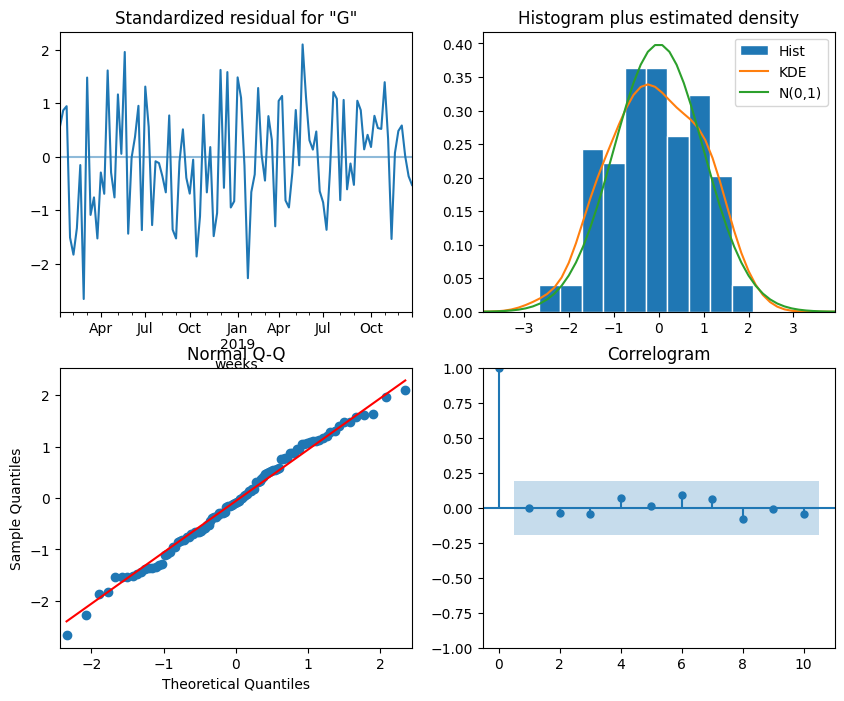

In [216]:
# Plots the Q-Q plot 
GMsarima_model.plot_diagnostics(figsize=(10,8)); 
plt.savefig('24.GM.png')

In [95]:
from statsmodels.stats.diagnostic import acorr_ljungbox 

acorr_ljungbox(GMsarima_model.resid)

lb_stat  lb_pvalue
1   2.947282   0.086022
2   3.058706   0.216676
3   3.535176   0.316229
4   4.828893   0.305309
5   4.985046   0.417708
6   6.441267   0.375614
7   6.466543   0.486447
8   6.571417   0.583497
9   6.723672   0.665864
10  6.740186   0.749724

In [96]:
GMsarima_pred = GMsarima_model.get_forecast(len_test)    # both predicted values and forecast dates are recieved here
GMsarima_pred = GMsarima_pred.predicted_mean 
#print(GMsarima_pred)

In [97]:
# Assiging the prediction to the test set dataframe 
GMtest['GMsarima_pred'] = GMsarima_pred  # assign sarima pred to the test dataframe as well
GMtest.head()

C:\Users\Hp\AppData\Local\Temp\ipykernel_21824\3524522800.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GMtest['GMsarima_pred'] = GMsarima_pred  # assign sarima pred to the test dataframe as well


Greater Manchester  GMnaive_pred  GMarima_pred  GMsarima_pred
weeks                                                                    
2020-01-06                57.0          65.0     62.194192      76.044760
2020-01-13                65.0          72.0     67.969513      89.787203
2020-01-20                62.0          65.0     70.319371      92.644148
2020-01-27                59.0          52.0     71.275479      67.772490
2020-02-03                79.0          64.0     71.664500      65.412268

In [98]:
 # Using Passengers and sarima_pred from the test dataframe
GMsarima_mse = mean_squared_error(GMtest['Greater Manchester'],GMtest['GMsarima_pred']) 
GMsarima_rmse = np.sqrt(GMsarima_mse)  # Take the square root to get RMSE
GMsarima_rmse

28.404109751075236

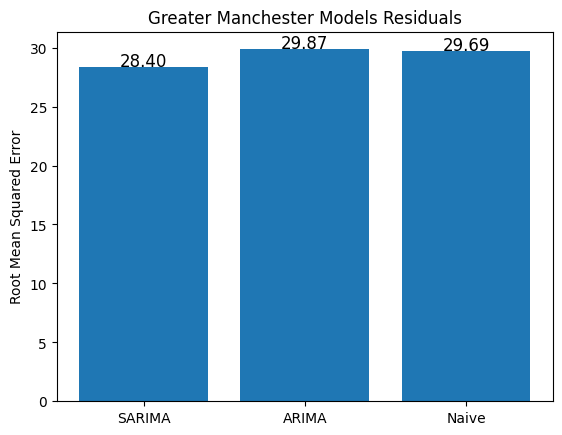

In [217]:
list_rmse = [GMsarima_rmse, GMarima_rmse, GMnaive_rmse]  
models = ['SARIMA', 'ARIMA', 'Naive']

# Plot the bar chart
plt.bar(x=models, height=list_rmse,)  
plt.ylabel('Root Mean Squared Error')  
plt.title('Greater Manchester Models Residuals')    

# Add text annotations on top of each bar
for i, value in enumerate(list_rmse):  
    plt.text(i, value + 0.05, f'{value:.2f}', ha='center', fontsize=12)  

# Save and show the plot
plt.savefig('25.GM.png', bbox_inches='tight')  
plt.show()  


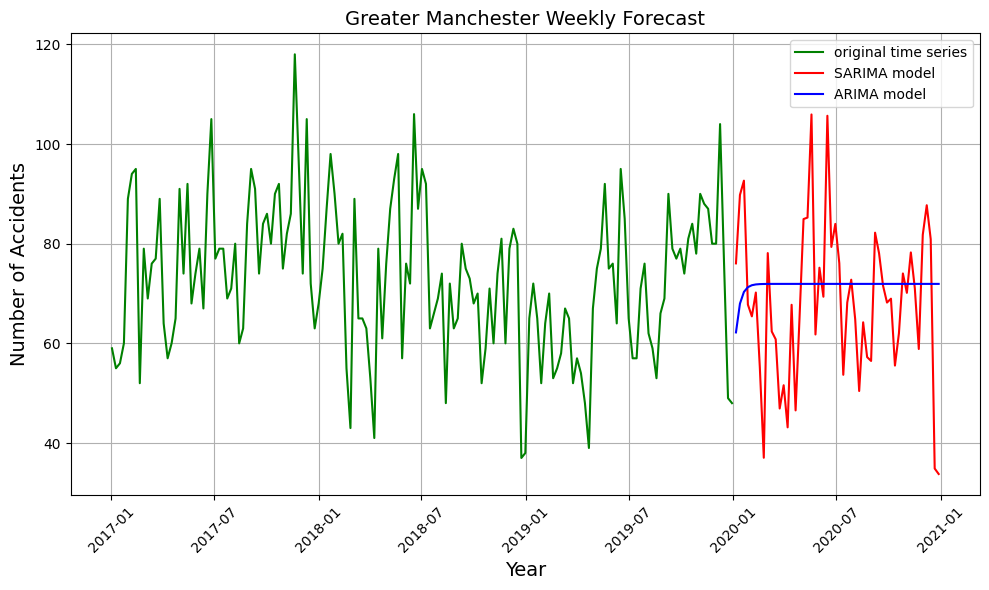

In [178]:
                                            # Plotting the forecast for 2020
plt.figure(figsize=(10, 6))
plt.plot(GMtrain, linestyle='-', label='original time series', color='g') # original time series

plt.plot(GMtest["GMsarima_pred"], linestyle='-' , label='SARIMA model', color = 'r') # plot showing ARIMA predictions made

plt.plot(GMtest["GMarima_pred"], linestyle='-' , label='ARIMA model', color = 'b') # plot showing NAIVE predictions made

# Adding titles and labels
plt.title("Greater Manchester Weekly Forecast", fontsize=14)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Accidents", fontsize=14)

# Show plot
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('25.GM.png')
plt.show()

## PART 2 : North Yorkshire

In [218]:
NY=ts[['North Yorkshire']]
NY.head()

North Yorkshire
weeks                      
2017-01-02               29
2017-01-09               37
2017-01-16               32
2017-01-23               32
2017-01-30               38

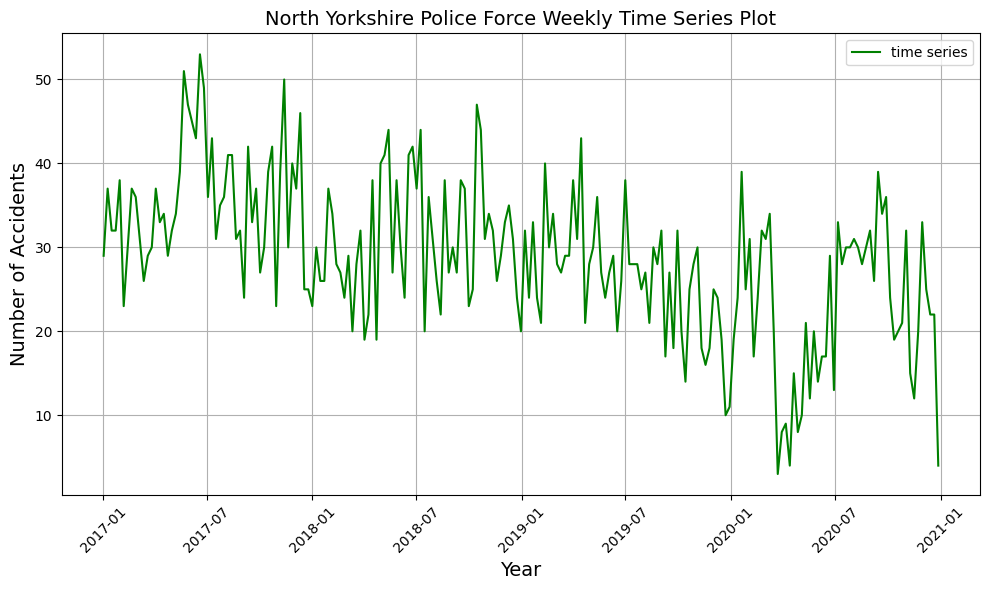

In [219]:
# Plotting the time series
plt.figure(figsize=(10, 6))
plt.plot(NY, linestyle='-',label='time series', color='g')

# Adding titles and labels
plt.title("North Yorkshire Police Force Weekly Time Series Plot", fontsize=14)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Accidents", fontsize=14)

# Show plot
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('26.NY.png')
plt.show()

In [220]:
from pandas.tseries.offsets import Week
#set week=0 i.e monday so data starts from 2017/01/02 as original data 
# linear interpolation fills missing values with mean of previous and next observed values
NY_resampled = NY.resample(Week(weekday=0)).mean().interpolate(method='linear') 
NY_resampled.head()

North Yorkshire
weeks                      
2017-01-02             29.0
2017-01-09             37.0
2017-01-16             32.0
2017-01-23             32.0
2017-01-30             38.0

<Figure size 1400x600 with 0 Axes>

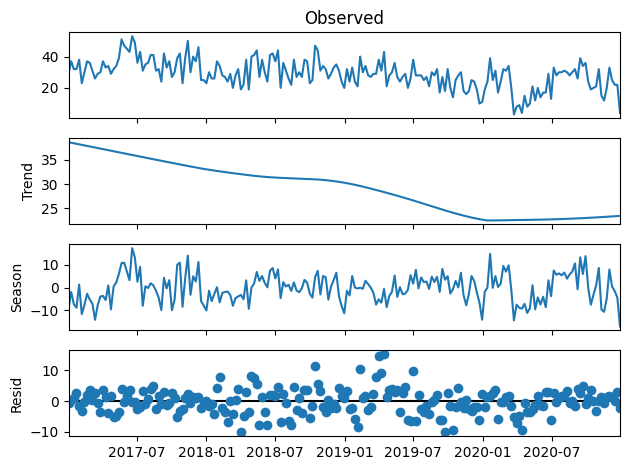

In [221]:
from statsmodels.tsa.seasonal import STL

# Perform STL decomposition
stl = STL(NY_resampled, )  # seasonal is the window size for seasonality
result = stl.fit()

# Plot the decomposition
plt.figure(figsize=(14, 6))
result.plot()
plt.savefig('27.NY.png')
plt.show()

<Figure size 1400x1000 with 0 Axes>

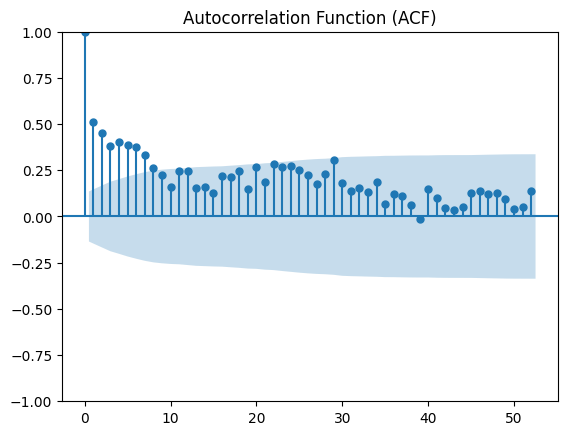

In [222]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

    # PLOT ACF PLOT
plt.figure(figsize=(14,10))
plot_acf(NY_resampled, lags= 52)
plt.title("Autocorrelation Function (ACF)")
plt.savefig('28.NY.png')
plt.show()

<Figure size 1400x1000 with 0 Axes>

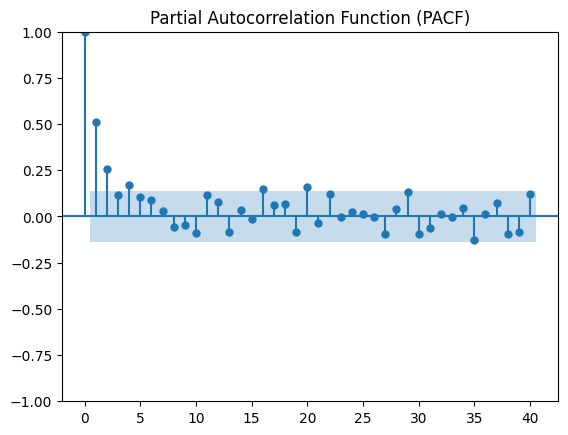

In [223]:
    #PLOT PACF PLOT
plt.figure(figsize=(14,10))
plot_pacf(NY_resampled,lags = 40)
plt.title("Partial Autocorrelation Function (PACF)")
plt.savefig('29.NY.png')
plt.show()

In [225]:
 # Apply trend differencing to original series
dif1 = NY_resampled.diff(1).dropna()

# Show the differenced series
dif1



North Yorkshire
weeks                      
2017-01-09              8.0
2017-01-16             -5.0
2017-01-23              0.0
2017-01-30              6.0
2017-02-06            -15.0
...                     ...
2020-11-30             13.0
2020-12-07             -8.0
2020-12-14             -3.0
2020-12-21              0.0
2020-12-28            -18.0

[208 rows x 1 columns]

In [226]:
 # Apply seasonal differencing 
dif2 = dif1.diff(52).dropna()  # biennal seasonality

# Show the differenced series
dif2


North Yorkshire
weeks                      
2018-01-08             -1.0
2018-01-15              1.0
2018-01-22              0.0
2018-01-29              5.0
2018-02-05             12.0
...                     ...
2020-11-30              6.0
2020-12-07             -7.0
2020-12-14              2.0
2020-12-21              9.0
2020-12-28            -19.0

[156 rows x 1 columns]

In [227]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller (ADF) test
ADF_test =  adfuller(dif2)[:2]
print(f"ADF Statistic: {ADF_test[0]:.2f} ; p-value: {ADF_test[1]:.2f}")

# Conclusion based on p-value
if ADF_test[1]< 0.05:
    print("The time series is stationary (reject H₀).")
else:
    print("The time series is non-stationary (fail to reject H₀).")


ADF Statistic: -8.22 ; p-value: 0.00
The time series is stationary (reject H₀).


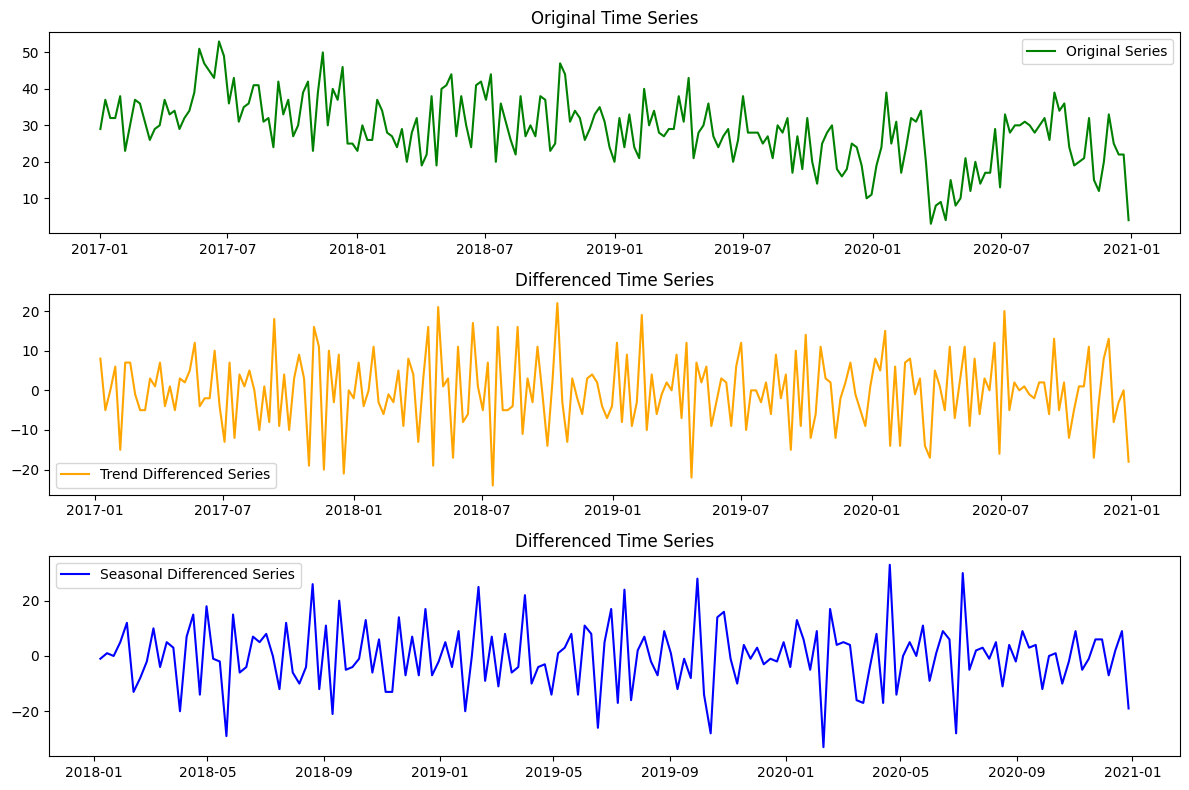

In [228]:
# Plot the original, first differenced, and second differenced series
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(NY_resampled, label='Original Series',color='g')
plt.title('Original Time Series')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(dif1, label='Trend Differenced Series', color='orange')
plt.title('Differenced Time Series')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(dif2, label='Seasonal Differenced Series', color='blue')
plt.title('Differenced Time Series')
plt.legend()

plt.tight_layout()
plt.savefig("30.NY.png")
plt.show()


**Check for over-differencing**

<Figure size 1400x1000 with 0 Axes>

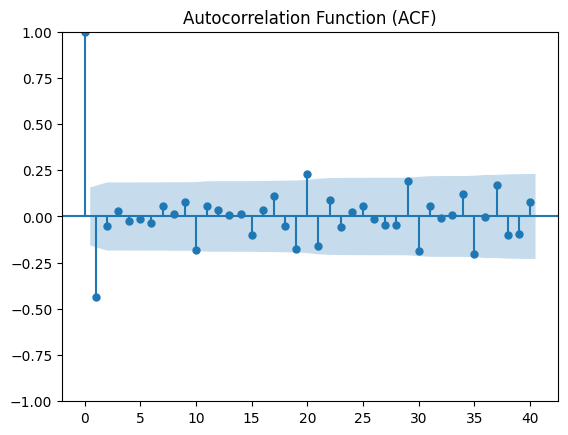

<Figure size 1400x1000 with 0 Axes>

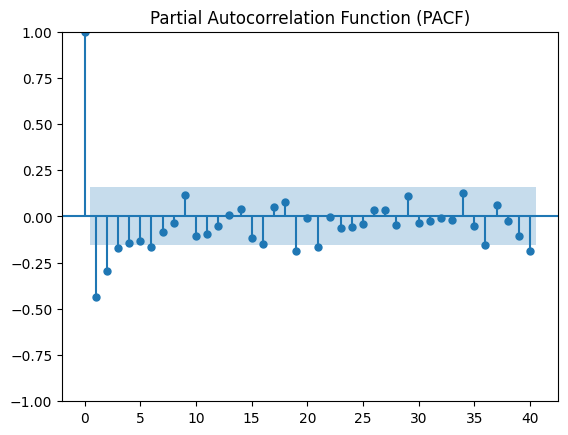

In [229]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

 # PLOT ACF PLOT
plt.figure(figsize=(14,10))
plot_acf(dif2, lags= 40)
plt.title("Autocorrelation Function (ACF)")
plt.savefig('31.NY.png')
plt.show()


 #PLOT PACF PLOT
plt.figure(figsize=(14,10))
plot_pacf(dif2,lags = 40)
plt.title("Partial Autocorrelation Function (PACF)")
plt.savefig('32.NY.png')
plt.show()


In [230]:
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Defining the parameter ranges
ps = np.arange(1, 4, 1)  # order of AR
qs = np.arange(1, 4, 1)  # order of MA
Ps = [0]  # seasonal AR order
Qs = [0]  # seasonal MA order
d = 1  # number of times the series is differenced to attain stationarity
D = 0  # Seasonal differencing
s = 52  # seasonal period (annual pattern for monthly time series data)

 # Generate all combinations of p, q, P, Q
p_q_list = list(product(ps, qs, Ps, Qs))
print(f"Generated parameter combinations: {p_q_list[:5]}")  # Check parameter combinations
 # [:5] - inidicates a selection range 
 # start from begining to the fifth [where index=4 i.e 0-4]
 # no value before the colon means start from begining.
 
 # [5:] - from index 5 untill the end.
 # [start:end] 
 # Put combinations in a list
df_p_q_list=pd.DataFrame(p_q_list,columns=["AR(p)","MA(q)","AR(Ps)","MA(Qs)"])
df_p_q_list


Generated parameter combinations: [(1, 1, 0, 0), (1, 2, 0, 0), (1, 3, 0, 0), (2, 1, 0, 0), (2, 2, 0, 0)]


AR(p)  MA(q)  AR(Ps)  MA(Qs)
0      1      1       0       0
1      1      2       0       0
2      1      3       0       0
3      2      1       0       0
4      2      2       0       0
5      2      3       0       0
6      3      1       0       0
7      3      2       0       0
8      3      3       0       0

In [231]:
# Function to get the best AIC values
def aic_values(target):
    """This function accepts a series and returns 
    the AIC values"""  
    list_of_aic = [] 

    for order in p_q_list:
        try:
            model = SARIMAX(
                endog=target,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s), 
                simple_differencing=False
            ).fit(disp=False)
            
            list_of_aic.append([order, model.aic])
        
        except Exception as e:
            print(f"Error for order {order}: {e}")
            continue 

    aic_df = pd.DataFrame(list_of_aic, columns=['Order(p,q,Ps,QS)', 'AIC']) 
    aic_df.sort_values(by='AIC', ascending=True, inplace=True) #sort values
    
    return aic_df


In [196]:
aic_df = aic_values(NY_resampled['North Yorkshire'])
aic_df

C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimiza

Order(p,q,Ps,QS)          AIC
1     (1, 2, 0, 0)  1430.835011
5     (2, 3, 0, 0)  1431.227256
4     (2, 2, 0, 0)  1432.699492
8     (3, 3, 0, 0)  1432.752394
3     (2, 1, 0, 0)  1433.047811
0     (1, 1, 0, 0)  1433.227520
7     (3, 2, 0, 0)  1433.577038
6     (3, 1, 0, 0)  1434.788744
2     (1, 3, 0, 0)  1436.042716

### NORTH YORKSHIRE ARIMA MODEL

#### Build and evaluate model

In [203]:

NYtrain=NY_resampled[:-52]    # Use all years 2017-2019
NYtest=NY_resampled[-52:]   # Use 2020 for testing
NYtrain

North Yorkshire
weeks                      
2017-01-02             29.0
2017-01-09             37.0
2017-01-16             32.0
2017-01-23             32.0
2017-01-30             38.0
...                     ...
2019-12-02             25.0
2019-12-09             24.0
2019-12-16             19.0
2019-12-23             10.0
2019-12-30             11.0

[157 rows x 1 columns]

In [206]:
NYarima_model = SARIMAX(endog=NYtrain, order=(1,1,2)).fit()
NYarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        North Yorkshire   No. Observations:                  157
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -527.129
Date:                Tue, 01 Apr 2025   AIC                           1062.257
Time:                        13:55:50   BIC                           1074.457
Sample:                    01-02-2017   HQIC                          1067.212
                         - 12-30-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0353      1.464     -0.024      0.981      -2.904       2.834
ma.L1         -0.7333      1.461     -0.502      0.616      -3.596       2.130
ma.L2         -0.0802      1.181     -0.068      0.946      -2.394       2.234
sigma2        50.0633      6.689      7.484      0.000      36.953      63.174
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.83
Prob(Q):                              0.93   Prob(JB):                         0.24
Heteroskedasticity (H):               0.71   Skew:                             0.23
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

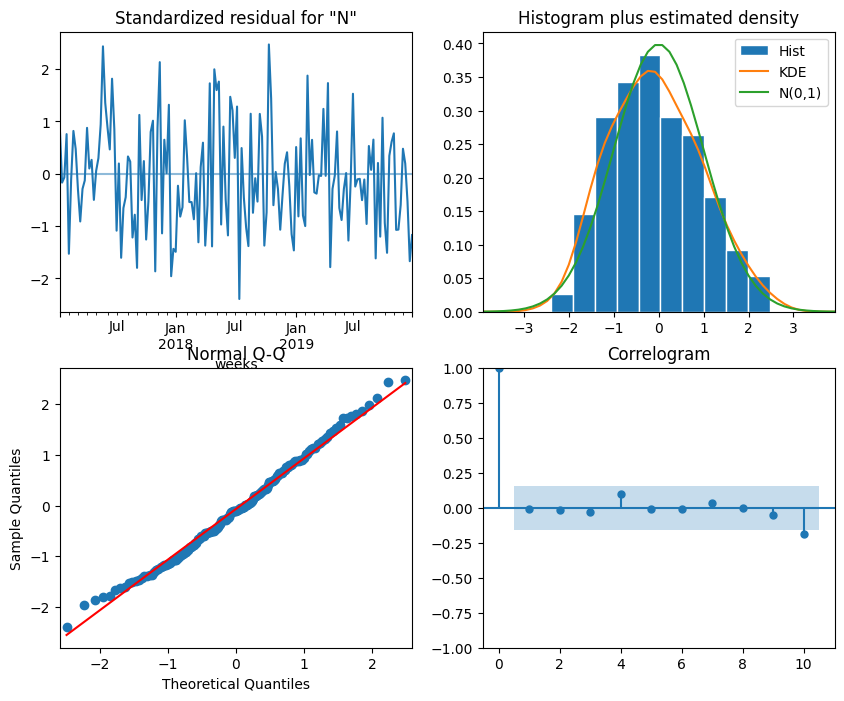

In [205]:
# Plots the Q-Q plot 
NYarima_model.plot_diagnostics(figsize=(10,8)); 
plt.savefig('33.NY.png')

In [207]:
from statsmodels.stats.diagnostic import acorr_ljungbox 
acorr_ljungbox(NYarima_model.resid)


lb_stat  lb_pvalue
1   0.073115   0.786855
2   0.112312   0.945392
3   0.234551   0.971828
4   2.175188   0.703574
5   2.494184   0.777371
6   2.500434   0.868419
7   2.978010   0.887029
8   2.999858   0.934366
9   3.477521   0.942328
10  9.694682   0.467676

In [208]:
len_test = len(NYtest)  
len_test

 #Prediction with ARIMA model 
NYarima_pred = NYarima_model.get_forecast(len_test).predicted_mean.values
NYarima_pred

array([17.98327569, 18.40093428, 18.38621042, 18.38672949, 18.38671119,
       18.38671183, 18.38671181, 18.38671181, 18.38671181, 18.38671181,
       18.38671181, 18.38671181, 18.38671181, 18.38671181, 18.38671181,
       18.38671181, 18.38671181, 18.38671181, 18.38671181, 18.38671181,
       18.38671181, 18.38671181, 18.38671181, 18.38671181, 18.38671181,
       18.38671181, 18.38671181, 18.38671181, 18.38671181, 18.38671181,
       18.38671181, 18.38671181, 18.38671181, 18.38671181, 18.38671181,
       18.38671181, 18.38671181, 18.38671181, 18.38671181, 18.38671181,
       18.38671181, 18.38671181, 18.38671181, 18.38671181, 18.38671181,
       18.38671181, 18.38671181, 18.38671181, 18.38671181, 18.38671181,
       18.38671181, 18.38671181])

In [210]:
NYnaive_pred = NY_resampled['North Yorkshire'][len(NYtrain)-52:len(NYtrain)].values 
NYnaive_pred


# Assign predictions dataframe called test
NYtest['NYnaive_pred'] = NYnaive_pred 
NYtest['NYarima_pred'] = NYarima_pred

# View test dataframe
NYtest.head()


C:\Users\Hp\AppData\Local\Temp\ipykernel_21824\3895383008.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NYtest['NYnaive_pred'] = NYnaive_pred
C:\Users\Hp\AppData\Local\Temp\ipykernel_21824\3895383008.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NYtest['NYarima_pred'] = NYarima_pred


North Yorkshire  NYnaive_pred  NYarima_pred
weeks                                                  
2020-01-06             19.0          32.0     17.983276
2020-01-13             24.0          24.0     18.400934
2020-01-20             39.0          33.0     18.386210
2020-01-27             25.0          24.0     18.386729
2020-02-03             31.0          21.0     18.386711

In [212]:
from sklearn.metrics import mean_squared_error

 # actual value vs predicted value
NYarima_mse = mean_squared_error(NYtest['North Yorkshire'], NYtest['NYarima_pred'])  # Calculate MSE
NYarima_rmse = np.sqrt(NYarima_mse)  # Take the square root to get RMSE

NYnaive_mse = mean_squared_error(NYtest['North Yorkshire'], NYtest['NYnaive_pred'])  # Calculate MSE
NYnaive_rmse = np.sqrt(NYnaive_mse)  # Take the square root to get RMSE
NYarima_rmse

10.209127712619704

### NORTH YORKSHIRE SARIMA MODEL

In [232]:
### SARIMA
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Defining the parameter ranges
ps = np.arange(1, 3, 1)  # AR order from 1 to 2
qs = np.arange(1, 3, 1)  # MA order from 1 to 2
Ps = np.arange(1,3,1)  # Seasonal AR order
Qs = np.arange(1,3,1)  # Seasonal MA order
d = [1]  # Differencing from 1 to 2
D = [1]  # Seasonal differencing from 0 to 1
s = 52  # seasonal period (annual pattern for monthly time series data)

 # Generate all combinations of p, q, P, Q, d, D
p_q_list = list(product(ps, qs, Ps, Qs, d, D))  # Using np.arange for d and D
#print(f"Generated parameter combinations: {p_q_list[:5]}")  # Check parameter combinations
 
 # Put combinations in a list
df_p_q_list=pd.DataFrame(p_q_list,columns=["AR(p)","MA(q)","AR(Ps)","MA(Qs)","d","D"])
df_p_q_list

AR(p)  MA(q)  AR(Ps)  MA(Qs)  d  D
0       1      1       1       1  1  1
1       1      1       1       2  1  1
2       1      1       2       1  1  1
3       1      1       2       2  1  1
4       1      2       1       1  1  1
5       1      2       1       2  1  1
6       1      2       2       1  1  1
7       1      2       2       2  1  1
8       2      1       1       1  1  1
9       2      1       1       2  1  1
10      2      1       2       1  1  1
11      2      1       2       2  1  1
12      2      2       1       1  1  1
13      2      2       1       2  1  1
14      2      2       2       1  1  1
15      2      2       2       2  1  1

In [233]:
# Function to get the best AIC values
def aic_values(target):
    """This function accepts a series and returns the AIC values"""  
    list_of_aic = [] 

    for order in p_q_list:
        try:
            model = SARIMAX(
                endog=target,
                order=(order[0], order[4], order[1]),  # AR, differencing, MA
                seasonal_order=(order[2], order[5], order[3], s),  # Seasonal AR, differencing, MA, seasonal period
                simple_differencing=False
            ).fit(disp=False)
            
            list_of_aic.append([order, model.aic])
        
        except Exception as e:
            print(f"Error for order {order}: {e}")
            continue 

    # Create a DataFrame from the list of AIC values
    aic_df = pd.DataFrame(list_of_aic, columns=['Order(p,q,Ps,QS,d,D)', 'AIC'])
    # Sort values by AIC in ascending order (lower AIC is better)
    aic_df.sort_values(by='AIC', ascending=True, inplace=True)
    
    return aic_df

In [234]:
aic_df = aic_values(NY_resampled['North Yorkshire'])
aic_df

C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.p

Order(p,q,Ps,QS,d,D)          AIC
4    (1, 2, 1, 1, 1, 1)  1136.035938
6    (1, 2, 2, 1, 1, 1)  1137.732773
5    (1, 2, 1, 2, 1, 1)  1137.918207
12   (2, 2, 1, 1, 1, 1)  1138.034909
8    (2, 1, 1, 1, 1, 1)  1138.684612
7    (1, 2, 2, 2, 1, 1)  1139.541148
14   (2, 2, 2, 1, 1, 1)  1139.730882
13   (2, 2, 1, 2, 1, 1)  1139.957059
0    (1, 1, 1, 1, 1, 1)  1140.158738
10   (2, 1, 2, 1, 1, 1)  1140.573283
9    (2, 1, 1, 2, 1, 1)  1140.660566
15   (2, 2, 2, 2, 1, 1)  1141.535148
2    (1, 1, 2, 1, 1, 1)  1141.894299
1    (1, 1, 1, 2, 1, 1)  1142.085464
11   (2, 1, 2, 2, 1, 1)  1142.412909
3    (1, 1, 2, 2, 1, 1)  1143.740183

**Fit SARIMA model**

In [235]:
NYsarima_model = SARIMAX(endog=NYtrain, order=(1, 1, 2),seasonal_order=(1, 1, 1, 52)).fit()
NYsarima_model.summary()


C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                      North Yorkshire   No. Observations:                  157
Model:             SARIMAX(1, 1, 2)x(1, 1, [1], 52)   Log Likelihood                -372.574
Date:                              Tue, 01 Apr 2025   AIC                            757.147
Time:                                      14:36:56   BIC                            773.014
Sample:                                  01-02-2017   HQIC                           763.575
                                       - 12-30-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1596      1.171     -0.136      0.892      -2.454       2.135
ma.L1         -0.6604      1.134     -0.582      0.560      -2.883       1.562
ma.L2         -0.2163      1.000     -0.216      0.829      -2.177       1.744
ar.S.L52       0.2323      9.491      0.024      0.980     -18.370      18.835
ma.S.L52      -0.8775     41.555     -0.021      0.983     -82.324      80.569
sigma2        55.8948   1776.826      0.031      0.975   -3426.619    3538.409
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.16
Prob(Q):                              0.92   Prob(JB):                         0.56
Heteroskedasticity (H):               1.23   Skew:                            -0.26
Prob(H) (two-sided):                  0.54   Kurtosis:                         2.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

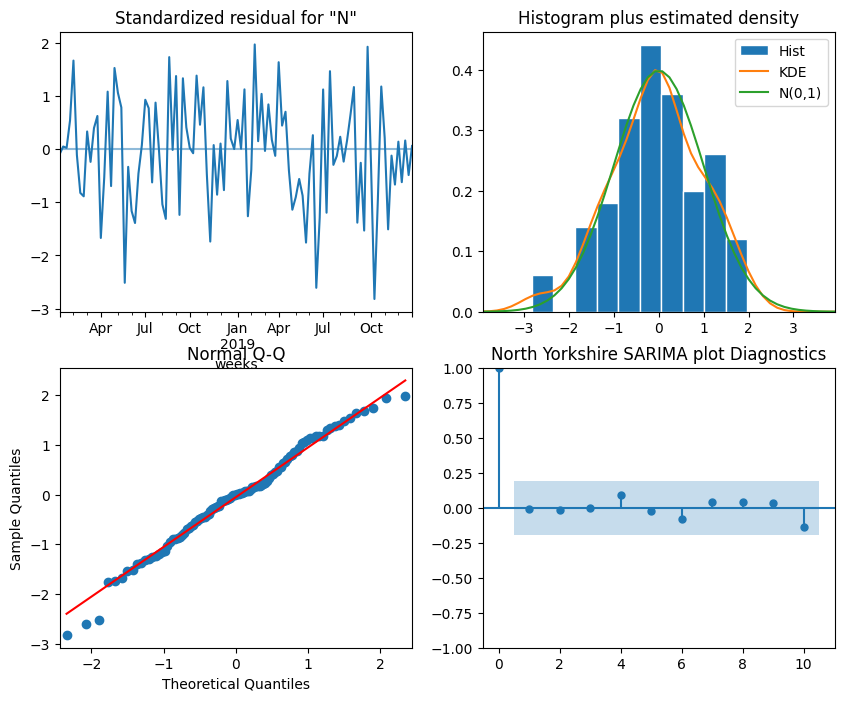

In [236]:
# Plots the Q-Q plot 
NYsarima_model.plot_diagnostics(figsize=(10,8)); 
plt.title('North Yorkshire SARIMA plot Diagnostics')
plt.savefig('34.NY.png')


In [237]:
from statsmodels.stats.diagnostic import acorr_ljungbox 

acorr_ljungbox(NYsarima_model.resid)


lb_stat  lb_pvalue
1    2.055586   0.151649
2    2.069658   0.355287
3    2.252387   0.521704
4    3.828350   0.429734
5    5.127704   0.400495
6    5.642248   0.464433
7    6.584369   0.473397
8    6.674643   0.572108
9    7.473013   0.587996
10  11.068456   0.352210

In [238]:
NYsarima_pred = NYsarima_model.get_forecast(len_test)
NYsarima_pred = NYsarima_pred.predicted_mean 


In [239]:
# Assiging the prediction to the test set dataframe 
NYtest['NYsarima_pred'] = NYsarima_pred  # assign sarima pred to the test dataframe as well
NYtest.head()

North Yorkshire  NYnaive_pred  NYarima_pred  NYsarima_pred
weeks                                                                 
2020-01-06             19.0          32.0     17.983276      20.814144
2020-01-13             24.0          24.0     18.400934      14.360201
2020-01-20             39.0          33.0     18.386210      19.073536
2020-01-27             25.0          24.0     18.386729      18.292366
2020-02-03             31.0          21.0     18.386711      12.079015

In [240]:
 # Using Passengers and sarima_pred from the test dataframe
NYsarima_mse = mean_squared_error(NYtest['North Yorkshire'],NYtest['NYsarima_pred']) 
NYsarima_rmse = np.sqrt(NYsarima_mse)  # Take the square root to get RMSE
NYsarima_rmse

11.73184782084118

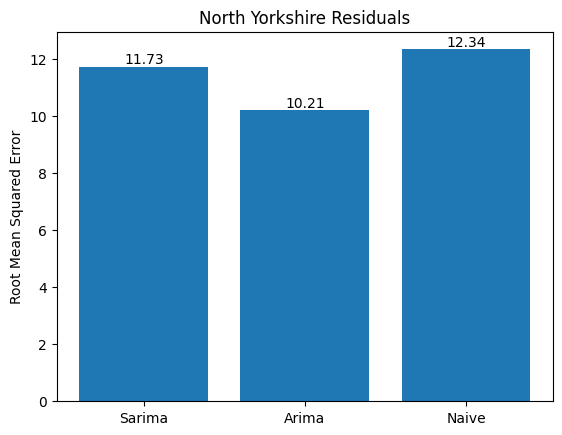

In [241]:
list_rmse = [NYsarima_rmse,NYarima_rmse,NYnaive_rmse]  # get y_values or actual values
models = ['Sarima','Arima', 'Naive'] # get x_values or strings

plt.bar(x=models,height=list_rmse) 
plt.ylabel('Root Mean Squared Error')
plt.title('North Yorkshire Residuals')

for i, value in enumerate(list_rmse): 
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom') 
plt.savefig('35.NY.png')
plt.show()


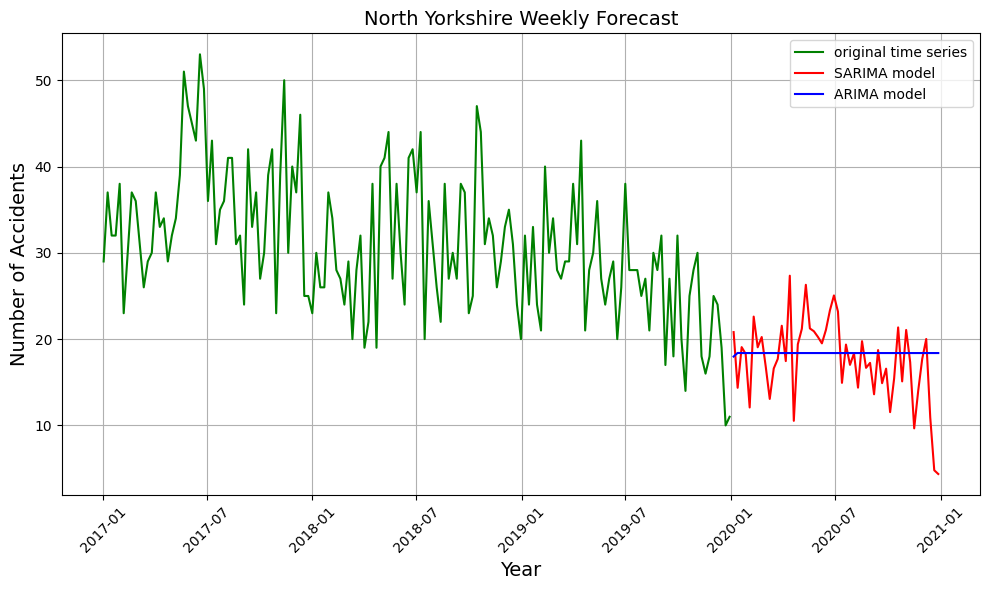

In [242]:

                                           # Plotting the forecast time series
plt.figure(figsize=(10, 6))
plt.plot(NYtrain, linestyle='-', label='original time series', color='g') # original time series

plt.plot(NYtest["NYsarima_pred"], linestyle='-' , label='SARIMA model', color = 'r') # plot showing ARIMA predictions made

plt.plot(NYtest["NYarima_pred"], linestyle='-' , label='ARIMA model', color = 'b') # plot showing NAIVE predictions made


# Adding titles and labels
plt.title("North Yorkshire Weekly Forecast", fontsize=14)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Accidents", fontsize=14)

# Show plot
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('36.NY.png')
plt.show()


## PART 3 : West Yorkshire

In [243]:
WY=ts[['West Yorkshire']]
WY.head()

West Yorkshire
weeks                     
2017-01-02              69
2017-01-09              83
2017-01-16              91
2017-01-23              87
2017-01-30              94

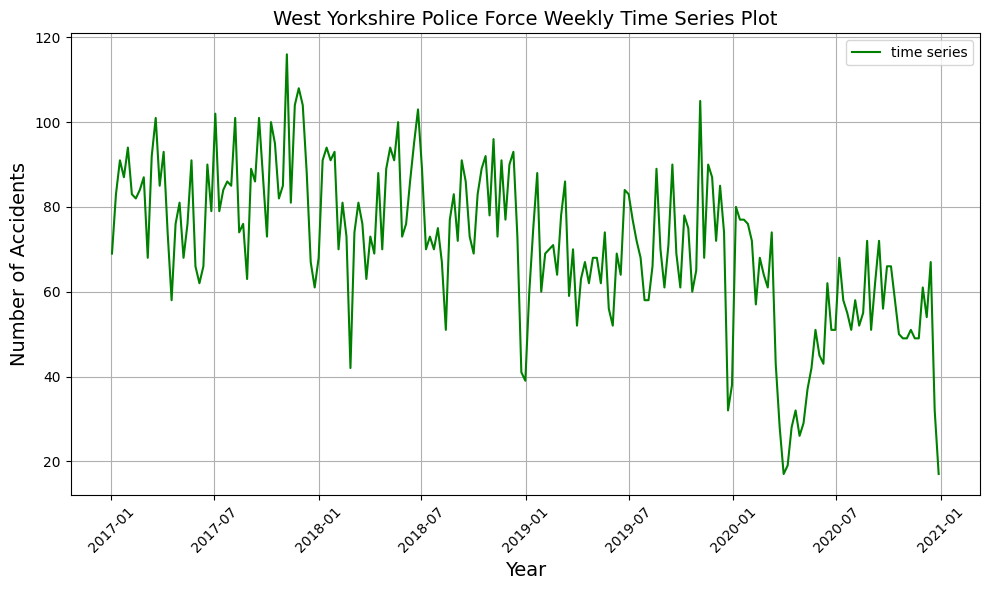

In [244]:
# Plotting the time series
plt.figure(figsize=(10, 6))
plt.plot(WY, linestyle='-',label='time series', color='g')

# Adding titles and labels
plt.title("West Yorkshire Police Force Weekly Time Series Plot", fontsize=14)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Accidents", fontsize=14)

# Show plot
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('37.WY.png')
plt.show()

In [246]:
WY_resampled = WY.resample(Week(weekday=0)).mean().interpolate(method='linear') 
#WY_resampled

<Figure size 1400x600 with 0 Axes>

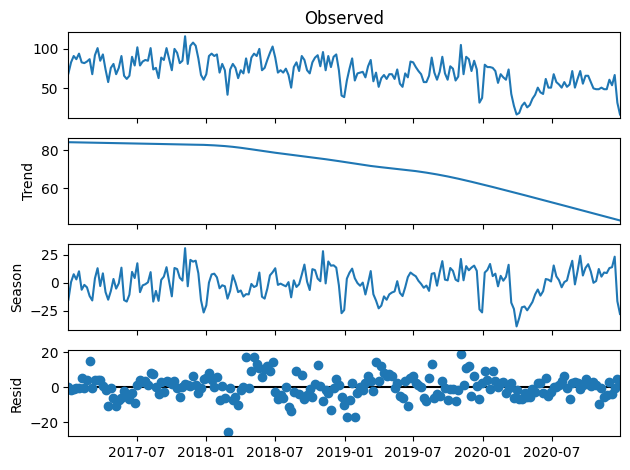

In [247]:
# Perform STL decomposition
stl = STL(WY_resampled, )  # seasonal is the window size for seasonality
result = stl.fit()

# Plot the decomposition
plt.figure(figsize=(14, 6))
result.plot()
plt.savefig('38.WY.png')
plt.show()

<Figure size 1400x1000 with 0 Axes>

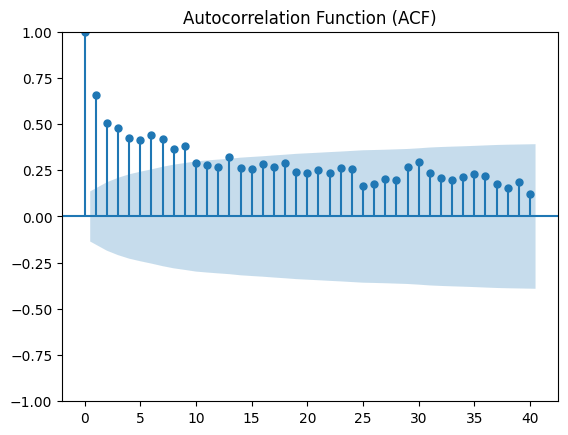

<Figure size 1400x1000 with 0 Axes>

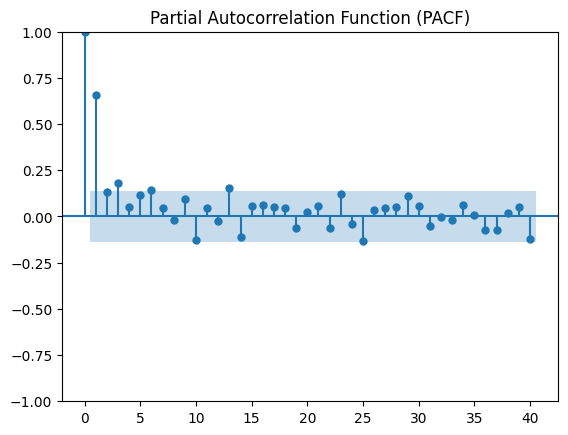

In [248]:

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

    # PLOT ACF PLOT
plt.figure(figsize=(14,10))
plot_acf(WY_resampled, lags= 40)
plt.title("Autocorrelation Function (ACF)")
plt.savefig('39.WY.png')
plt.show()

    #PLOT PACF PLOT
plt.figure(figsize=(14,10))
plot_pacf(WY_resampled,lags = 40)
plt.title("Partial Autocorrelation Function (PACF)")
plt.savefig('40.WY.png')
plt.show()

In [249]:
 # Apply trend differencing to original series
difff1 = WY_resampled.diff(1).dropna()

# Show the differenced series
difff1


 # Apply seasonal differencing 
difff2 = difff1.diff(52).dropna()  # biennal seasonality

# Show the differenced series
difff2


West Yorkshire
weeks                     
2018-01-08             9.0
2018-01-15            -5.0
2018-01-22             1.0
2018-01-29            -5.0
2018-02-05           -12.0
...                    ...
2020-11-30            27.0
2020-12-07           -20.0
2020-12-14            24.0
2020-12-21             7.0
2020-12-28           -21.0

[156 rows x 1 columns]

In [250]:

from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller (ADF) test
ADF_test3 =  adfuller(difff2)[:2]
print(f"ADF Statistic: {ADF_test3[0]:.2f} ; p-value: {ADF_test3[1]:.2f}")

# Conclusion based on p-value
if ADF_test3[1]< 0.05:
    print("The time series is stationary (reject H₀).")
else:
    print("The time series is non-stationary (fail to reject H₀).")


ADF Statistic: -15.02 ; p-value: 0.00
The time series is stationary (reject H₀).


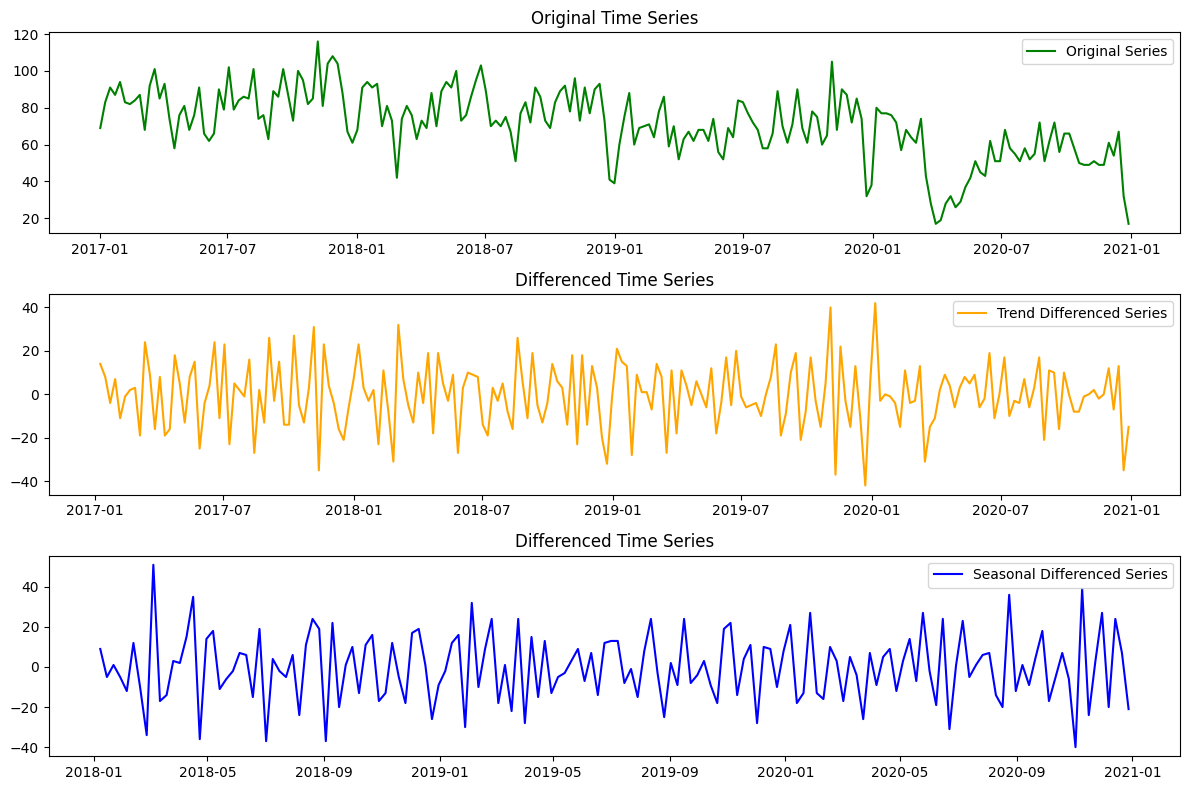

In [251]:
# Plot the original, first differenced, and second differenced series
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(WY_resampled, label='Original Series',color='g')
plt.title('Original Time Series')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(difff1, label='Trend Differenced Series', color='orange')
plt.title('Differenced Time Series')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(difff2, label='Seasonal Differenced Series', color='blue')
plt.title('Differenced Time Series')
plt.legend()

plt.tight_layout()
plt.savefig("41.WY.png")
plt.show()


<Figure size 1400x1000 with 0 Axes>

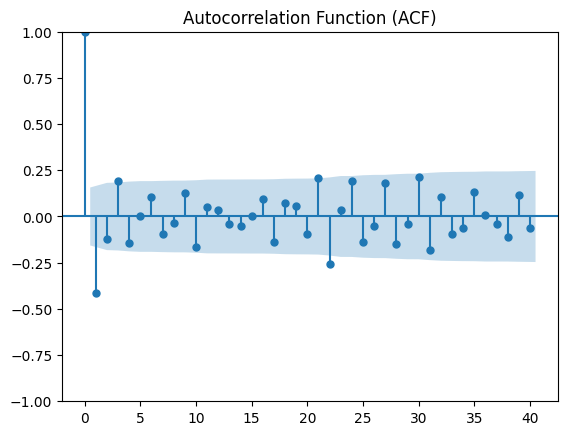

<Figure size 1400x1000 with 0 Axes>

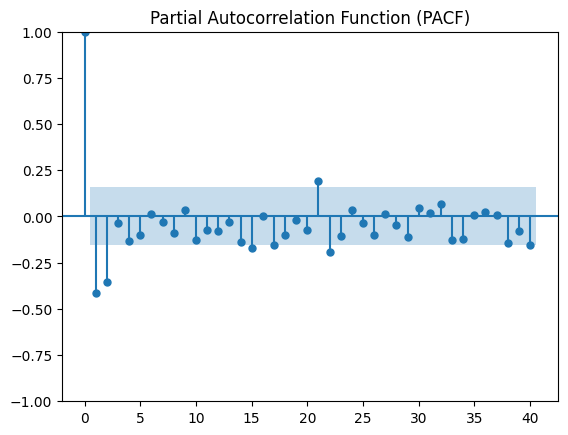

In [252]:
# Check for over-differencing
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

 # PLOT ACF PLOT
plt.figure(figsize=(14,10))
plot_acf(difff2, lags= 40)
plt.title("Autocorrelation Function (ACF)")
plt.savefig('42.WY.png')
plt.show()


 #PLOT PACF PLOT
plt.figure(figsize=(14,10))
plot_pacf(difff2,lags = 40)
plt.title("Partial Autocorrelation Function (PACF)")
plt.savefig('43.WY.png')
plt.show()

In [253]:
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Defining the parameter ranges
ps = np.arange(1, 12, 1)  # order of AR
qs = np.arange(1, 12, 1)  # order of MA
Ps = [0]  # seasonal AR order
Qs = [0]  # seasonal MA order
d = 1  # number of times the series is differenced to attain stationarity
D = 0  # Seasonal differencing
s = 52  # seasonal period (annual pattern for monthly time series data)

 # Generate all combinations of p, q, P, Q
p_q_list = list(product(ps, qs, Ps, Qs))
print(f"Generated parameter combinations: {p_q_list[:5]}")  # Check parameter combinations
 # [:5] - inidicates a selection range 
 # start from begining to the fifth [where index=4 i.e 0-4]
 # no value before the colon means start from begining.
 
 # [5:] - from index 5 untill the end.
 # [start:end] 
 # Put combinations in a list
df_p_q_list=pd.DataFrame(p_q_list,columns=["AR(p)","MA(q)","AR(Ps)","MA(Qs)"])
df_p_q_list


Generated parameter combinations: [(1, 1, 0, 0), (1, 2, 0, 0), (1, 3, 0, 0), (1, 4, 0, 0), (1, 5, 0, 0)]


AR(p)  MA(q)  AR(Ps)  MA(Qs)
0        1      1       0       0
1        1      2       0       0
2        1      3       0       0
3        1      4       0       0
4        1      5       0       0
..     ...    ...     ...     ...
116     11      7       0       0
117     11      8       0       0
118     11      9       0       0
119     11     10       0       0
120     11     11       0       0

[121 rows x 4 columns]

In [254]:
# Function to get the best AIC values
def aic_values(target):
    """This function accepts a series and returns 
    the AIC values"""  
    list_of_aic = [] 

    for order in p_q_list:
        try:
            model = SARIMAX(
                endog=target,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s), 
                simple_differencing=False
            ).fit(disp=False)
            
            list_of_aic.append([order, model.aic])
        
        except Exception as e:
            print(f"Error for order {order}: {e}")
            continue 

    aic_df = pd.DataFrame(list_of_aic, columns=['Order(p,q,Ps,QS)', 'AIC']) 
    aic_df.sort_values(by='AIC', ascending=True, inplace=True) #sort values
    
    return aic_df


aic_df = aic_values(WY_resampled['West Yorkshire'])
aic_df

C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

Order(p,q,Ps,QS)          AIC
85      (8, 9, 0, 0)  1660.953422
16      (2, 6, 0, 0)  1661.307779
17      (2, 7, 0, 0)  1661.839972
61      (6, 7, 0, 0)  1661.942301
27      (3, 6, 0, 0)  1661.964877
..               ...          ...
106    (10, 8, 0, 0)  1677.047179
97     (9, 10, 0, 0)  1677.365993
116    (11, 7, 0, 0)  1677.819797
104    (10, 6, 0, 0)  1679.773710
118    (11, 9, 0, 0)  1680.409190

[121 rows x 2 columns]

### WEST YORKSHIRE ARIMA MODEL

In [256]:
### Build and evaluate model

WYtrain=WY_resampled[:-52]    # Use all years 2017-2019
WYtest=WY_resampled[-52:]   # Use 2020 for testing
WYtrain.head()


West Yorkshire
weeks                     
2017-01-02            69.0
2017-01-09            83.0
2017-01-16            91.0
2017-01-23            87.0
2017-01-30            94.0

In [257]:
WYarima_model = SARIMAX(endog=WYtrain, order=(8,1,9)).fit()
WYarima_model.summary()

C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         West Yorkshire   No. Observations:                  157
Model:               SARIMAX(8, 1, 9)   Log Likelihood                -611.029
Date:                Tue, 01 Apr 2025   AIC                           1258.058
Time:                        14:54:29   BIC                           1312.956
Sample:                    01-02-2017   HQIC                          1280.355
                         - 12-30-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6949      0.439     -1.584      0.113      -1.555       0.165
ar.L2         -0.3711      0.718     -0.517      0.605      -1.778       1.036
ar.L3         -0.3771      0.883     -0.427      0.669      -2.107       1.353
ar.L4          0.1881      1.061      0.177      0.859      -1.892       2.268
ar.L5          0.5230      0.925      0.566      0.572      -1.289       2.335
ar.L6          0.4728      0.694      0.681      0.496      -0.887       1.832
ar.L7          0.7049      0.570      1.238      0.216      -0.411       1.821
ar.L8          0.3135      0.291      1.077      0.281      -0.257       0.884
ma.L1          0.1965      0.572      0.343      0.731      -0.925       1.318
ma.L2         -0.3263      0.545     -0.599      0.549      -1.395       0.742
ma.L3         -0.0409      0.524     -0.078      0.938      -1.067       0.985
ma.L4         -0.5909      0.557     -1.061      0.289      -1.683       0.501
ma.L5         -0.8186      0.622     -1.316      0.188      -2.038       0.401
ma.L6         -0.0917      0.424     -0.216      0.829      -0.923       0.740
ma.L7         -0.2823      0.325     -0.869      0.385      -0.919       0.355
ma.L8          0.2286      0.479      0.477      0.633      -0.710       1.167
ma.L9          0.7497      0.490      1.531      0.126      -0.210       1.710
sigma2       134.5821     61.411      2.191      0.028      14.219     254.945
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.74
Prob(Q):                              0.89   Prob(JB):                         0.42
Heteroskedasticity (H):               1.11   Skew:                            -0.10
Prob(H) (two-sided):                  0.70   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

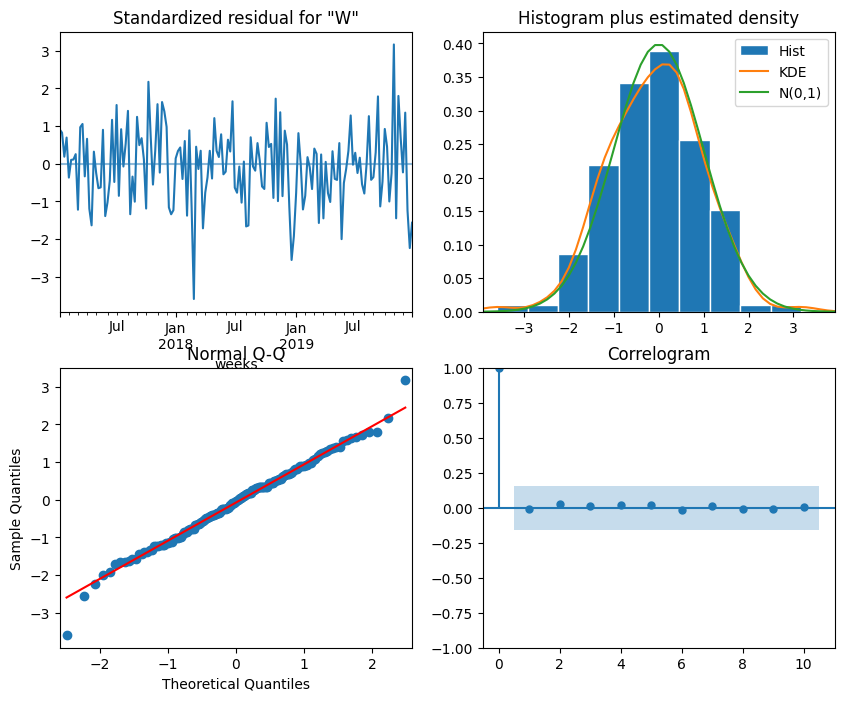

In [258]:
# Plots the Q-Q plot 
WYarima_model.plot_diagnostics(figsize=(10,8));
plt.savefig('44.WY.png')

In [259]:
from statsmodels.stats.diagnostic import acorr_ljungbox 
acorr_ljungbox(WYarima_model.resid)

lb_stat  lb_pvalue
1   0.143852   0.704481
2   0.652223   0.721725
3   0.722066   0.868002
4   0.976908   0.913277
5   0.982780   0.963943
6   0.986171   0.986131
7   1.052827   0.993931
8   1.054453   0.997880
9   1.298984   0.998381
10  1.544285   0.998791

In [260]:
len_test = len(NYtest)  
len_test

 #Prediction with ARIMA model 
WYarima_pred = WYarima_model.get_forecast(len_test).predicted_mean.values
WYarima_pred

array([65.93314135, 55.96431768, 75.98120978, 67.72139141, 77.30534287,
       65.93598306, 64.59781219, 68.37815819, 65.69305961, 76.61487681,
       67.38067658, 69.56032539, 63.18314463, 68.21858588, 71.21499527,
       69.70468597, 70.17541789, 64.83557491, 67.76566273, 67.38500234,
       70.84150405, 69.69405356, 67.20783418, 66.85285309, 66.67474284,
       69.67138003, 69.00518355, 68.83085911, 66.94933933, 66.76333065,
       67.98476305, 68.71309383, 69.12024829, 67.4746661 , 67.10379768,
       67.12565649, 68.18269016, 68.6302287 , 68.07702542, 67.44428829,
       66.92314013, 67.59884534, 68.09014054, 68.24965009, 67.65798326,
       67.13044847, 67.23650479, 67.62239007, 68.03111985, 67.78871801,
       67.39074964, 67.11474288])

In [261]:
WYnaive_pred = WY_resampled['West Yorkshire'][len(WYtrain)-52:len(WYtrain)].values 
WYnaive_pred


array([ 60.,  75.,  88.,  60.,  69.,  70.,  71.,  64.,  78.,  86.,  59.,
        70.,  52.,  63.,  67.,  62.,  68.,  68.,  62.,  74.,  56.,  52.,
        69.,  64.,  84.,  83.,  77.,  72.,  68.,  58.,  58.,  66.,  89.,
        70.,  61.,  71.,  90.,  69.,  61.,  78.,  75.,  60.,  65., 105.,
        68.,  90.,  87.,  72.,  85.,  74.,  32.,  38.])

In [262]:

# Assign predictions dataframe called test
WYtest['WYnaive_pred'] = WYnaive_pred 
WYtest['WYarima_pred'] = WYarima_pred

# View test dataframe
WYtest.head()


C:\Users\Hp\AppData\Local\Temp\ipykernel_21824\4164986238.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WYtest['WYnaive_pred'] = WYnaive_pred
C:\Users\Hp\AppData\Local\Temp\ipykernel_21824\4164986238.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WYtest['WYarima_pred'] = WYarima_pred


West Yorkshire  WYnaive_pred  WYarima_pred
weeks                                                 
2020-01-06            80.0          60.0     65.933141
2020-01-13            77.0          75.0     55.964318
2020-01-20            77.0          88.0     75.981210
2020-01-27            76.0          60.0     67.721391
2020-02-03            72.0          69.0     77.305343

In [263]:
from sklearn.metrics import mean_squared_error

 # actual value vs predicted value
WYarima_mse = mean_squared_error(WYtest['West Yorkshire'], WYtest['WYarima_pred'])  # Calculate MSE
WYarima_rmse = np.sqrt(WYarima_mse)  # Take the square root to get RMSE

WYnaive_mse = mean_squared_error(WYtest['West Yorkshire'], WYtest['WYnaive_pred'])  # Calculate MSE
WYnaive_rmse = np.sqrt(WYnaive_mse)  # Take the square root to get RMSE


### WEST YORKSHIRE SARIMA model

In [264]:
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Defining the parameter ranges
ps = np.arange(1, 3, 1)  # AR order from 1 to 2
qs = np.arange(1, 3, 1)  # MA order from 1 to 2
Ps = np.arange(1,3,1)  # Seasonal AR order
Qs = np.arange(1,3,1)  # Seasonal MA order
d = [1]  # Differencing from 1 to 2
D = [1]  # Seasonal differencing from 0 to 1
s = 52  # seasonal period (annual pattern for monthly time series data)

 # Generate all combinations of p, q, P, Q, d, D
p_q_list = list(product(ps, qs, Ps, Qs, d, D))  # Using np.arange for d and D
#print(f"Generated parameter combinations: {p_q_list[:5]}")  # Check parameter combinations
 
 # Put combinations in a list
df_p_q_list=pd.DataFrame(p_q_list,columns=["AR(p)","MA(q)","AR(Ps)","MA(Qs)","d","D"])
df_p_q_list



AR(p)  MA(q)  AR(Ps)  MA(Qs)  d  D
0       1      1       1       1  1  1
1       1      1       1       2  1  1
2       1      1       2       1  1  1
3       1      1       2       2  1  1
4       1      2       1       1  1  1
5       1      2       1       2  1  1
6       1      2       2       1  1  1
7       1      2       2       2  1  1
8       2      1       1       1  1  1
9       2      1       1       2  1  1
10      2      1       2       1  1  1
11      2      1       2       2  1  1
12      2      2       1       1  1  1
13      2      2       1       2  1  1
14      2      2       2       1  1  1
15      2      2       2       2  1  1

In [265]:
# Function to get the best AIC values
def aic_values(target):
    """This function accepts a series and returns the AIC values"""  
    list_of_aic = [] 

    for order in p_q_list:
        try:
            model = SARIMAX(
                endog=target,
                order=(order[0], order[4], order[1]),  # AR, differencing, MA
                seasonal_order=(order[2], order[5], order[3], s),  # Seasonal AR, differencing, MA, seasonal period
                simple_differencing=False
            ).fit(disp=False)
            
            list_of_aic.append([order, model.aic])
        
        except Exception as e:
            print(f"Error for order {order}: {e}")
            continue 

    # Create a DataFrame from the list of AIC values
    aic_df = pd.DataFrame(list_of_aic, columns=['Order(p,q,Ps,QS,d,D)', 'AIC'])
    # Sort values by AIC in ascending order (lower AIC is better)
    aic_df.sort_values(by='AIC', ascending=True, inplace=True)
    
    return aic_df



aic_df = aic_values(WY_resampled['West Yorkshire'])
aic_df


C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Hp\AppData\Local\Programs\Py

Order(p,q,Ps,QS,d,D)          AIC
8    (2, 1, 1, 1, 1, 1)  1261.536498
4    (1, 2, 1, 1, 1, 1)  1261.869005
0    (1, 1, 1, 1, 1, 1)  1262.843660
10   (2, 1, 2, 1, 1, 1)  1263.382048
9    (2, 1, 1, 2, 1, 1)  1263.534274
6    (1, 2, 2, 1, 1, 1)  1263.707694
5    (1, 2, 1, 2, 1, 1)  1263.798065
12   (2, 2, 1, 1, 1, 1)  1263.970601
2    (1, 1, 2, 1, 1, 1)  1264.777752
1    (1, 1, 1, 2, 1, 1)  1264.843738
11   (2, 1, 2, 2, 1, 1)  1265.180427
7    (1, 2, 2, 2, 1, 1)  1265.471620
14   (2, 2, 2, 1, 1, 1)  1265.839333
13   (2, 2, 1, 2, 1, 1)  1265.949204
3    (1, 1, 2, 2, 1, 1)  1266.636205
15   (2, 2, 2, 2, 1, 1)  1267.665234

In [266]:
WYsarima_model = SARIMAX(endog=WYtrain, order=(2, 1, 1),seasonal_order=(1, 1, 1, 52)).fit()
WYsarima_model.summary()


C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     West Yorkshire   No. Observations:                  157
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -414.216
Date:                            Tue, 01 Apr 2025   AIC                            840.433
Time:                                    15:22:18   BIC                            856.299
Sample:                                01-02-2017   HQIC                           846.861
                                     - 12-30-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2451      0.102      2.394      0.017       0.044       0.446
ar.L2          0.0337      0.112      0.302      0.763      -0.185       0.253
ma.L1         -0.9976      0.481     -2.072      0.038      -1.941      -0.054
ar.S.L52      -0.9877      3.371     -0.293      0.770      -7.596       5.620
ma.S.L52       0.8481     19.781      0.043      0.966     -37.922      39.618
sigma2       105.3033   1707.465      0.062      0.951   -3241.267    3451.874
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.84   Prob(JB):                         1.00
Heteroskedasticity (H):               0.48   Skew:                            -0.02
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

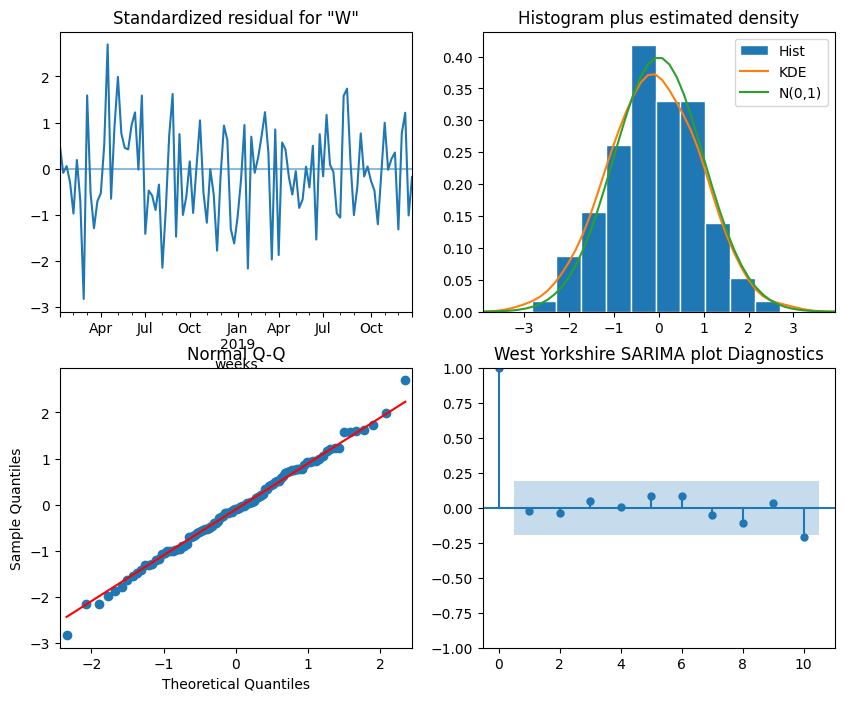

In [267]:
# Plots the Q-Q plot 
WYsarima_model.plot_diagnostics(figsize=(10,8)); 
plt.title('West Yorkshire SARIMA plot Diagnostics')
plt.savefig('45.WY.png')


In [268]:
from statsmodels.stats.diagnostic import acorr_ljungbox 

acorr_ljungbox(WYsarima_model.resid)

lb_stat  lb_pvalue
1    1.846128   0.174234
2    1.847331   0.397061
3    2.131421   0.545582
4    2.310443   0.678868
5    2.430789   0.786880
6    3.016762   0.806740
7    3.723172   0.811053
8    6.942799   0.542817
9    8.331279   0.501137
10  10.147277   0.427669

In [269]:

WYsarima_pred = WYsarima_model.get_forecast(len_test)
WYsarima_pred = WYsarima_pred.predicted_mean 


# Assiging the prediction to the test set dataframe 
WYtest['WYsarima_pred'] = WYsarima_pred  # assign sarima pred to the test dataframe as well
WYtest.head()


C:\Users\Hp\AppData\Local\Temp\ipykernel_21824\3152979282.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WYtest['WYsarima_pred'] = WYsarima_pred  # assign sarima pred to the test dataframe as well


West Yorkshire  WYnaive_pred  WYarima_pred  WYsarima_pred
weeks                                                                
2020-01-06            80.0          60.0     65.933141      64.926471
2020-01-13            77.0          75.0     55.964318      74.819904
2020-01-20            77.0          88.0     75.981210      82.884556
2020-01-27            76.0          60.0     67.721391      63.642278
2020-02-03            72.0          69.0     77.305343      57.674475

In [270]:
WYsarima_mse = mean_squared_error(WYtest['West Yorkshire'],WYtest['WYsarima_pred']) 
WYsarima_rmse = np.sqrt(WYsarima_mse)  # Take the square root to get RMSE
WYsarima_rmse


21.039382887671582

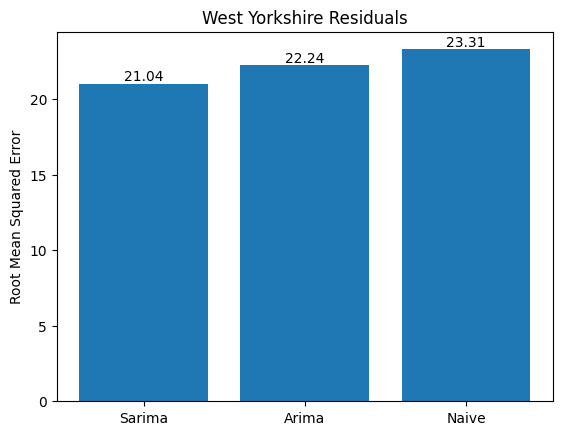

In [272]:

list_rmse = [WYsarima_rmse,WYarima_rmse,WYnaive_rmse]  # get y_values or actual values
models = ['Sarima','Arima', 'Naive'] # get x_values or strings

plt.bar(x=models,height=list_rmse) 
plt.ylabel('Root Mean Squared Error')
plt.title('West Yorkshire Residuals')

for i, value in enumerate(list_rmse): 
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom') 
plt.savefig('46.WY.png')
plt.show()


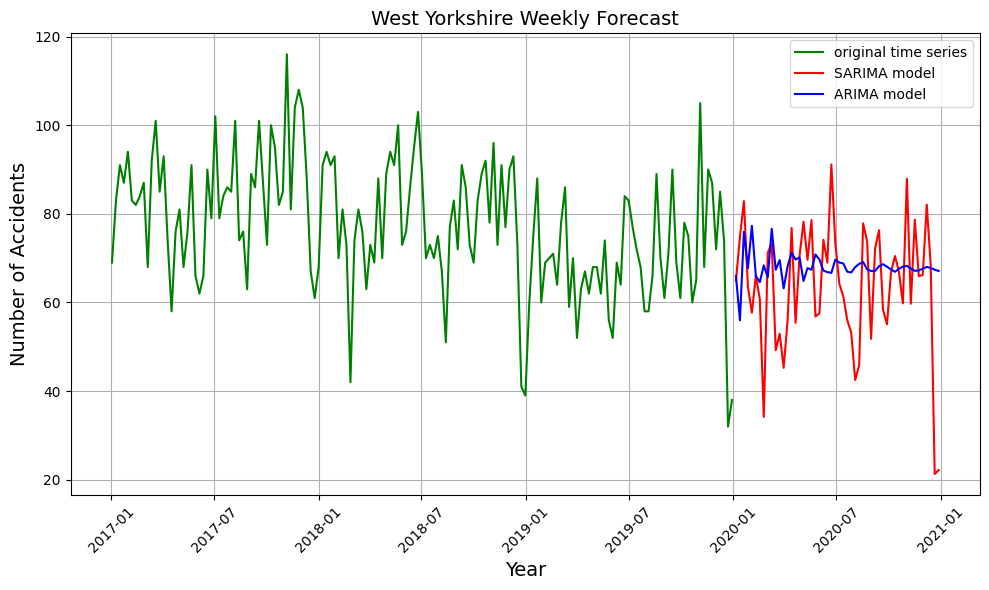

In [273]:
 # Forecast plot 
plt.figure(figsize=(10, 6))
plt.plot(WYtrain, linestyle='-', label='original time series', color='g') # original time series

plt.plot(WYtest["WYsarima_pred"], linestyle='-' , label='SARIMA model', color = 'r') # plot showing ARIMA predictions made

plt.plot(WYtest["WYarima_pred"], linestyle='-' , label='ARIMA model', color = 'b') # plot showing NAIVE predictions made


# Adding titles and labels
plt.title("West Yorkshire Weekly Forecast", fontsize=14)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Accidents", fontsize=14)

# Show plot
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('47.WY.png')
plt.show()




### 7. Identify the three Local Super Output Areas (LSOAs) of Hull city that recorded the highest number of road accidents in the first three months of 2020.

then employ a time series model to forecast daily accident occurrences for the upcoming month (e.g., July), leveraging data from the preceding six months (e.g., January to June) for these high-incident areas.


In [10]:
pd.set_option('display.max_columns',None)
ac_df.head()

accident_index  accident_year accident_reference  location_easting_osgr  \
0  2020010219808           2020          010219808               521389.0   
1  2020010220496           2020          010220496               529337.0   
2  2020010228005           2020          010228005               526432.0   
3  2020010228006           2020          010228006               538676.0   
4  2020010228011           2020          010228011               529324.0   

   location_northing_osgr  longitude   latitude  police_force  \
0                175144.0  -0.254001  51.462262             1   
1                176237.0  -0.139253  51.470327             1   
2                182761.0  -0.178719  51.529614             1   
3                184371.0  -0.001683  51.541210             1   
4                181286.0  -0.137592  51.515704             1   

   accident_severity  number_of_vehicles  number_of_casualties        date  \
0                  3                   1                     1  04/02/2020   
1                  3                   1                     2  27/04/2020   
2                  3                   1                     1  01/01/2020   
3                  2                   1                     1  01/01/2020   
4                  3                   1                     2  01/01/2020   

   day_of_week   time  local_authority_district local_authority_ons_district  \
0            3  09:00                        10                    E09000032   
1            2  13:55                         9                    E09000022   
2            4  01:25                         1                    E09000033   
3            4  01:50                        17                    E09000025   
4            4  02:25                         1                    E09000033   

  local_authority_highway  first_road_class  first_road_number  road_type  \
0               E09000032                 6                  0          6   
1               E09000022                 3               3036          6   
2               E09000033                 5                  0          6   
3               E09000025                 3                 11          6   
4               E09000033                 3                 40          6   

   speed_limit  junction_detail  junction_control  second_road_class  \
0           20                0                -1                  0   
1           20                9                 2                  6   
2           30                3                 1                  6   
3           30                0                -1                  0   
4           30                3                 4                  5   

   second_road_number  pedestrian_crossing_human_control  \
0                  -1                                  9   
1                   0                                  0   
2                   0                                  0   
3                  -1                                  0   
4                   0                                  0   

   pedestrian_crossing_physical_facilities  light_conditions  \
0                                        9                 1   
1                                        4                 1   
2                                        0                 4   
3                                        4                 4   
4                                        0                 4   

   weather_conditions  road_surface_conditions  special_conditions_at_site  \
0                   9                        9                           0   
1                   1                        1                           0   
2                   1                        2                           0   
3                   1                        1                           0   
4                   1                        1                           0   

   carriageway_hazards  urban_or_rural_area  \
0                    0                  

In [6]:
ls_df.head()

objectid   lsoa01cd             lsoa01nm            lsoa01nmw  \
0         1  E01000001  City of London 001A  City of London 001A   
1         2  E01000002  City of London 001B  City of London 001B   
2         3  E01000003  City of London 001C  City of London 001C   
3         4  E01000004  City of London 001D  City of London 001D   
4         5  E01000005  City of London 001E  City of London 001E   

    shape__area  shape__length                              globalid  
0  1.298652e+05    2635.772001  68cc6127-1008-4fbe-a16c-78fb089a7c43  
1  2.284189e+05    2707.986202  937edbc3-c1bf-4d35-b274-b0a1480a7c09  
2  5.905477e+04    1224.774479  2686dcaf-10b9-4736-92af-4788d4feaa69  
3  2.544551e+06   10718.466240  3c493140-0b3f-4b9a-b358-22011dc5fb89  
4  1.895782e+05    2275.809358  b569093d-788d-41be-816c-d6d7658b2311

In [261]:
# Connect to Database
con = sqlite3.connect("accident_data_v1.0.0_2023.db")
cur = con.cursor()

# Execute the query
cur.execute("""
    SELECT 
          lsoa_of_accident_location AS lsoa_code,
          COUNT(*) AS accident_count
          
    FROM accident
  
    WHERE accident_year = 2020
        AND SUBSTR(date,4,2) IN ('01','02','03')
        AND local_authority_district = 228
         
    GROUP BY lsoa_of_accident_location
    ORDER BY accident_count DESC
    LIMIT 3
""")

 # GROUP BY  - is used with COUNT(*) 
 # COUNT(*) - aggregates each unique entry , 
 # without GROUP BY, it will count all values and not distinct/unique values and return a single figure. 

# Fetch results
top_lsoas = cur.fetchall()

# Convert to DataFrame
headers = [description[0] for description in cur.description]
top_lsoas_df = pd.DataFrame(top_lsoas, columns=headers)

# Close database connection
con.close()

# Display the results
print("The top three Lower Super Output Areas of Hull that recorded the highest number of accidents from January to March: ")
top_lsoas_df

The top three Lower Super Output Areas of Hull that recorded the highest number of accidents from January to March: 


lsoa_code  accident_count
0  E01012817              10
1  E01012889               7
2  E01012848               7

In [262]:
# Connect to Database
con = sqlite3.connect("accident_data_v1.0.0_2023.db")
cur = con.cursor()

# Execute the query
cur.execute("""
    SELECT 
          date,
          COUNT(*) as daily_accidents
          
    FROM accident
    
    WHERE accident_year = 2020 
        AND local_authority_district = 228
        AND SUBSTR(date,4,2) IN ('01','02','03','04','05','06','07')
        AND lsoa_of_accident_location IN ('E01012817','E01012889','E01012848')

    GROUP BY date
""")
# COUNT(*) - Count all accidents 
# GROUP BY date - Ensures counting applies to unique dates values
# This way, COUNT(*) does not return a single value of all accidents in the querry results

# Fetch results
top_lsoas_day = cur.fetchall()

# Convert to DataFrame
headers = [description[0] for description in cur.description]
top_lsoas_day_df = pd.DataFrame(top_lsoas_day, columns=headers)

# Close database connection
con.close()

# Display the results
top_lsoas_day_df.head()

date  daily_accidents
0  01/05/2020                1
1  02/01/2020                2
2  03/01/2020                1
3  03/02/2020                1
4  09/06/2020                1

**Date values need to be sorted**

In [263]:
 # Convert the 'date' column to datetime format for sorting
day_ts = top_lsoas_day_df

day_ts['date'] = pd.to_datetime(day_ts['date'], format='%d/%m/%Y')

In [264]:
# Sort by 'date' in ascending order
day_ts = day_ts.sort_values(by='date', ascending=True)

# Display the sorted results
day_ts.head()

date  daily_accidents
1  2020-01-02                2
2  2020-01-03                1
5  2020-01-10                2
9  2020-01-13                1
15 2020-01-17                1

In [265]:
day_ts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 1 to 27
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             30 non-null     datetime64[ns]
 1   daily_accidents  30 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 720.0 bytes


In [266]:
 # Set 'date' column as the index and drops the original index( Modifies old dataframe)
day_ts.set_index('date',drop=True, inplace=True)


In [267]:
day_ts

daily_accidents
date                       
2020-01-02                2
2020-01-03                1
2020-01-10                2
2020-01-13                1
2020-01-17                1
2020-01-22                2
2020-01-23                1
2020-02-03                1
2020-02-11                2
2020-02-16                1
2020-02-18                1
2020-02-24                1
2020-02-25                1
2020-02-26                1
2020-02-27                1
2020-03-11                1
2020-03-13                1
2020-03-17                1
2020-03-26                1
2020-03-30                1
2020-04-15                1
2020-04-20                1
2020-05-01                1
2020-06-09                1
2020-06-13                1
2020-06-30                1
2020-07-12                2
2020-07-13                1
2020-07-17                1
2020-07-28                1

**Visualise Time Series Data**

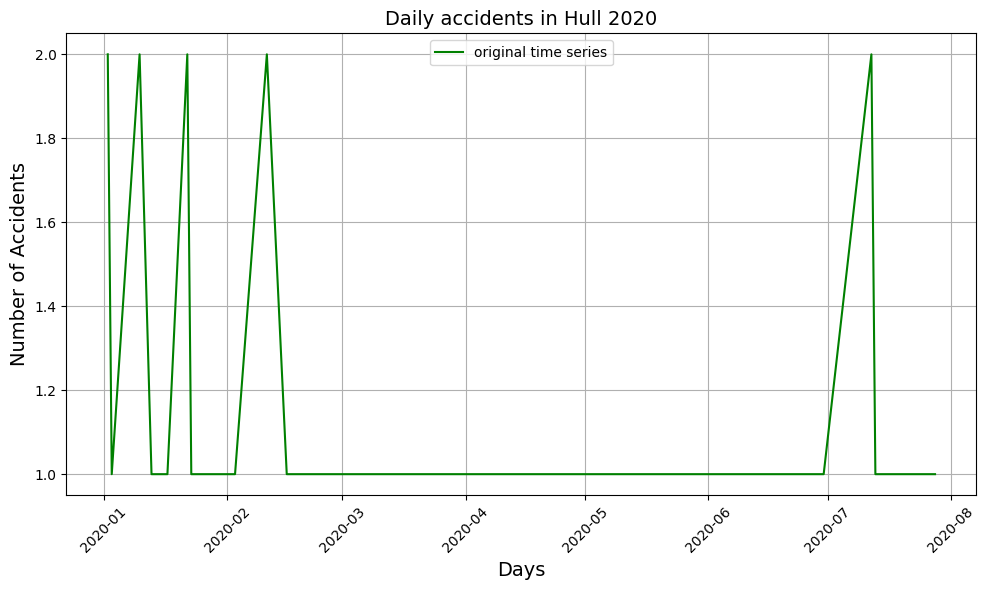

In [268]:
plt.figure(figsize=(10, 6))

plt.plot(day_ts['daily_accidents'], linestyle='-', label='original time series', color='g')

# Adding titles and labels
plt.title("Daily accidents in Hull 2020", fontsize=14)
plt.xlabel("Days", fontsize=14)
plt.ylabel("Number of Accidents", fontsize=14)

# Show plot
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('50.H.png')
plt.show()

C:\Users\Hp\AppData\Local\Temp\ipykernel_12616\45652070.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  day_ts['daily_accidents'].fillna(0, inplace=True)  # fills missing values with 0 assuming there was no accident


<Figure size 1000x600 with 0 Axes>

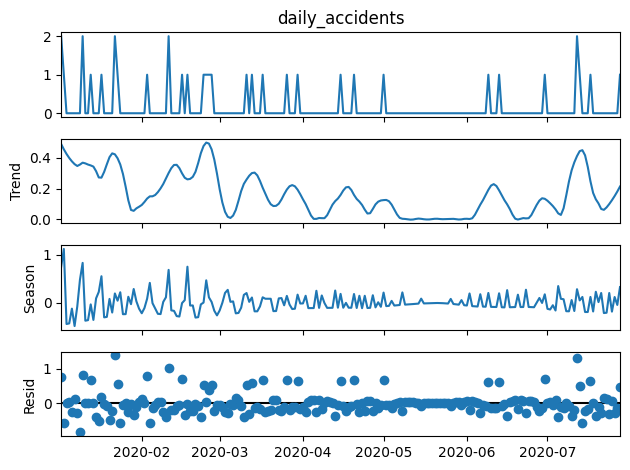

In [269]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL


day_ts = day_ts.asfreq('D')  # Ensures a continuous daily time series
day_ts['daily_accidents'].fillna(0, inplace=True)  # fills missing values with 0 assuming there was no accident

# Perform STL decomposition
stl = STL(day_ts['daily_accidents'], seasonal=7)  # Filling NaNs with 0 if needed
result = stl.fit()

plt.figure(figsize=(10, 6))
result.plot()
plt.savefig('51.H.png')
plt.show()


**Test for Stationarity**

In [145]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller (ADF) test
ADF_test =  adfuller(day_ts)[:2]
print(f"ADF Statistic: {ADF_test[0]:.2f} ; p-value: {ADF_test[1]:.2f}")

# Conclusion based on p-value
if ADF_test[1]< 0.05:
    print("The time series is stationary (reject H₀).")
else:
    print("The time series is non-stationary (fail to reject H₀).")

ADF Statistic: -13.55 ; p-value: 0.00
The time series is stationary (reject H₀).


**Plot ACF and PACF**

<Figure size 1200x500 with 0 Axes>

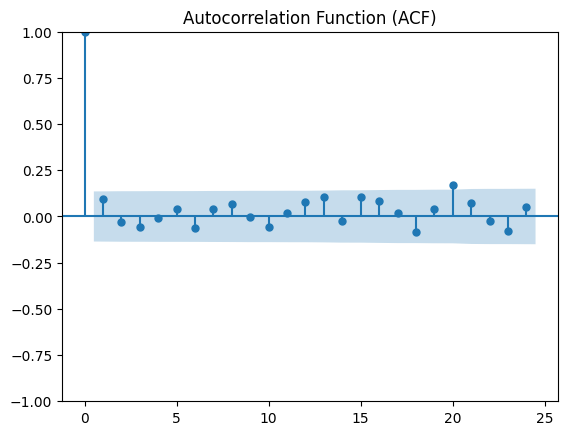

<Figure size 1200x500 with 0 Axes>

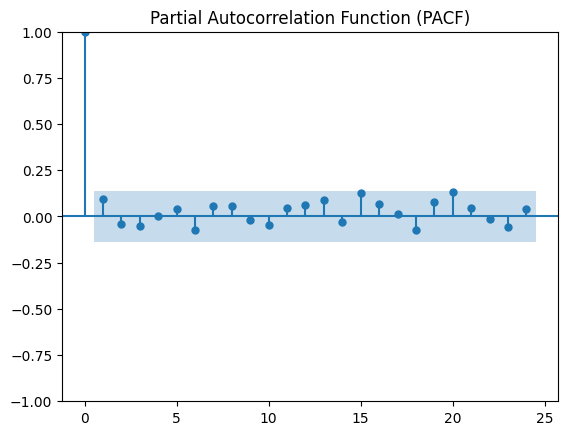

In [146]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


 # PLOT ACF PLOT
plt.figure(figsize=(12,5))
plot_acf(day_ts.dropna())
plt.title("Autocorrelation Function (ACF)")
plt.savefig('52.H.png')
plt.show()


 #PLOT PACF PLOT
plt.figure(figsize=(12,5))
plot_pacf(day_ts.dropna())
plt.title("Partial Autocorrelation Function (PACF)")
plt.savefig('53.H.png')
plt.show()


In [147]:
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Defining the parameter ranges
ps = np.arange(0, 15, 1)  # order of AR
qs = np.arange(0, 15, 1)  # order of MA
Ps = [0]  # seasonal AR order
Qs = [0]  # seasonal MA order
d = 0  # number of times the series is differenced to attain stationarity
D = 0  # Seasonal differencing
s = 365  # seasonal period (annual pattern for monthly time series data)

 # Generate all combinations of p, q, P, Q
p_q_list = list(product(ps, qs, Ps, Qs))
print(f"Generated parameter combinations: {p_q_list[:5]}")  # Check parameter combinations
 # [:5] - inidicates a selection range 
 # start from begining to the fifth [where index=4 i.e 0-4]
 # no value before the colon means start from begining.
 
 # [5:] - from index 5 untill the end.
 # [start:end] 
 # Put combinations in a list
df_p_q_list=pd.DataFrame(p_q_list,columns=["AR(p)","MA(q)","AR(Ps)","MA(Qs)"])
df_p_q_list

Generated parameter combinations: [(0, 0, 0, 0), (0, 1, 0, 0), (0, 2, 0, 0), (0, 3, 0, 0), (0, 4, 0, 0)]


AR(p)  MA(q)  AR(Ps)  MA(Qs)
0        0      0       0       0
1        0      1       0       0
2        0      2       0       0
3        0      3       0       0
4        0      4       0       0
..     ...    ...     ...     ...
220     14     10       0       0
221     14     11       0       0
222     14     12       0       0
223     14     13       0       0
224     14     14       0       0

[225 rows x 4 columns]

In [148]:
# Function to get the best AIC values
def aic_values(target):
    """This function accepts a series and returns 
    the AIC values"""  
    list_of_aic = [] 

    for order in p_q_list:
        try:
            model = SARIMAX(
                endog=target,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s), 
                simple_differencing=False
            ).fit(disp=False)
            
            list_of_aic.append([order, model.aic])
        
        except Exception as e:
            print(f"Error for order {order}: {e}")
            continue 

    aic_df = pd.DataFrame(list_of_aic, columns=['Order(p,q,Ps,QS)', 'AIC']) 
    aic_df.sort_values(by='AIC', ascending=True, inplace=True) #sort values
    
    return aic_df

**Split data into train and test set**

In [160]:
 # all the years before the last month
dtrain = day_ts[["daily_accidents"]][:-28]  # all the days before the last month or exclude month of july

 # predicting the last 12 months
dtest = day_ts[["daily_accidents"]][-28:]  # predicting the month of july

In [161]:
aic_df = aic_values(dtrain)
aic_df

C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non

Order(p,q,Ps,QS)         AIC
16     (1, 1, 0, 0)  210.690388
32     (2, 2, 0, 0)  210.921898
64     (4, 4, 0, 0)  211.017691
67     (4, 7, 0, 0)  212.019900
17     (1, 2, 0, 0)  212.364336
..              ...         ...
29    (1, 14, 0, 0)  235.233811
10    (0, 10, 0, 0)  236.385317
84     (5, 9, 0, 0)  238.165292
11    (0, 11, 0, 0)  238.383458
12    (0, 12, 0, 0)  240.340233

[225 rows x 2 columns]

### Train an ARIMA model

In [164]:
 # AR(11) d=2 I=2 MA(3)
d_arima_model = SARIMAX(endog=dtrain, order=(1, 0,1)).fit()
d_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        daily_accidents   No. Observations:                  181
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -102.345
Date:                Mon, 31 Mar 2025   AIC                            210.690
Time:                        20:12:50   BIC                            220.286
Sample:                    01-02-2020   HQIC                           214.581
                         - 06-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9979      0.005    191.700      0.000       0.988       1.008
ma.L1         -0.9659      0.039    -24.810      0.000      -1.042      -0.890
sigma2         0.1799      0.022      8.334      0.000       0.138       0.222
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               403.70
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.14   Skew:                             2.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

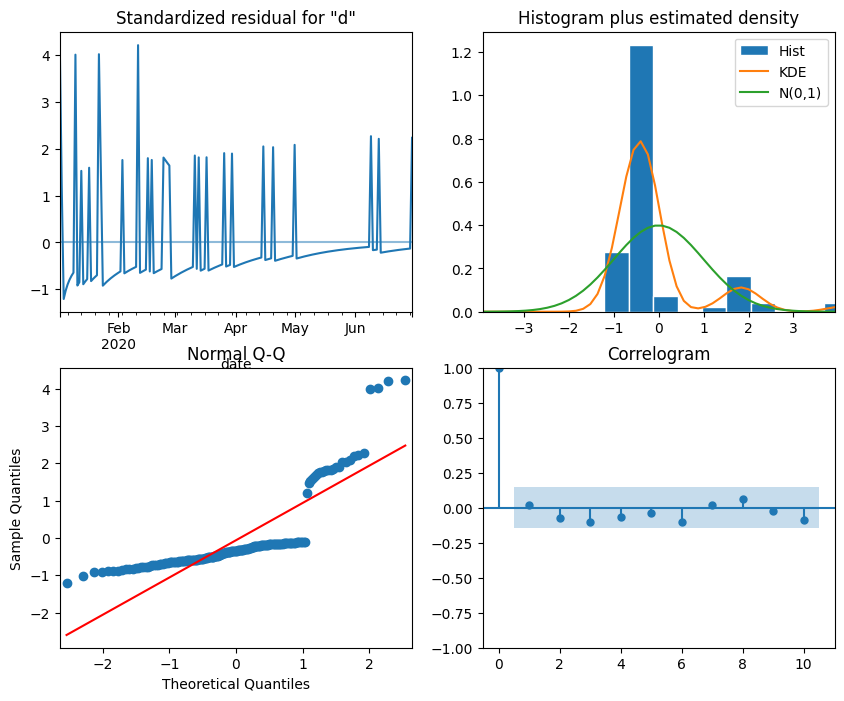

In [165]:
# Plots the Q-Q plot 
d_arima_model.plot_diagnostics(figsize=(10,8)); 
plt.savefig('54.H.png')

In [166]:
from statsmodels.stats.diagnostic import acorr_ljungbox 
acorr_ljungbox(d_arima_model.resid)

lb_stat  lb_pvalue
1   0.094769   0.758200
2   1.191270   0.551212
3   3.126041   0.372597
4   4.097147   0.393018
5   4.426753   0.489743
6   6.594391   0.359990
7   6.700438   0.460722
8   7.698802   0.463431
9   7.855297   0.548792
10  9.360129   0.498301

**Test Model**

In [167]:
len_test = len(dtest) 
len_test

28

In [170]:
 #Prediction with ARIMA model (get forecast predictions for the next month)
d_arima_pred = d_arima_model.get_forecast(len_test).predicted_mean.values
d_arima_pred

array([0.08332895, 0.08315553, 0.08298247, 0.08280978, 0.08263744,
       0.08246546, 0.08229384, 0.08212257, 0.08195167, 0.08178111,
       0.08161092, 0.08144107, 0.08127159, 0.08110245, 0.08093366,
       0.08076523, 0.08059715, 0.08042941, 0.08026203, 0.08009499,
       0.07992831, 0.07976197, 0.07959597, 0.07943032, 0.07926502,
       0.07910005, 0.07893544, 0.07877116])

In [171]:
d_naive_pred = dtrain['daily_accidents'][len(dtrain)-28:len(dtrain)].values 
d_naive_pred

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [172]:
# Assign predictions dataframe called test
dtest['d_naive_pred'] = d_naive_pred 
dtest['d_arima_pred'] = d_arima_pred

In [174]:
dtest.head()

daily_accidents  d_naive_pred  d_arima_pred
date                                                   
2020-07-01              0.0           0.0      0.083329
2020-07-02              0.0           0.0      0.083156
2020-07-03              0.0           0.0      0.082982
2020-07-04              0.0           0.0      0.082810
2020-07-05              0.0           0.0      0.082637

**Evaluate model**

In [179]:
 # actual value vs predicted value
darima_mse = mean_squared_error(dtest['daily_accidents'], dtest['d_arima_pred'])  # Calculate MSE
darima_rmse = np.sqrt(darima_mse)  # Take the square root to get RMSE

dnaive_mse = mean_squared_error(dtest['daily_accidents'], dtest['d_naive_pred'])  # Calculate MSE
dnaive_rmse = np.sqrt(dnaive_mse)  # Take the square root to get RMSE

**Plot residuals**

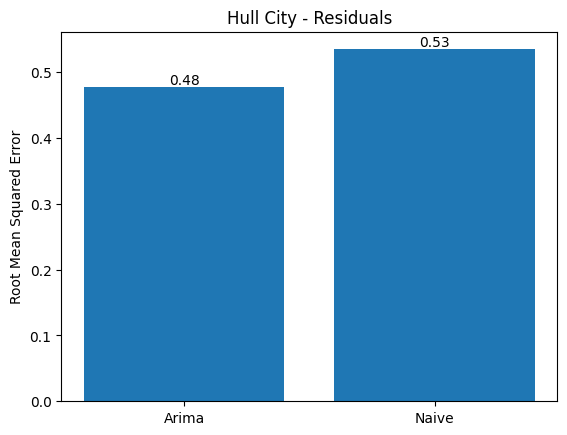

In [180]:
dlist_rmse = [darima_rmse,dnaive_rmse] 

models = ['Arima', 'Naive'] # just strings

plt.bar(x=models,height=dlist_rmse)
plt.ylabel('Root Mean Squared Error') 
plt.title('Hull City - Residuals')

 # This section adds text to the bars
for i, value in enumerate(dlist_rmse): # iterate over list_rmse variable
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom') 
    plt.savefig('55.H.png')
plt.show()

**Forecast for July**

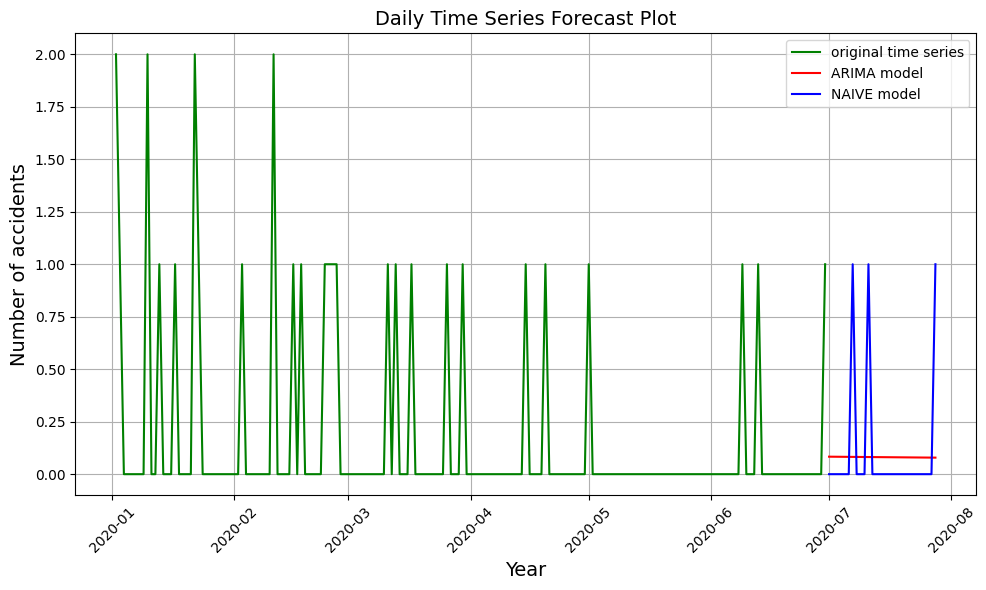

In [185]:
plt.figure(figsize=(10, 6))
plt.plot(dtrain, linestyle='-', label='original time series', color='g') # original time series

plt.plot(dtest["d_arima_pred"], linestyle='-' , label='ARIMA model', color = 'r') # plot showing ARIMA predictions made

plt.plot(dtest["d_naive_pred"], linestyle='-' , label='NAIVE model', color = 'b') # plot showing NAIVE predictions made

# Adding titles and labels
plt.title("Daily Time Series Forecast Plot", fontsize=14)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of accidents", fontsize=14)

# Show plot
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('56.H.png')
plt.show()

### 8. Construct a social network using the provided data and visualise the network
then provide the basic network characteristics, including numbers of nodes and edges, network density, average degree.

In [6]:
  # Create a directed graph from the facebook_combined txt file
G = nx.read_edgelist('facebook_combined.txt', nodetype=int, data=(('weight', float),))
G

In [7]:
# Calculate basic network statistics
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = nx.density(G)

print("Basic Network Statistics:")
print(f"Number of Nodes: {num_nodes}")
print(f"Number of Edges: {num_edges}")
print(f"Density: {density}")

Basic Network Statistics:
Number of Nodes: 4039
Number of Edges: 88234
Density: 0.010819963503439287


#### Graph Degree Distribution Analysis

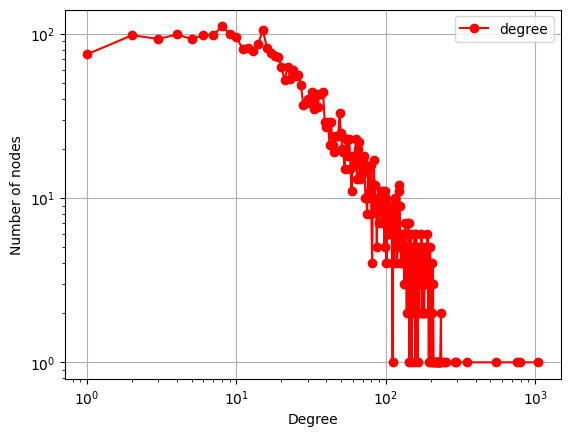

In [8]:
degrees = G.degree() # dictionary node:degree
values = sorted(set(dict(degrees).values()))
hist = [list(dict(degrees).values()).count(x) for x in 
values]

plt.figure() 

plt.grid(True)
plt.loglog(values, hist, 'ro-') # changing the scale to keep the data readable.
plt.legend(['degree'])
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.savefig("57.SS.png")
plt.show()


#### Centrality Measures Analysis


**Degree Centrality**

In [9]:
degree_centrality = nx.degree_centrality(G)

highest_degree_nodes = sorted(degree_centrality.items(), 
key=lambda x: x[1], reverse=True)[:5]

print("Nodes with the Highest Degree Centrality:")

for node, centrality in highest_degree_nodes:
 print(f"{node}: {centrality}")

Nodes with the Highest Degree Centrality:
107: 0.258791480931154
1684: 0.1961367013372957
1912: 0.18697374938088163
3437: 0.13546310054482416
0: 0.08593363051015354


**Closeness Centrality**

In [10]:
 # Closeness Centrality
closeness_centrality = nx.closeness_centrality(G)
highest_closeness_nodes = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

print("\nNodes with the Highest Closeness Centrality:")
for node, centrality in highest_closeness_nodes:
    print(f"{node}: {centrality}")


Nodes with the Highest Closeness Centrality:
107: 0.45969945355191255
58: 0.3974018305284913
428: 0.3948371956585509
563: 0.3939127889961955
1684: 0.39360561458231796


**Betweenness Centrality**

In [11]:
 # Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G)
highest_betweenness_nodes = sorted(betweenness_centrality.items(), key=lambda x: x[1], 
reverse=True)[:5]
print("\nNodes with the Highest Betweenness Centrality:")
for node, centrality in highest_betweenness_nodes:
    print(f"{node}: {centrality}")


Nodes with the Highest Betweenness Centrality:
107: 0.4805180785560152
1684: 0.3377974497301992
3437: 0.23611535735892905
1912: 0.2292953395868782
1085: 0.14901509211665306


**Eigenvector Centrality**

In [12]:
# Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(G)
highest_eigenvector_nodes = sorted(eigenvector_centrality.items(), key=lambda x: x[1], 
reverse=True)[:5]
print("\nNodes with the Highest Eigenvector Centrality:")
for node, centrality in highest_eigenvector_nodes:
 print(f"{node}: {centrality}")


Nodes with the Highest Eigenvector Centrality:
1912: 0.09540696149067629
2266: 0.08698327767886552
2206: 0.08605239270584342
2233: 0.08517340912756598
2464: 0.08427877475676092


**PageRank**

In [13]:
# PageRank
pagerank = nx.pagerank(G)
highest_pagerank_nodes = sorted(pagerank.items(), key=lambda 
x: x[1], reverse=True)[:5]
print("\nNodes with the Highest PageRank:")
for node, centrality in highest_pagerank_nodes:
 print(f"{node}: {centrality}")


Nodes with the Highest PageRank:
3437: 0.0076145868447496
107: 0.006936420955866117
1684: 0.006367162138306824
0: 0.006289602618466542
1912: 0.003876971600884498


#### Community Detection Analysis

* Use community detection algorithms to identify clusters within the network
* Explore the modularity and cohesion of these communities. 

In [14]:
# Apply community detection algorithm
communities = nx.algorithms.community.greedy_modularity_communities(G)

# Explore the modularity and cohesion of communities
modularity = nx.algorithms.community.modularity(G, communities)
num_communities = len(communities)
average_community_size = sum(len(community) for community in 
communities) / num_communities

print("Community Detection Results:")
print(f"Number of Communities: {num_communities}")
print(f"Average Community Size: {average_community_size}")
print(f"Modularity: {modularity}")

Community Detection Results:
Number of Communities: 13
Average Community Size: 310.6923076923077
Modularity: 0.7773775199040279


#### Comparing Community Detection Algorithms

* Select a few community detection algorithmns to compare . Some options include Louvain Modularity, Girvan-Newman, Label Propagation

In [15]:
algorithms = [ "Louvain Modularity", "Label Propagation"]

# Dictionary to store communities detected by each algorithm
detected_communities = {}

# Apply each community detection algorithm and store the detected communities

for algorithm in algorithms:
    if algorithm == "Louvain Modularity":
        communities = nx.algorithms.community.greedy_modularity_communities(G)
    elif algorithm == "Label Propagation":
         communities = nx.algorithms.community.label_propagation_communities(G)
    detected_communities[algorithm] = communities

print ('community detection done')

community detection done


**Evaluate and Compare results**

In [16]:
# Evaluate and compare the results
for algorithm, communities in detected_communities.items():
    modularity = nx.algorithms.community.modularity(G, communities)
    num_communities = len(communities)
    average_community_size = sum(len(community) for community in communities) / num_communities
    print(f"{algorithm}:")
    print(f"Modularity: {modularity}")
    print(f"Number of Communities: {num_communities}")
    print(f"Average Community Size: {average_community_size}\n")

Louvain Modularity:
Modularity: 0.7773775199040279
Number of Communities: 13
Average Community Size: 310.6923076923077

Label Propagation:
Modularity: 0.7368407345348218
Number of Communities: 44
Average Community Size: 91.79545454545455



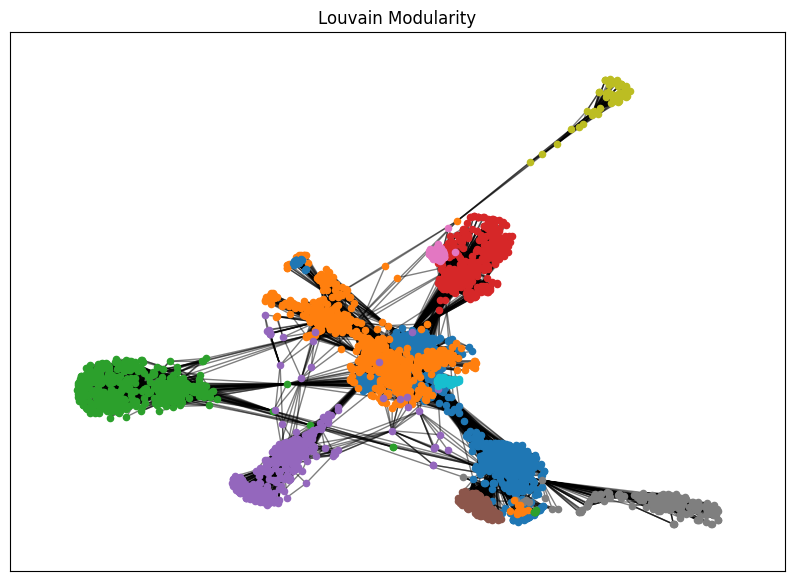

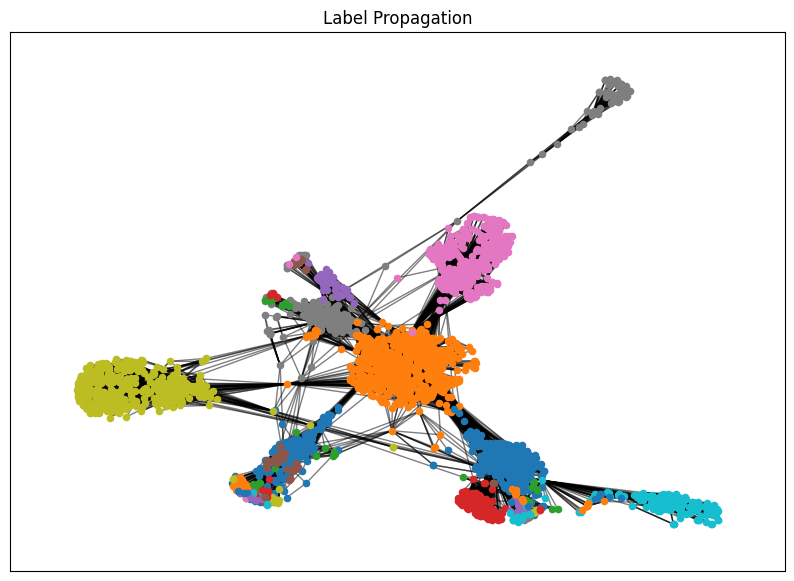

In [17]:
# Visualize community structures separately
pos = nx.spring_layout(G)

for algorithm, communities in detected_communities.items():
    plt.figure(figsize=(10, 7))  # Create a new figure for each algorithm
    colors = [f'C{i}' for i in range(len(communities))]
    
    for j, community in enumerate(communities):
        nx.draw_networkx_nodes(G, pos, nodelist=community, node_color=colors[j], node_size=20)
    
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    
    plt.title(algorithm)
    plt.savefig(f"{algorithm}_community.png")  # Save each plot separately
    plt.show()  # Show each plot separately
